In [11]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

In [15]:
f = 'base_original/binding_energies/1.0_c-5.50o-3.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv'
df = pd.read_csv(f)
species = df.loc[:, 'Species'].to_list()
properties = df.columns.to_list()

In [16]:
species

['X(1)',
 'HX(21)',
 'CO2X(22)',
 'COX(23)',
 'CH4X(24)',
 'OX(25)',
 'CH2X(26)',
 'CH3X(27)',
 'CHX(28)',
 'CX(29)',
 'H2X(30)',
 'OHX(31)',
 'H2OX(32)',
 'CHOX(33)',
 'CHOX(234)',
 'CH3O_X(45)',
 'CH4OX(43)',
 'C2H3X(244)',
 'CH2O_X(46)',
 'C2H6X(65)']

In [17]:
properties

['Unnamed: 0',
 'Species',
 'SYNGAS Selec',
 'SYNGAS Yield',
 'CO Selectivity',
 'CO % Yield',
 'H2 Selectivity',
 'H2 % Yield',
 'CH4 Conversion',
 'H2O+CO2 Selectivity',
 'H2O+CO2 yield',
 'Exit Temp',
 'Peak Temp',
 'Dist to peak temp',
 'O2 Conversion',
 'Max CH4 Conv',
 'Dist to 50 CH4 Conv']

In [30]:
def outliers(base_dir):
    benergy_c = np.arange(-7.5, -5.25, 0.25)
    benergy_o = np.arange(-3.25, -5.5, -0.25)
    outliers = []
    total = 81
    i = -1
    paths = []
    for c_binding_energy in benergy_c:
        i += 1
        j = -1
        index = total - ((7.5 - abs(c_binding_energy)) / 0.25 + 1) * 9
        for o_binding_energy in benergy_o:
            j += 1
            index += 1

            try:
                f_path = '{}/{}_c{:.2f}o{:.2f}/sim_data/rtol_1e-10_atol_1e-20_data.csv'.format(base_dir, index, c_binding_energy, o_binding_energy)
                df = pd.read_csv(f_path)
                ch4_conv = df.loc[df['C/O ratio'].round(2) == 1.0].loc[:,'Max CH4 Conv'].to_list()[0]
                if abs(ch4_conv) < 0.05:
                    outliers.append(index)
            except Exception as e:
                print(e, f"check log files {index}")
    return outliers

In [13]:
def heat_map_gen(sp, property_, exclusion_original, exclusion_bm):
    """
    sp: index of species
    property_: index of the property to plot
    exclusion_original: a list of original model ids to be excluded from sensitivity data frame
    exclusion_bm: a list of bm model ids to be excluded from senstivity data frame
    """
    benergy_c = np.arange(-7.5, -5.25, 0.25)
    benergy_o = np.arange(-3.25, -5.5, -0.25)
    data_original = np.zeros((len(benergy_c), len(benergy_o)))
    data_bm = np.zeros((len(benergy_c), len(benergy_o)))
    # read the first file to extract the species and properties list
    f = 'base_original/binding_energies/1.0_c-5.50o-3.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv'
    df = pd.read_csv(f)
    species = df.loc[:, 'Species'].to_list()
    properties = df.columns.to_list()
    
    total = 81
    i = -1
    paths = []
    for c_binding_energy in benergy_c:
        i += 1
        j = -1
        index = total - ((7.5 - abs(c_binding_energy)) / 0.25 + 1) * 9
        for o_binding_energy in benergy_o:
            j += 1
            index += 1

            try:            
                # read the simulation files
                if index not in exclusion_original:
                    original_path_sens = 'base_original/binding_energies/{}_c{:.2f}o{:.2f}/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv'.format(index, c_binding_energy, o_binding_energy)
                    df_original = pd.read_csv(original_path_sens)
                    charac_sens_original = df_original.loc[df_original['Species'] == df_original['Species'][sp]].iloc[:,property_].to_list()[0]
                    data_original[j][i] = charac_sens_original
                                   
                if index not in exclusion_bm:
                    bm_path_sens = 'base_bm/binding_energies/{}_c{:.2f}o{:.2f}/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv'.format(index, c_binding_energy, o_binding_energy)
                    df_bm = pd.read_csv(bm_path_sens)
                    charac_sens_bm = df_bm.loc[df_bm['Species'] == df_bm['Species'][sp]].iloc[:,property_].to_list()[0]
                    data_bm[j][i] = charac_sens_bm
                    
            except Exception as e:
                print(e, f"check log files {index}")
    original_df = pd.DataFrame(data_original, columns=benergy_c, index=benergy_o)
    bm_df = pd.DataFrame(data_bm, columns=benergy_c, index=benergy_o)
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(121, aspect='equal')
    ax2 = fig.add_subplot(122, aspect='equal')
    cmap = sns.color_palette("viridis", as_cmap=True)
    ax1 = sns.heatmap(original_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax1)
    ax1.set(title="original models {} sensitivity of {} at C/O=1.0".format(properties[property_], species[sp]),
          xlabel="$\\Delta E^C(ev)$",
          ylabel="$\\Delta E^O(ev)$",)
    ax2 = sns.heatmap(bm_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax2)
    ax2.set(title="bm models {} sensitivity of {} at C/O=1.0".format(properties[property_], species[sp]),
          xlabel="$\\Delta E^C(ev)$",
          ylabel="$\\Delta E^O(ev)$",)
    plt.plot()

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sim_data/rtol_1e-10_atol_1e-20_data.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0


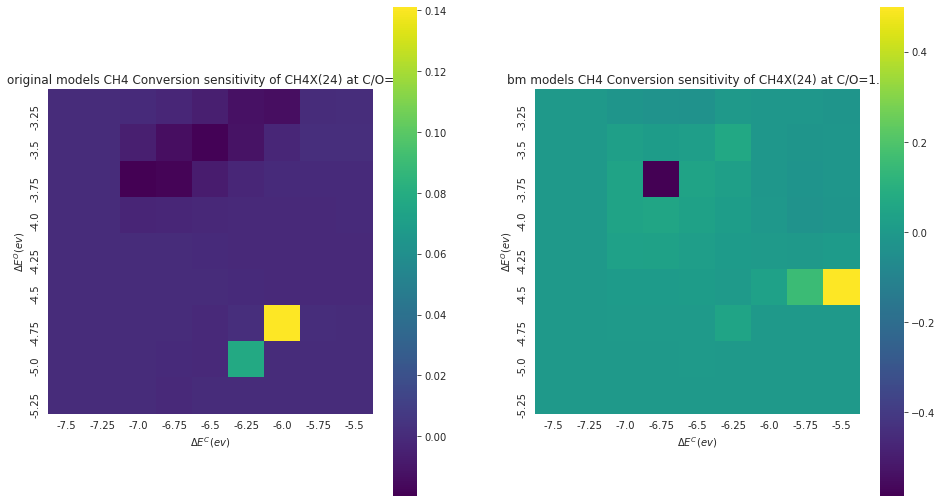

In [38]:
exceptions_original = outliers('base_original/binding_energies')
exceptions_bm = outliers('base_bm/binding_energies') 
exceptions_original.append(26)
exceptions_original.append(10)
heat_map_gen(4,8, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

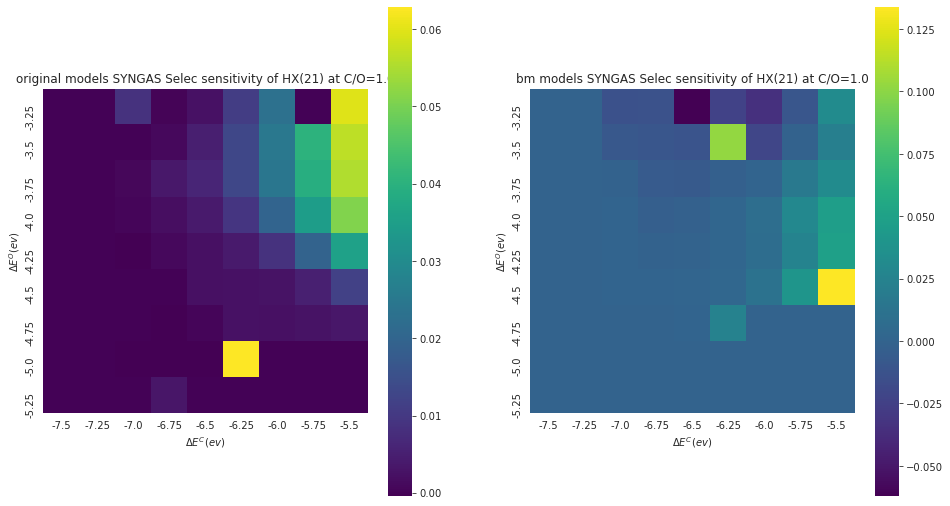

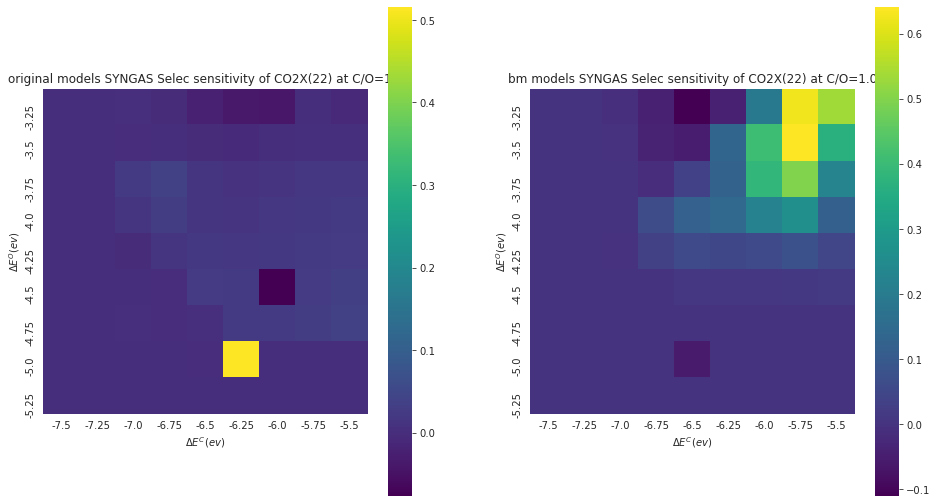

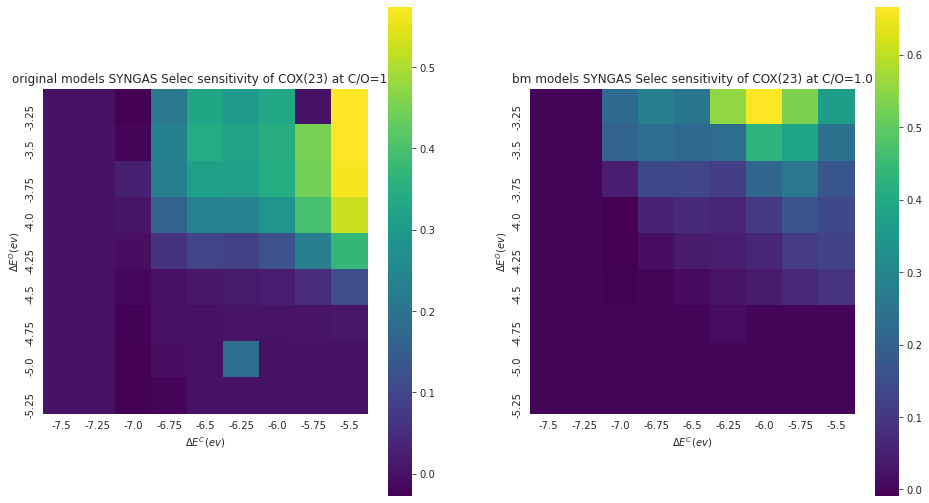

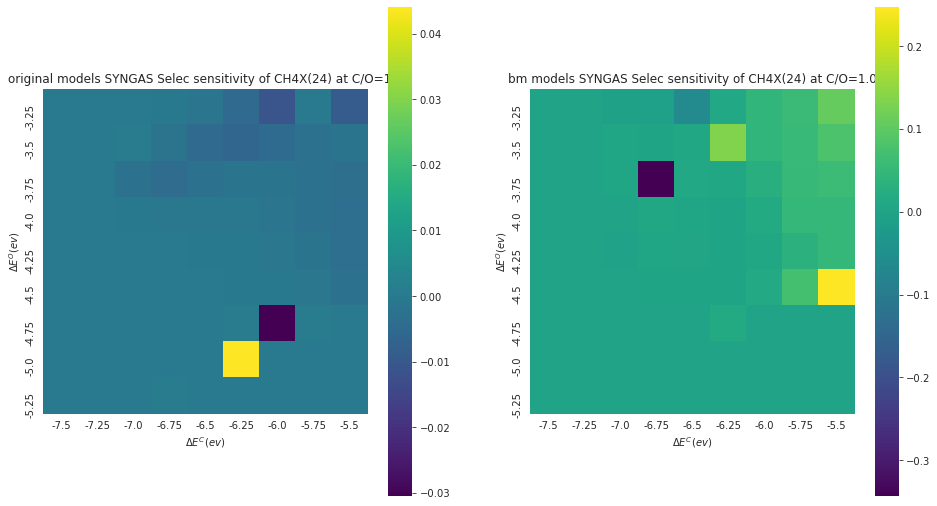

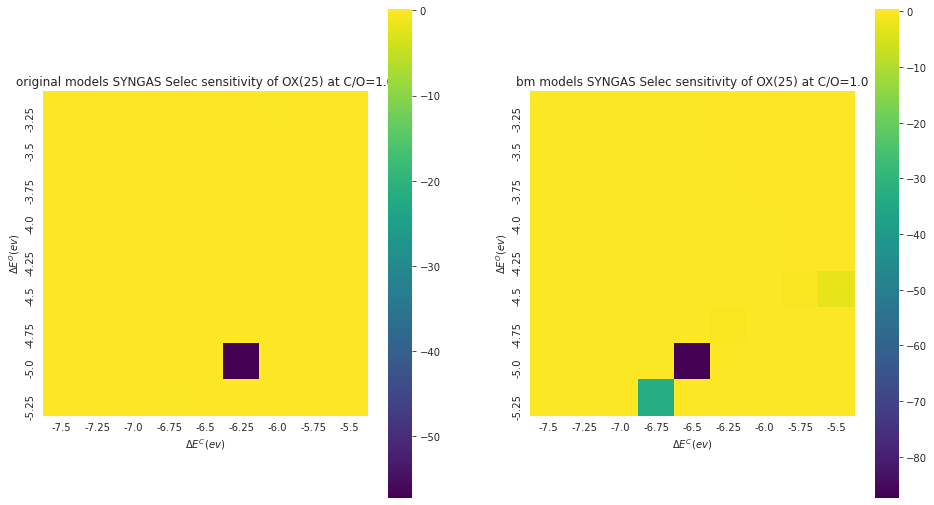

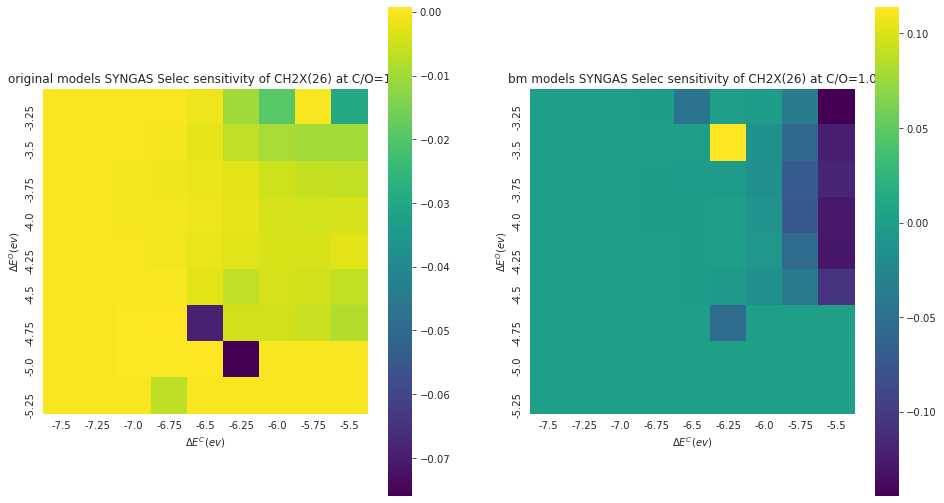

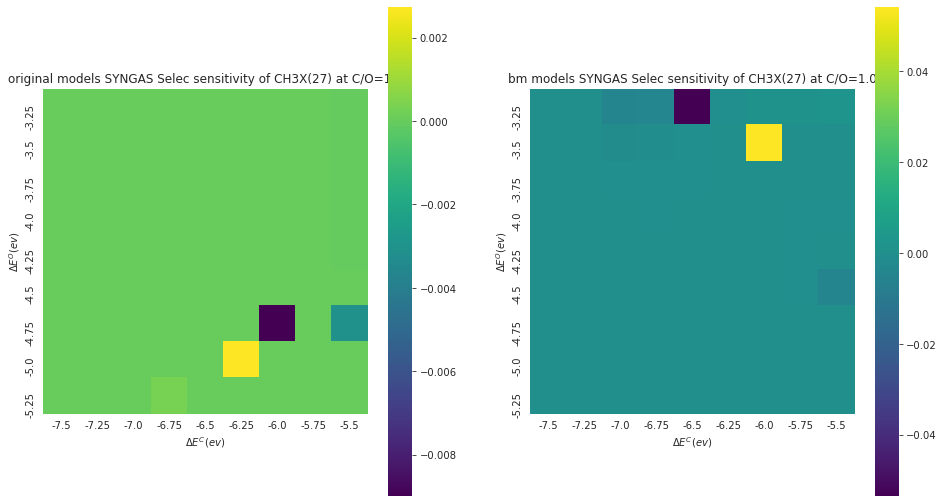

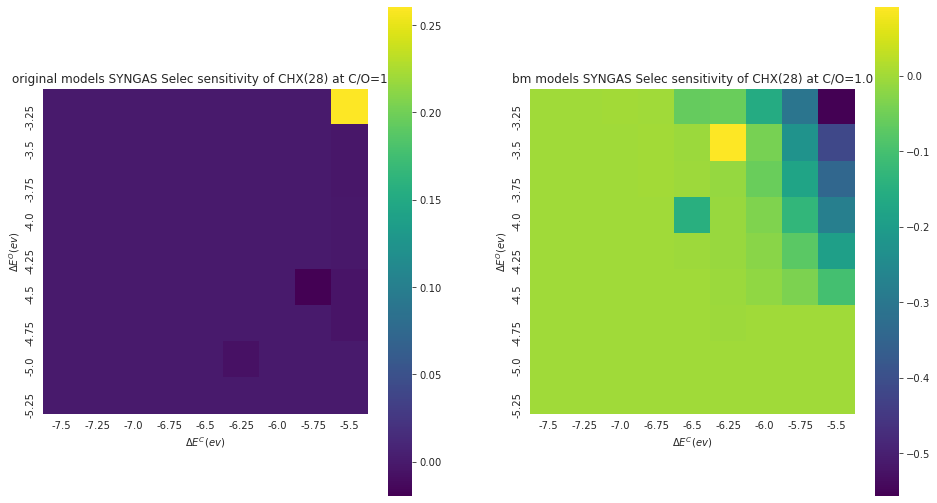

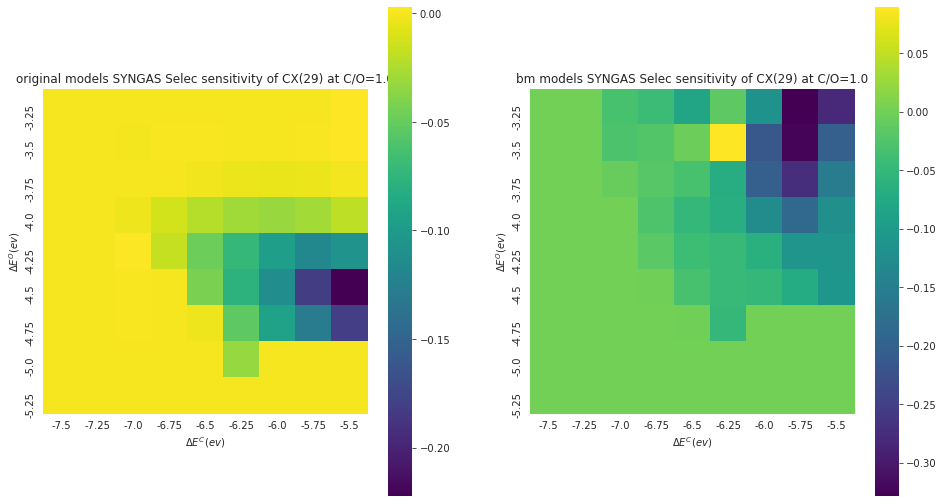

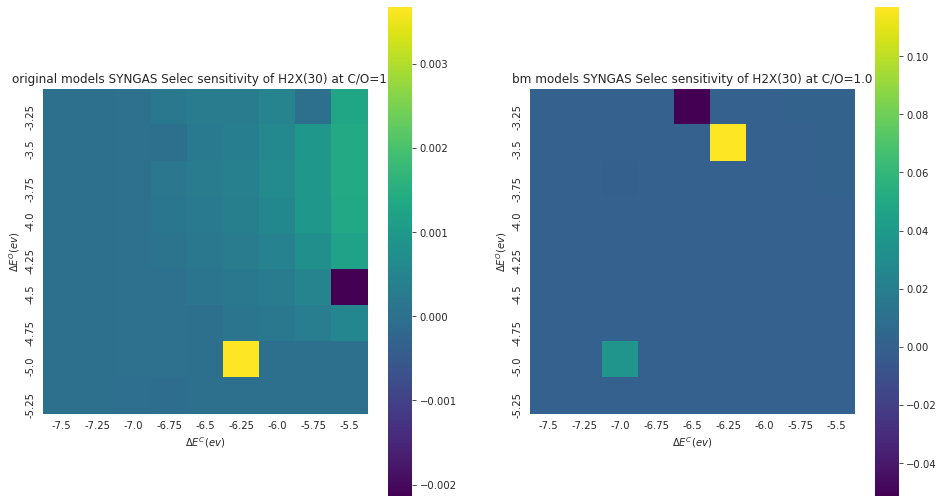

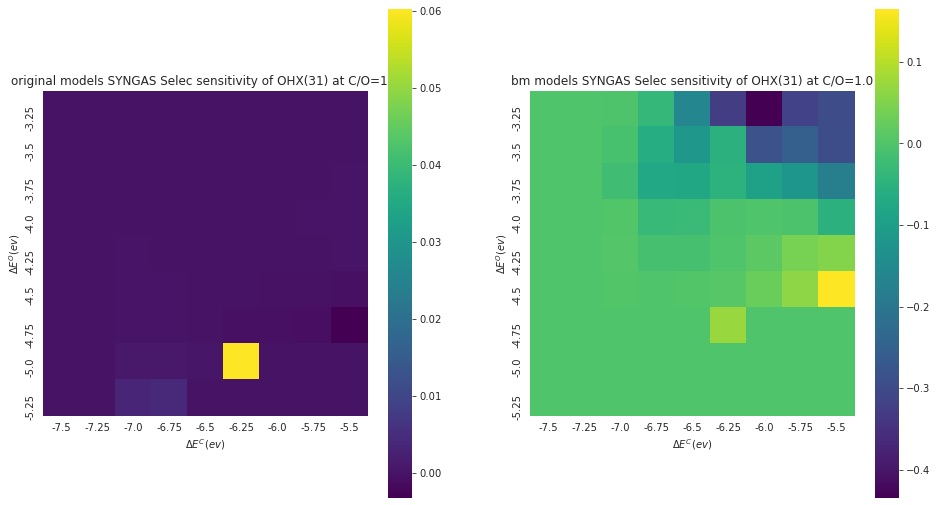

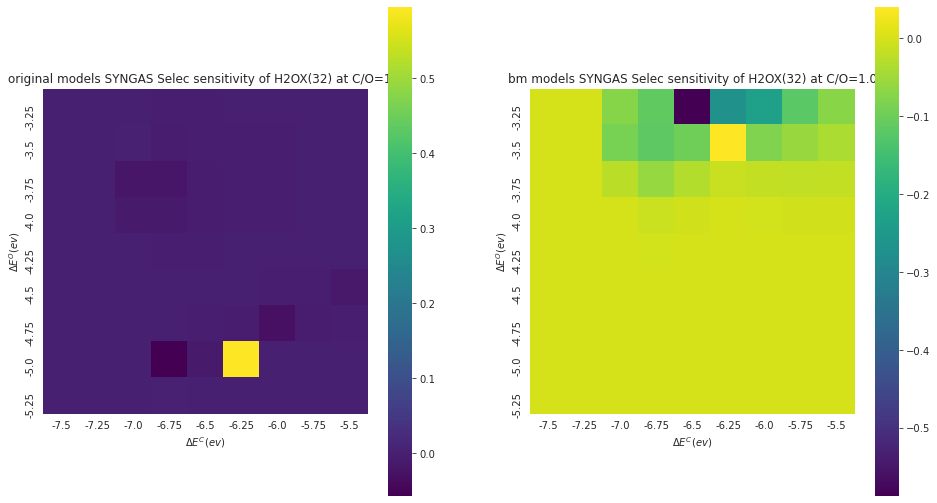

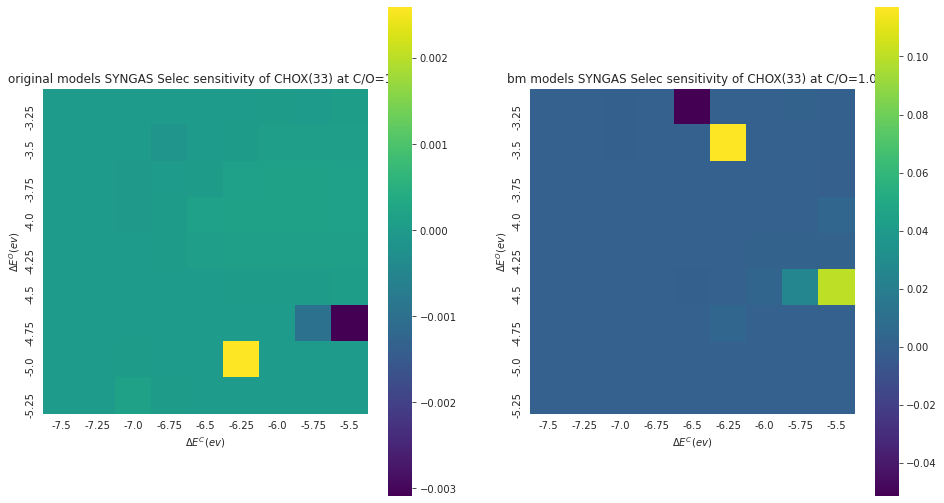

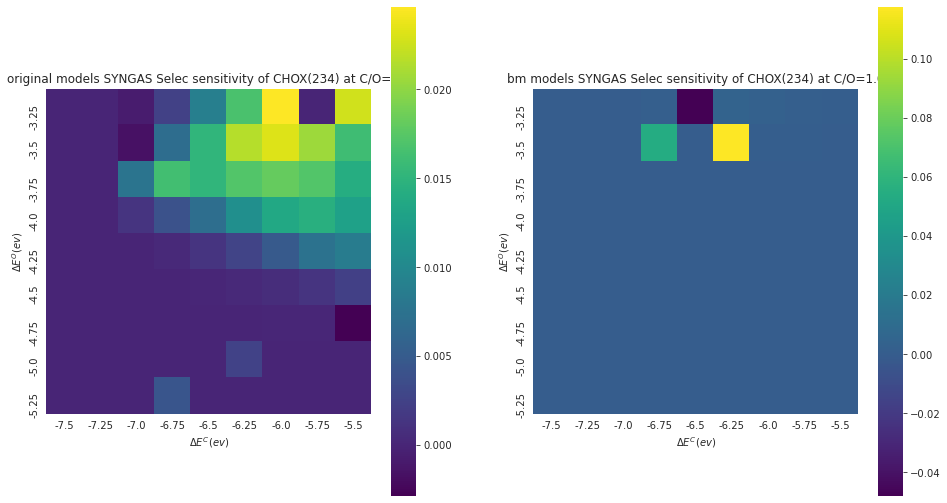

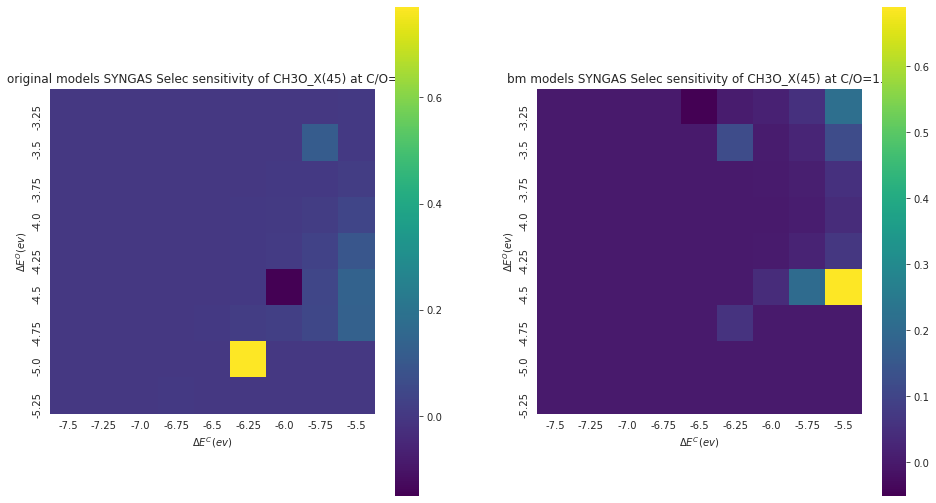

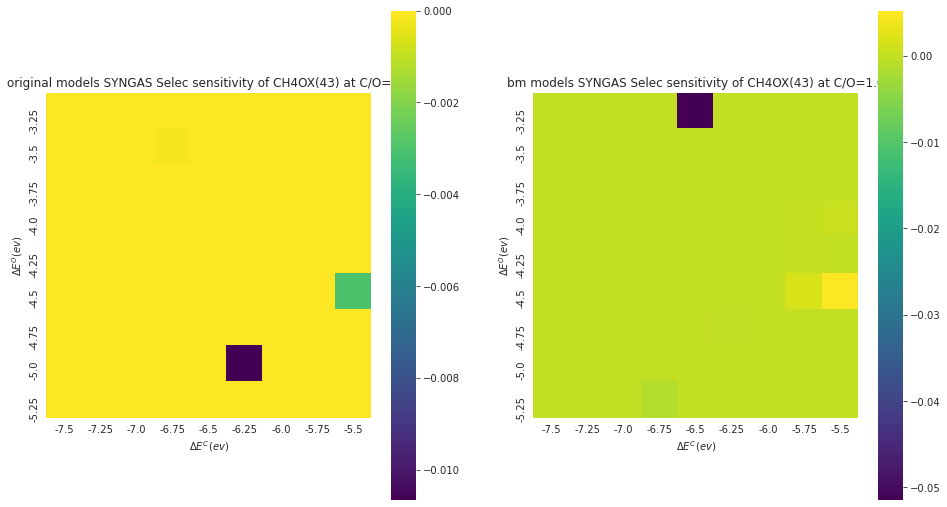

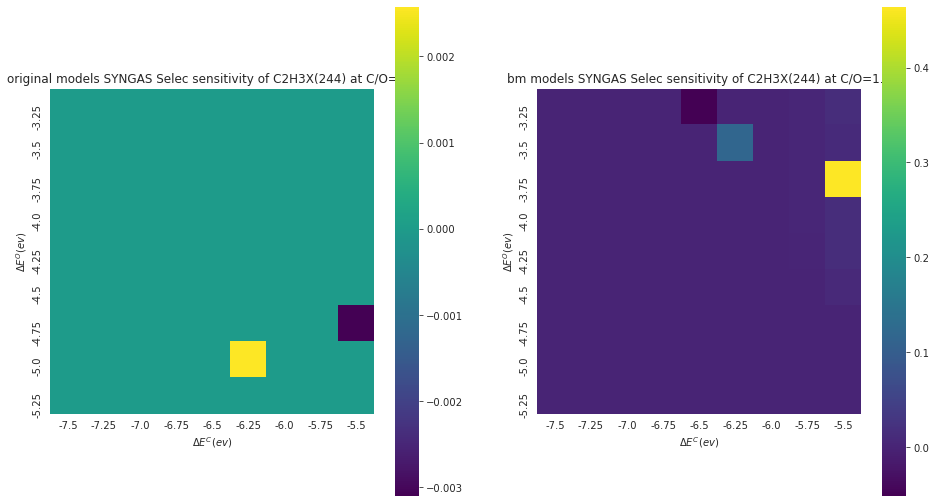

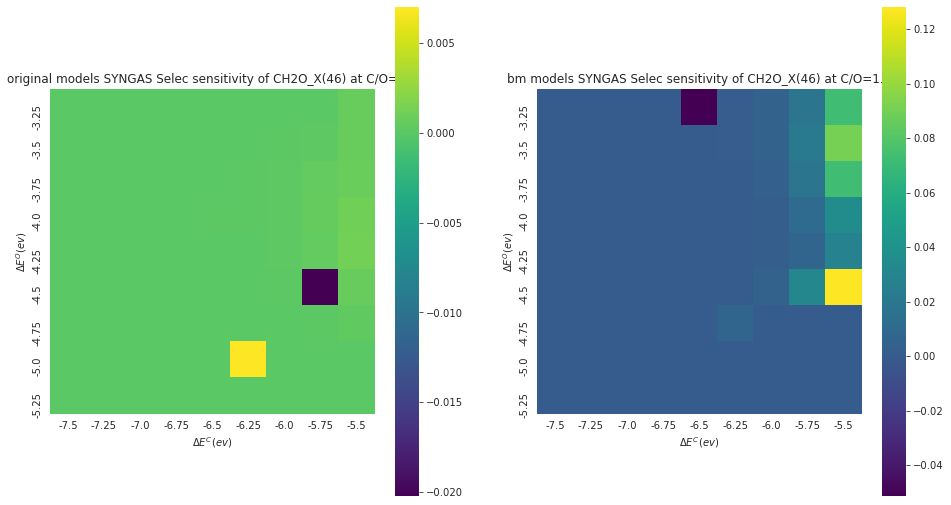

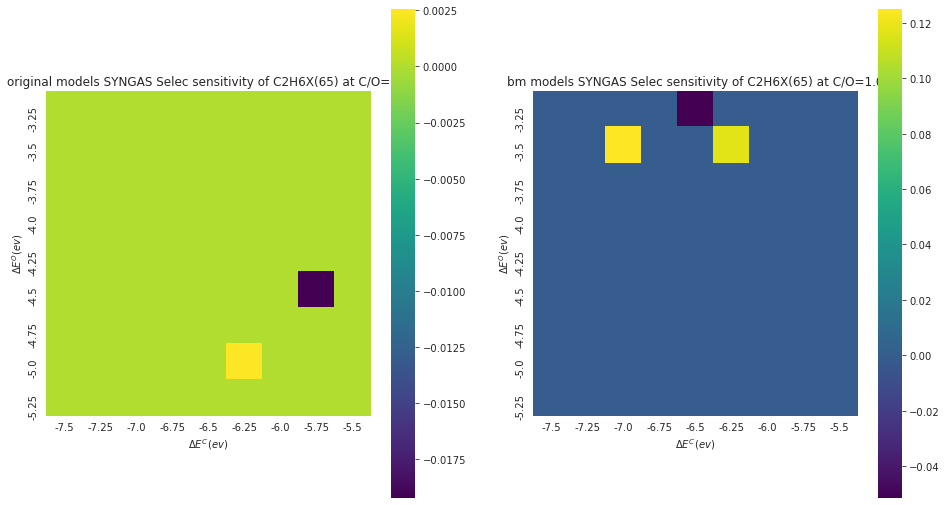

In [39]:
# SYNGAS Selec
for i in range(1, len(species)):
    heat_map_gen(i,2, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

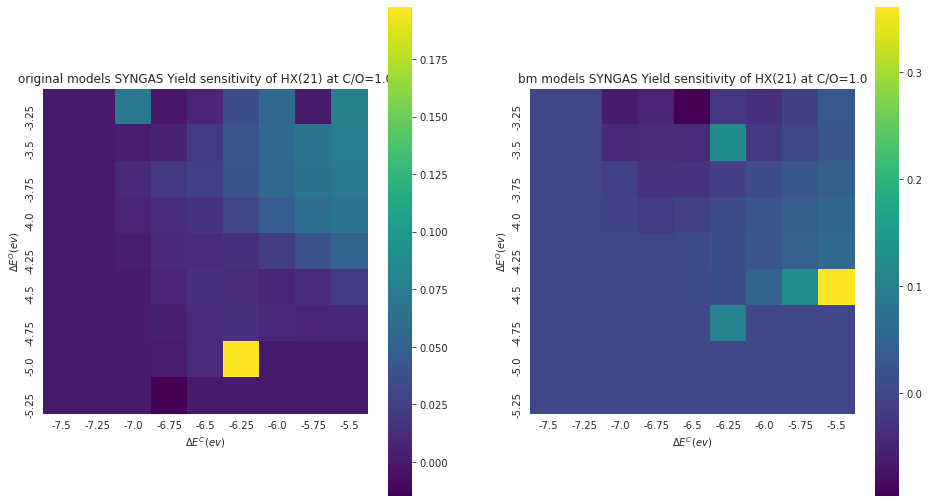

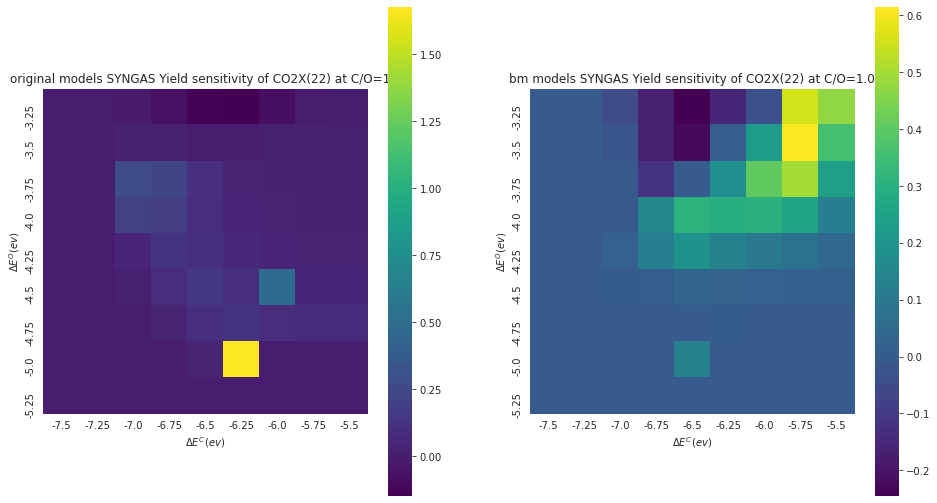

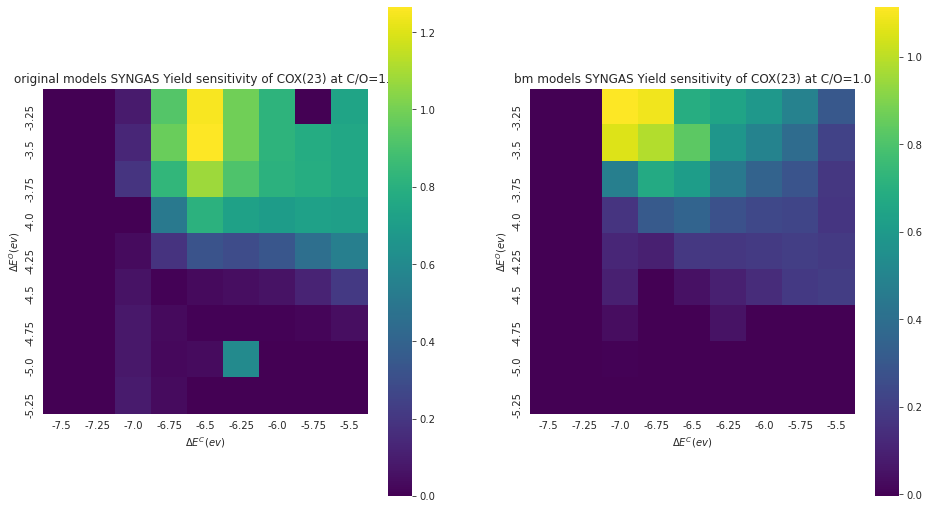

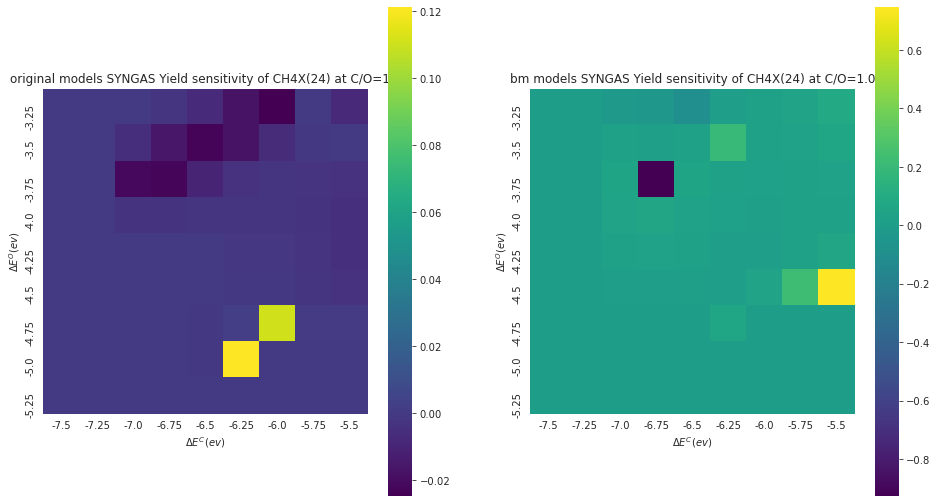

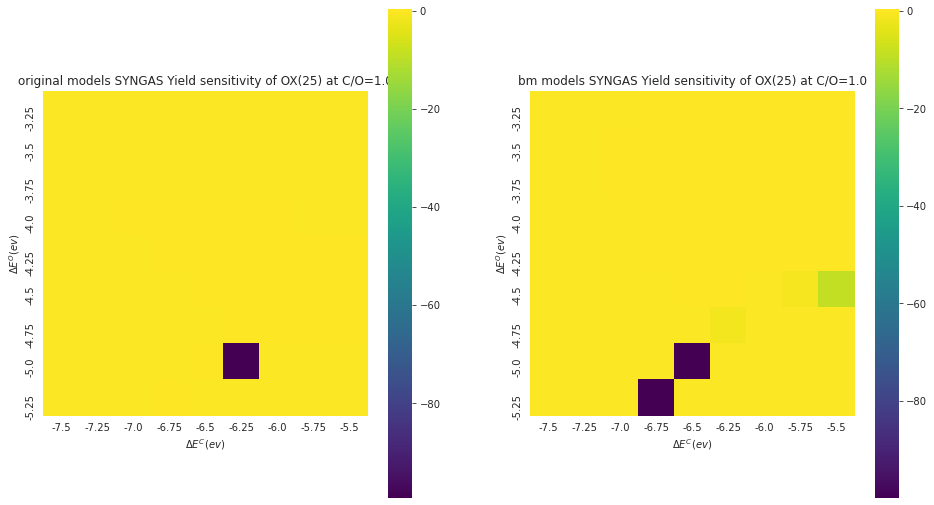

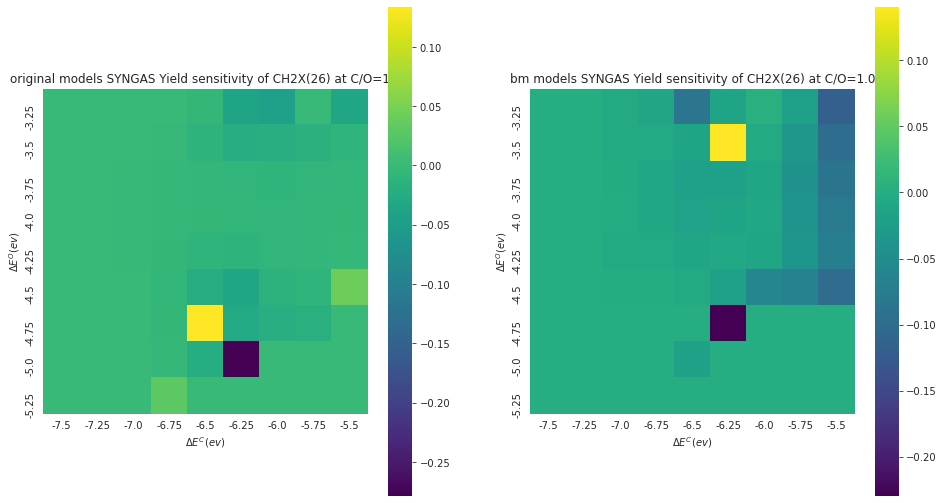

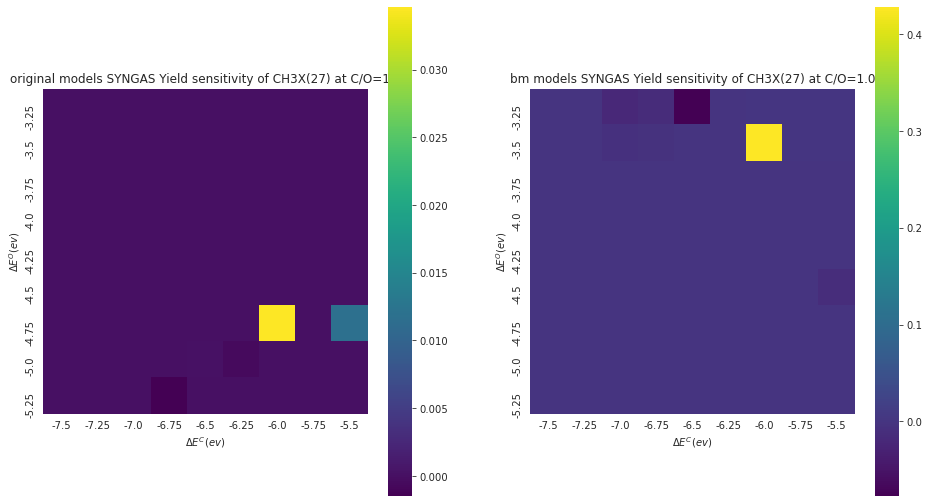

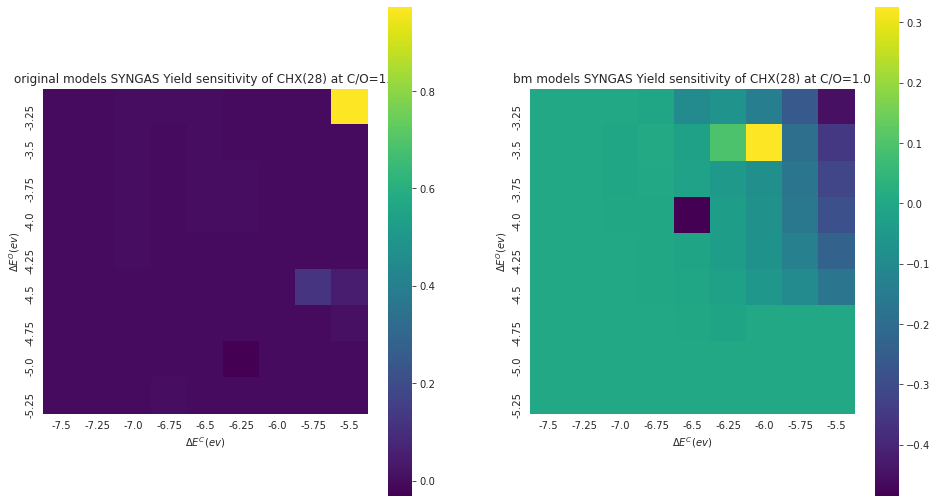

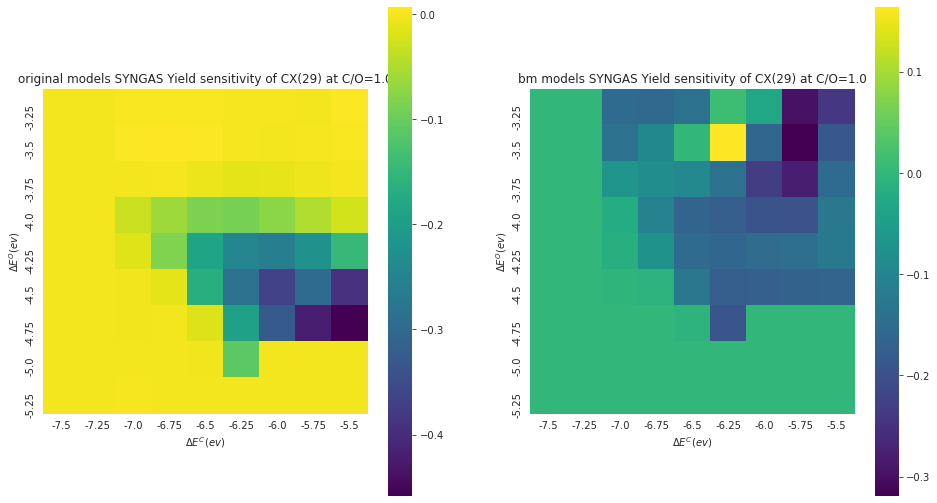

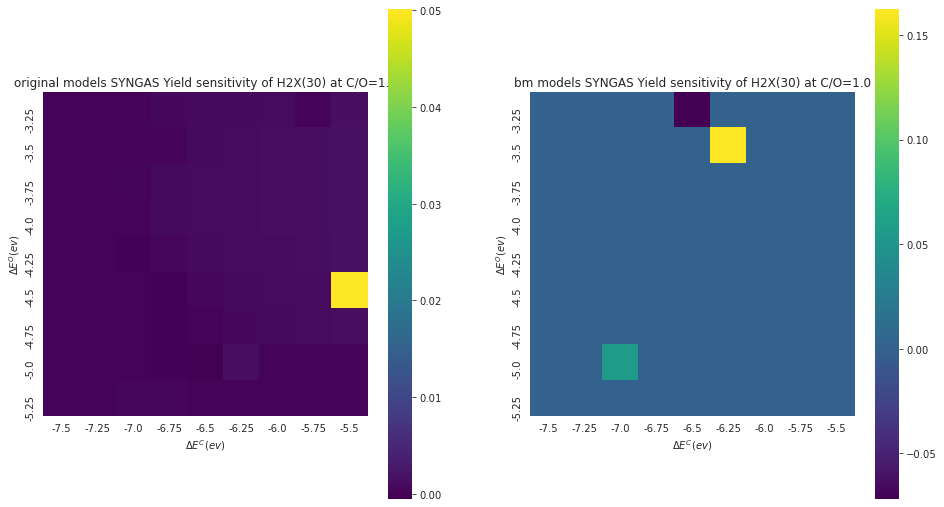

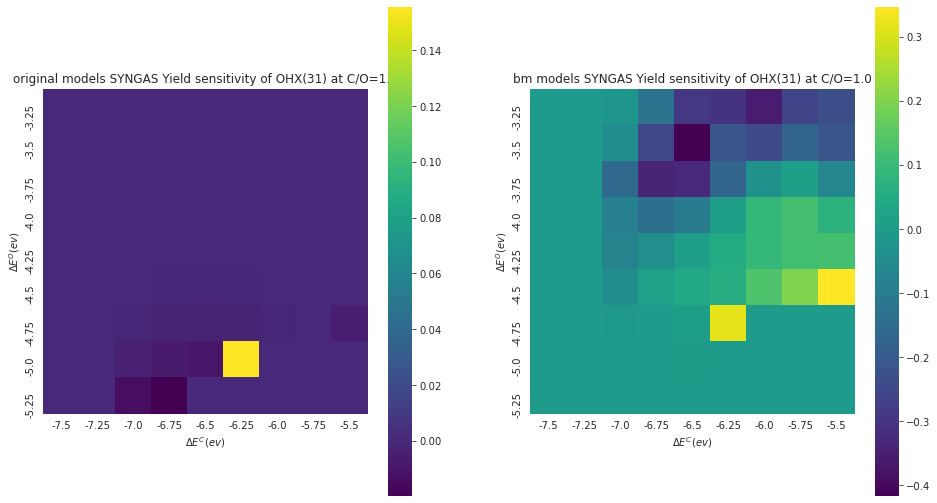

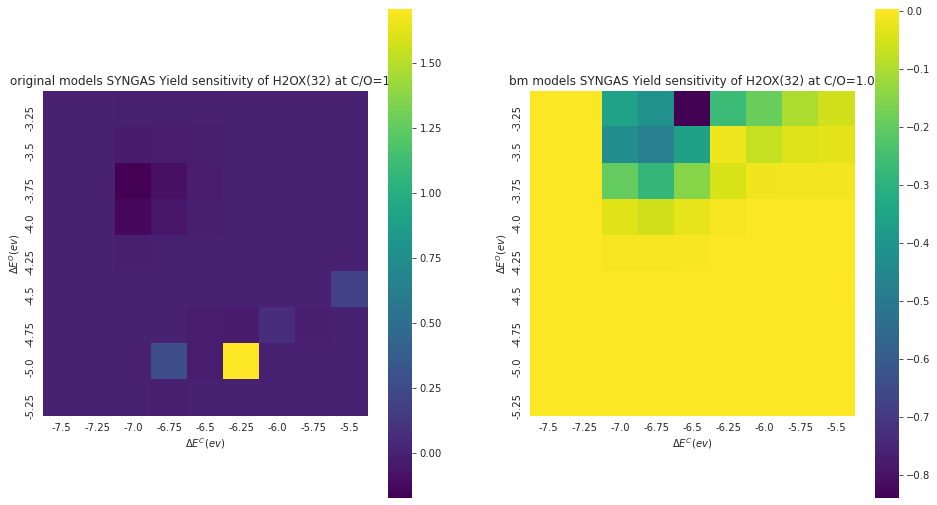

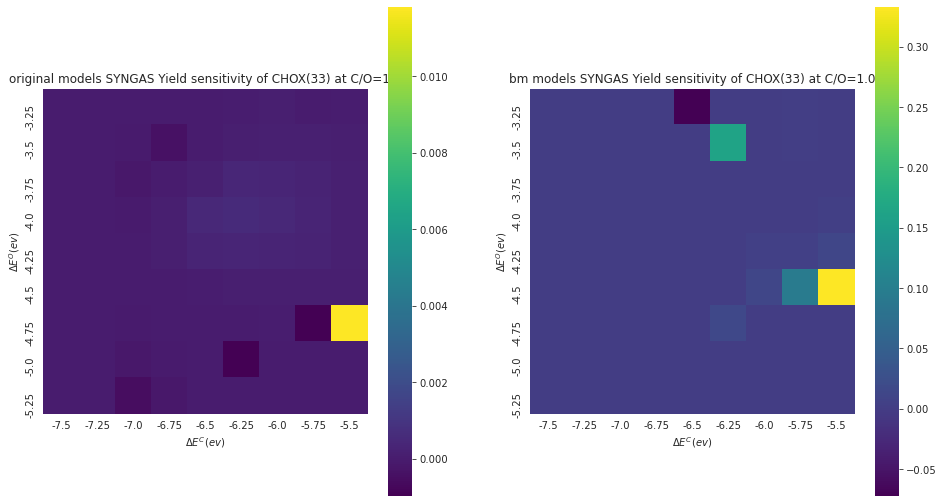

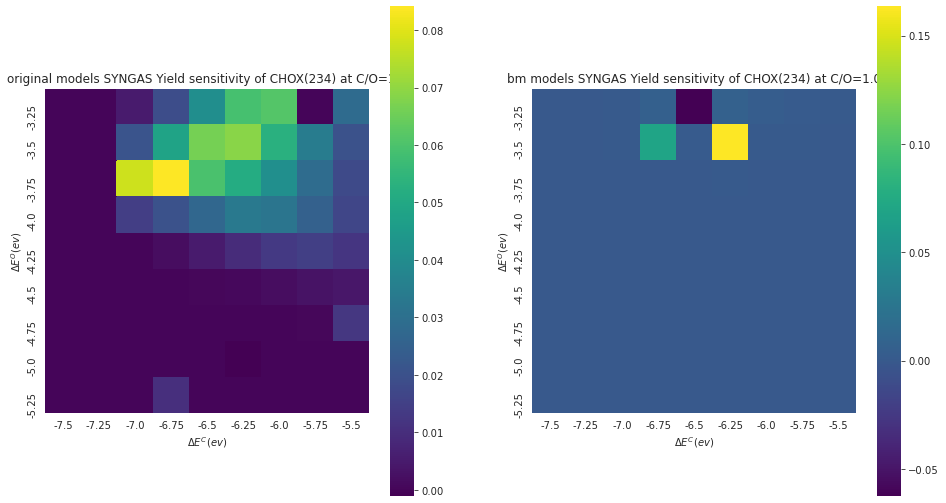

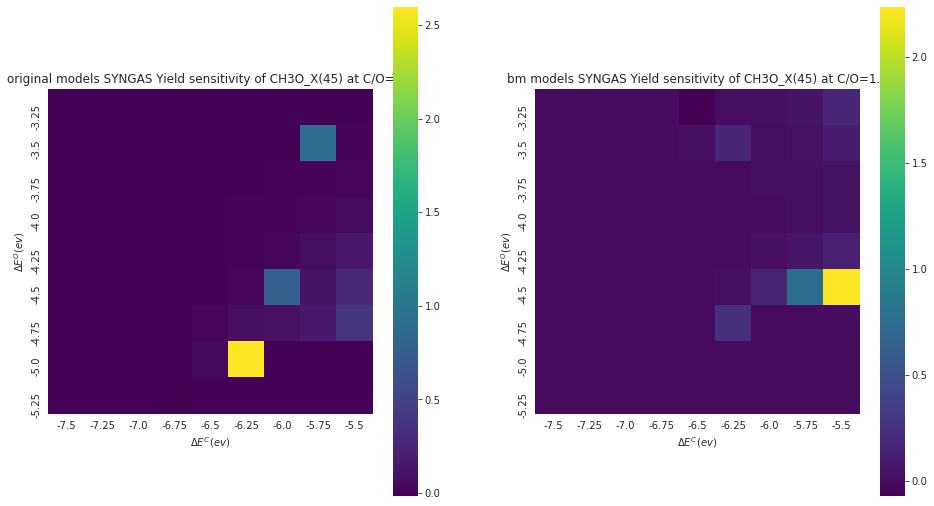

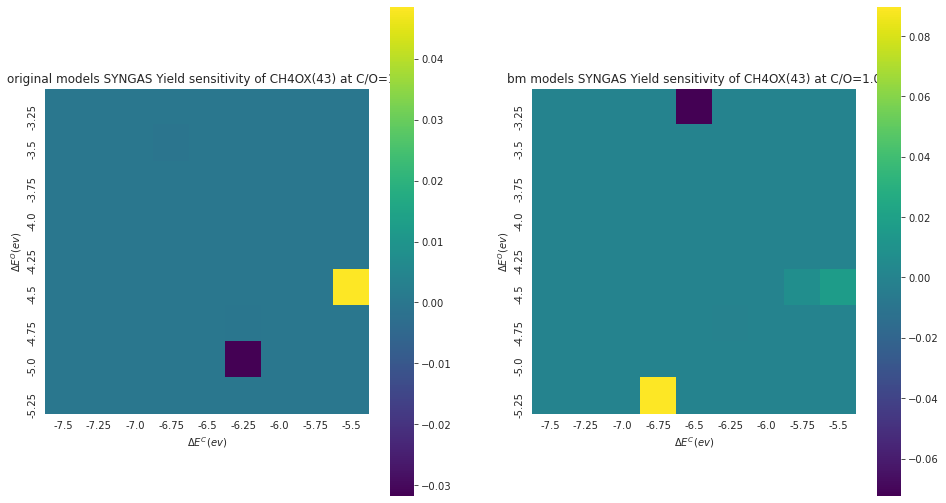

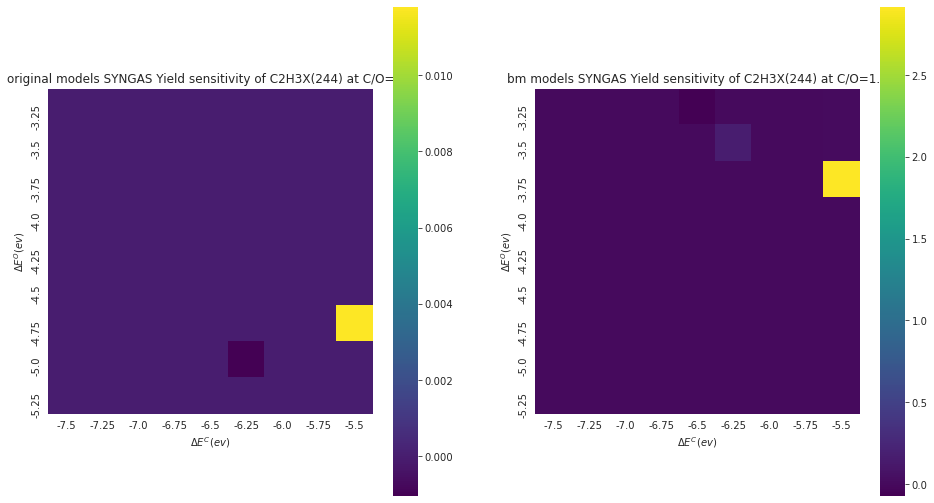

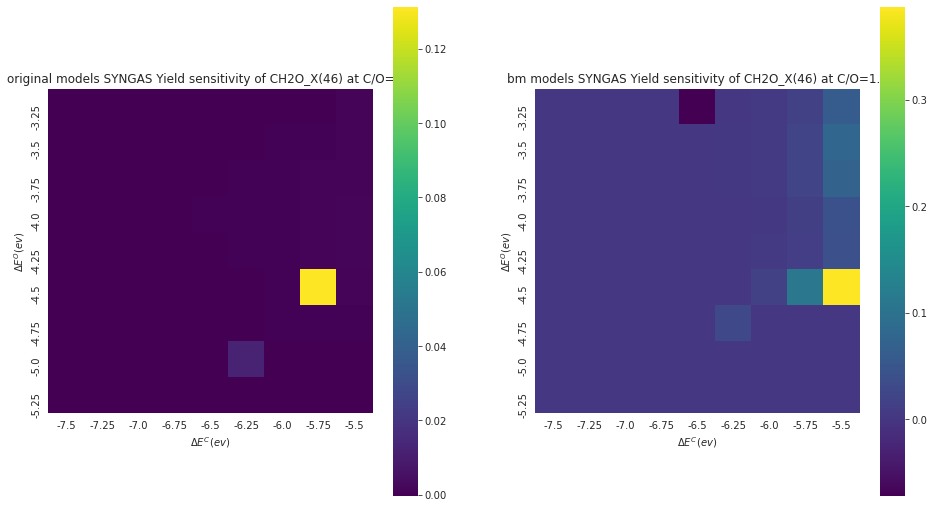

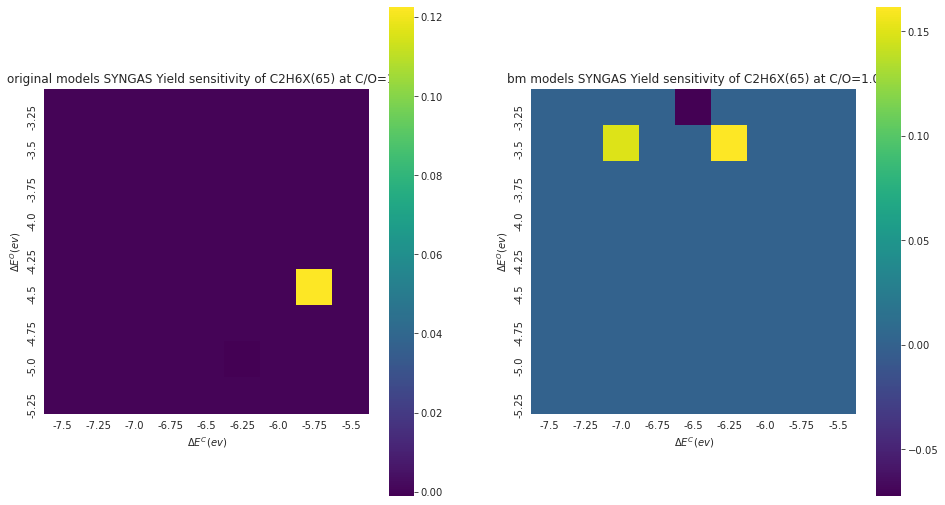

In [40]:
# SYNGAS Yield
for i in range(1, len(species)):
    heat_map_gen(i,3, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

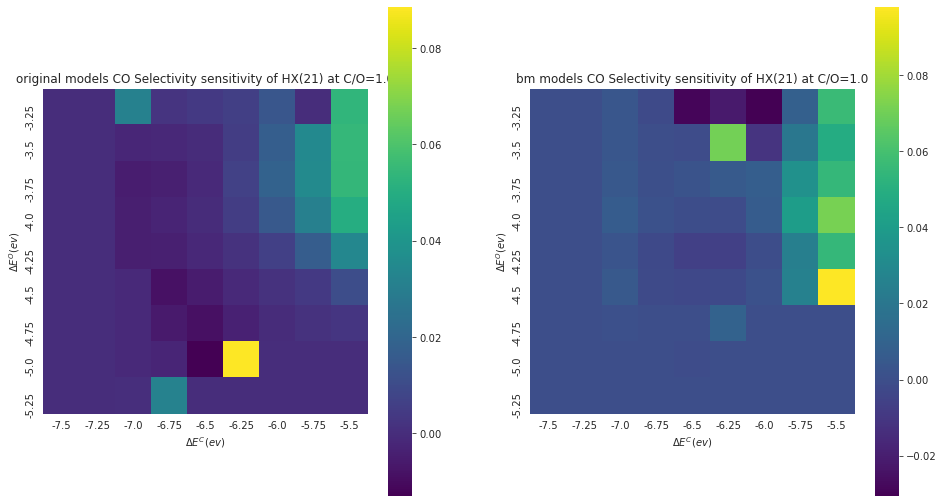

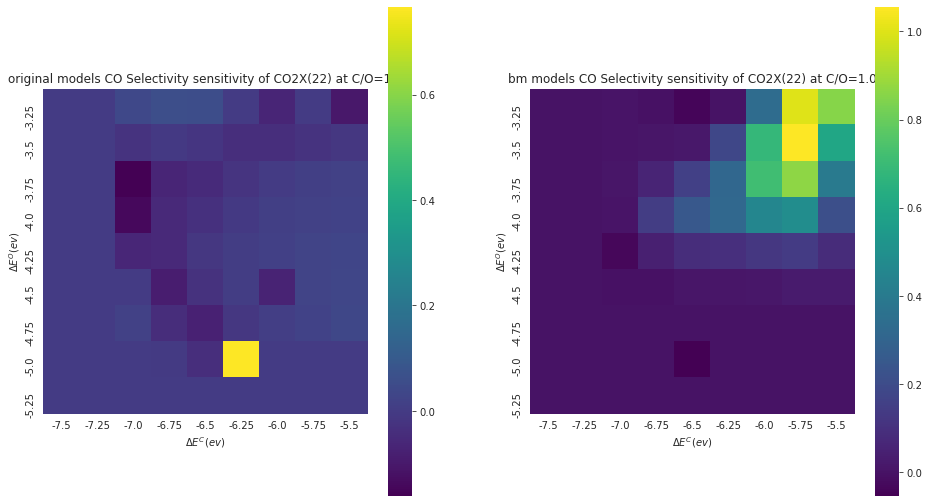

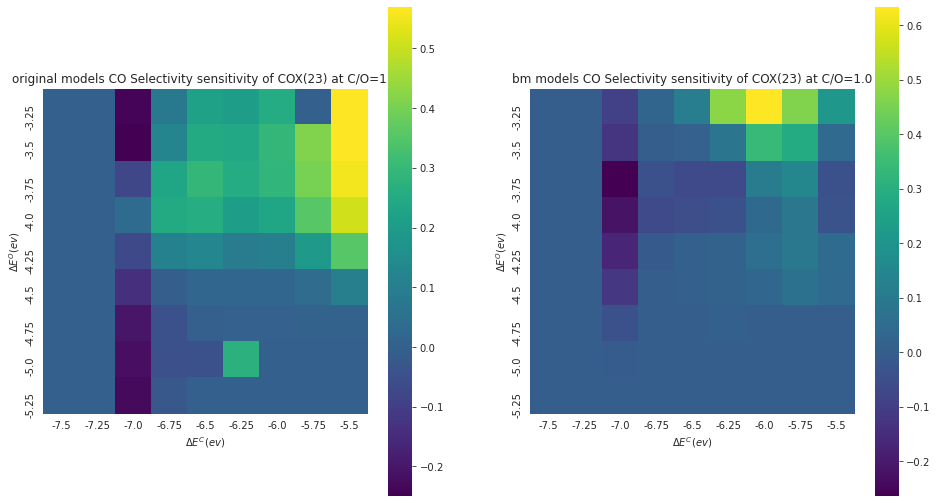

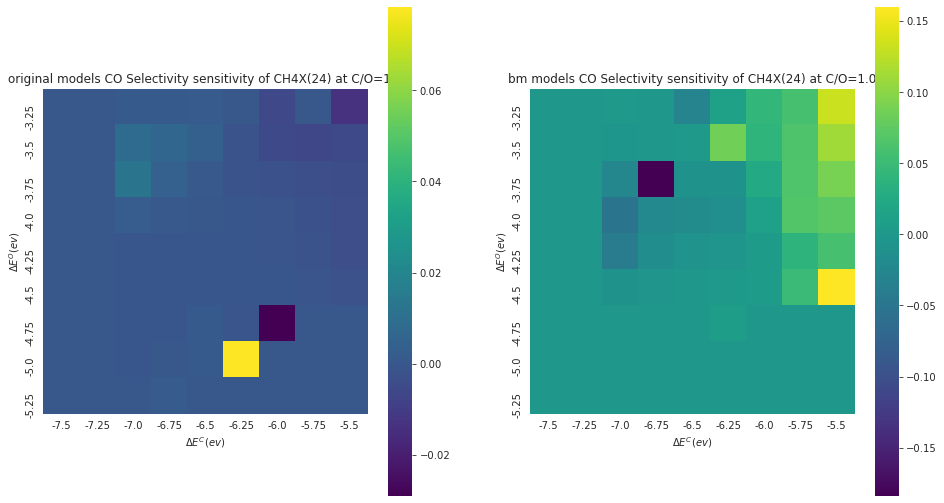

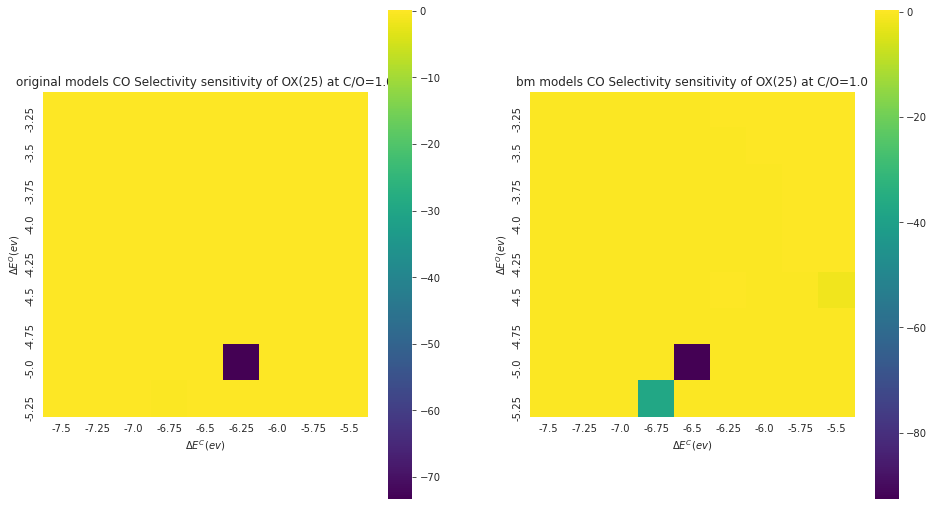

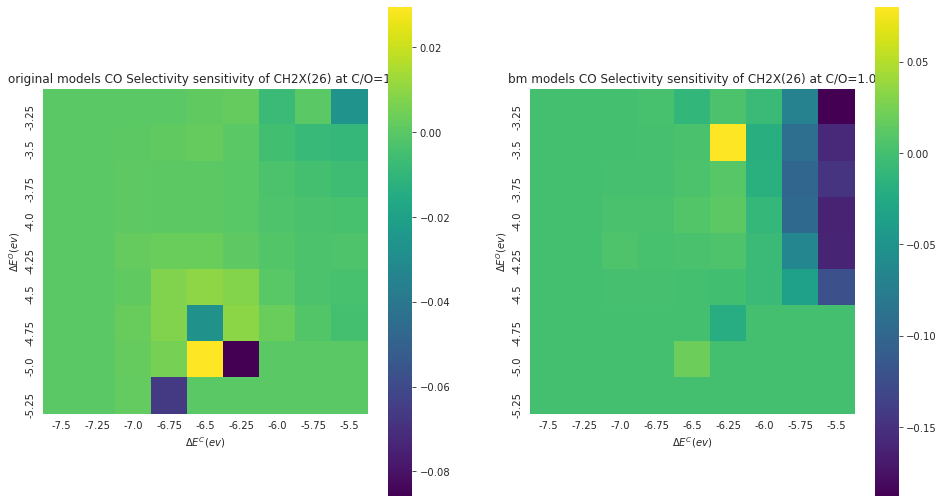

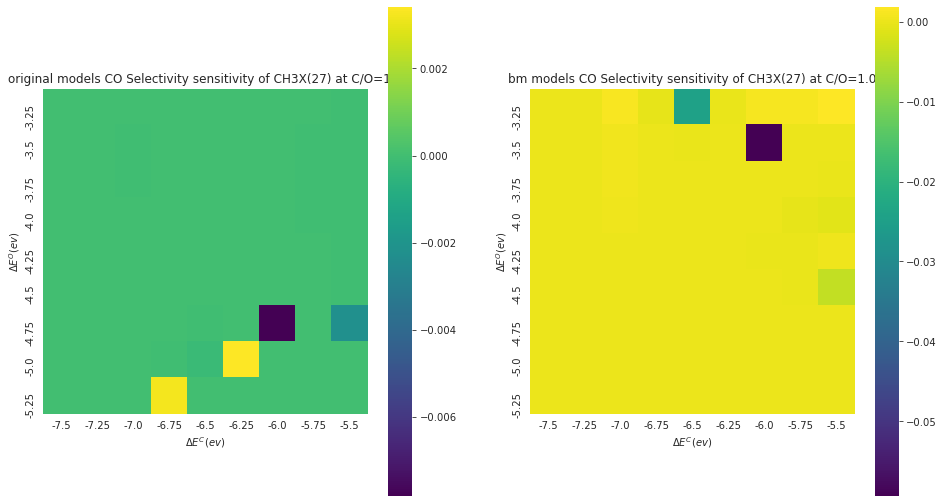

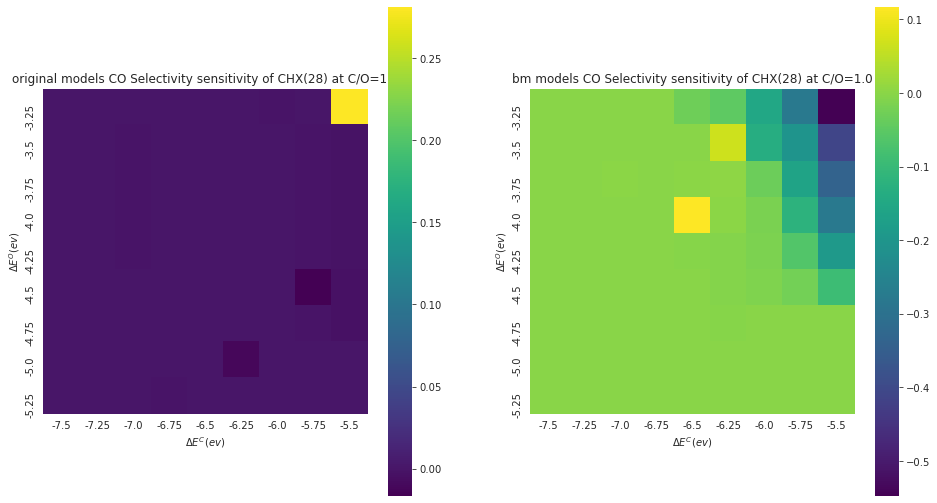

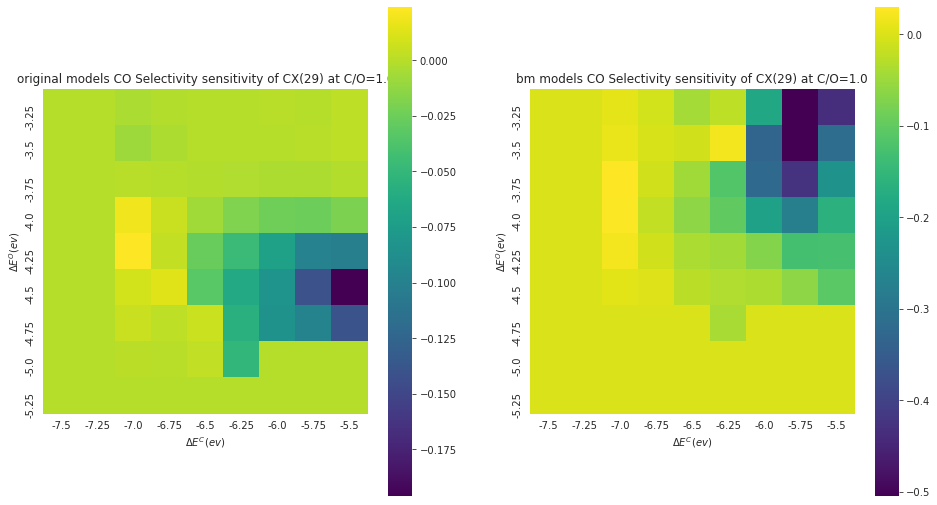

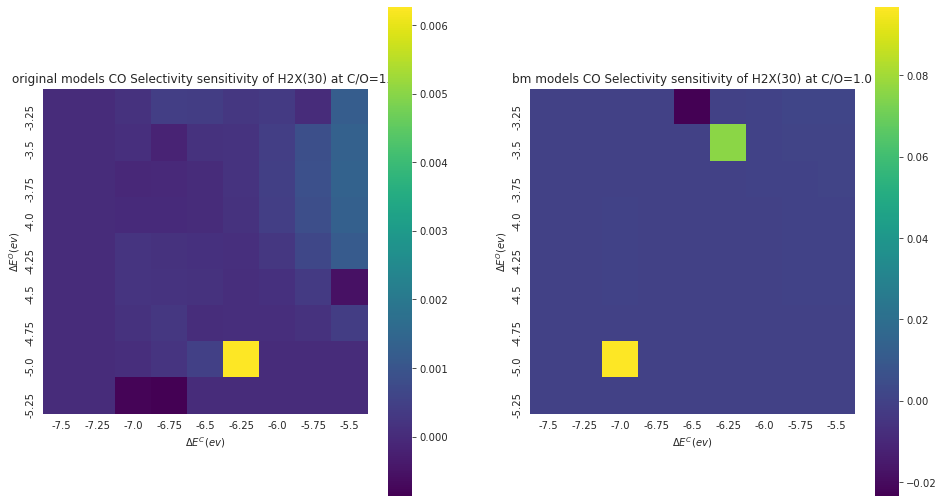

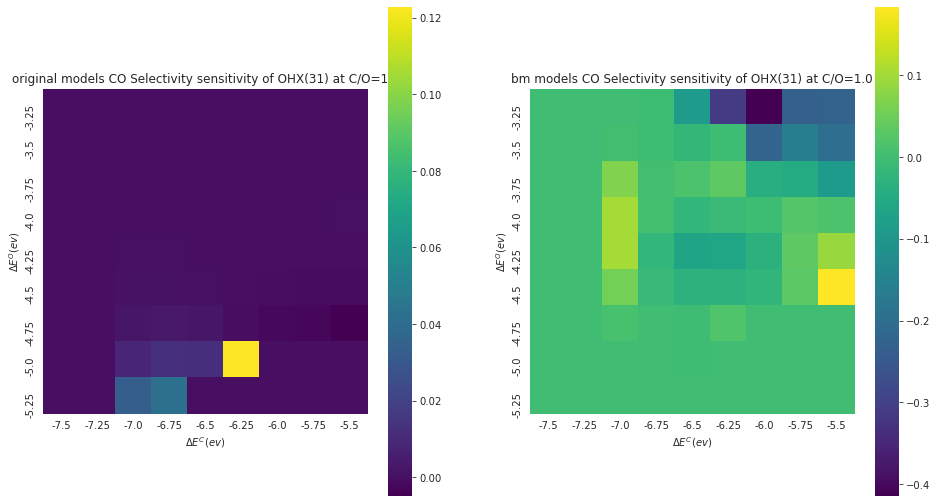

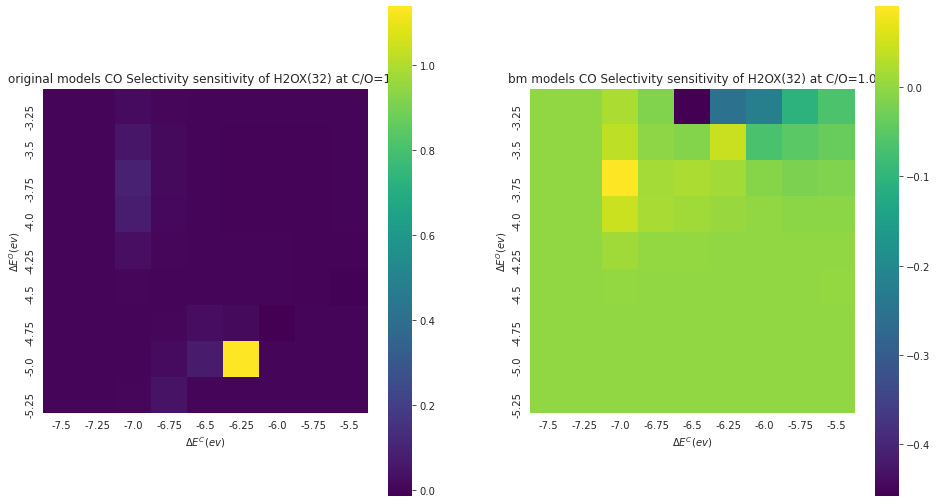

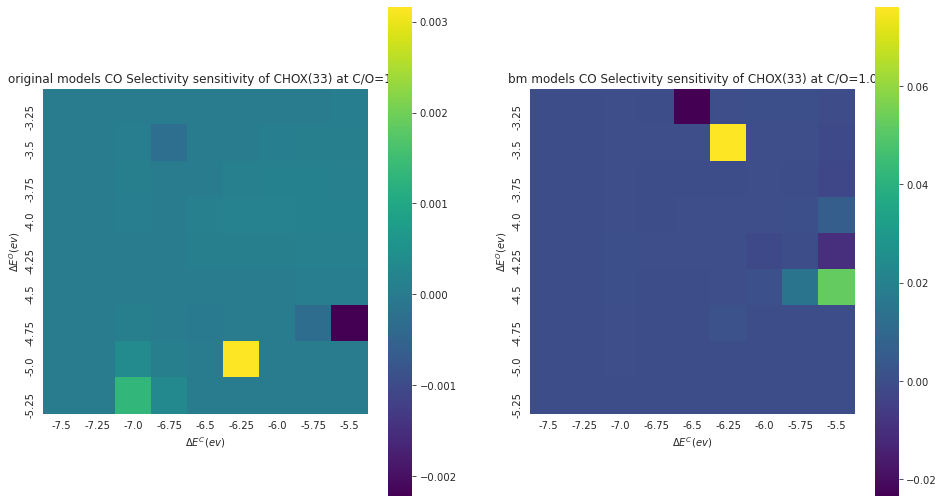

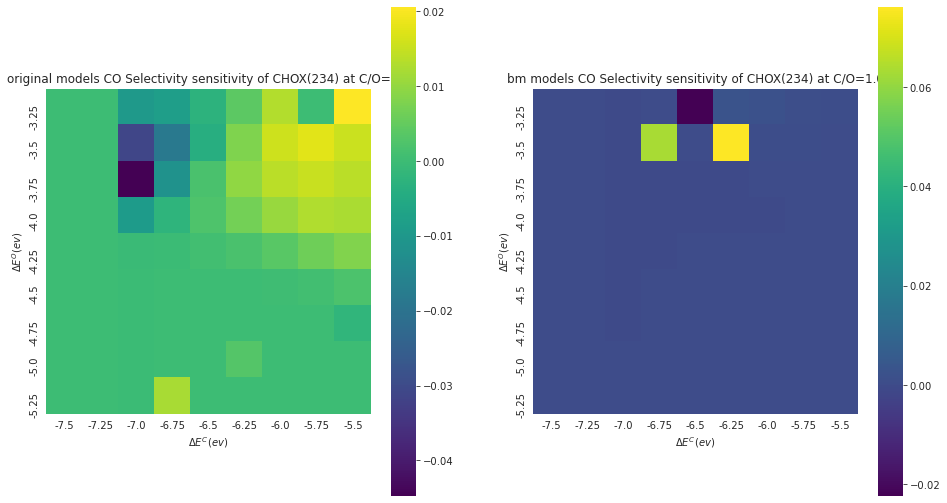

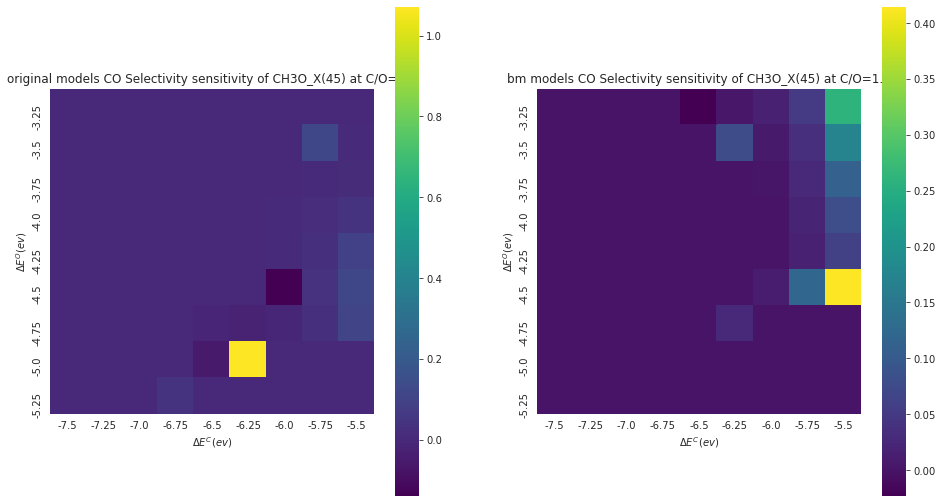

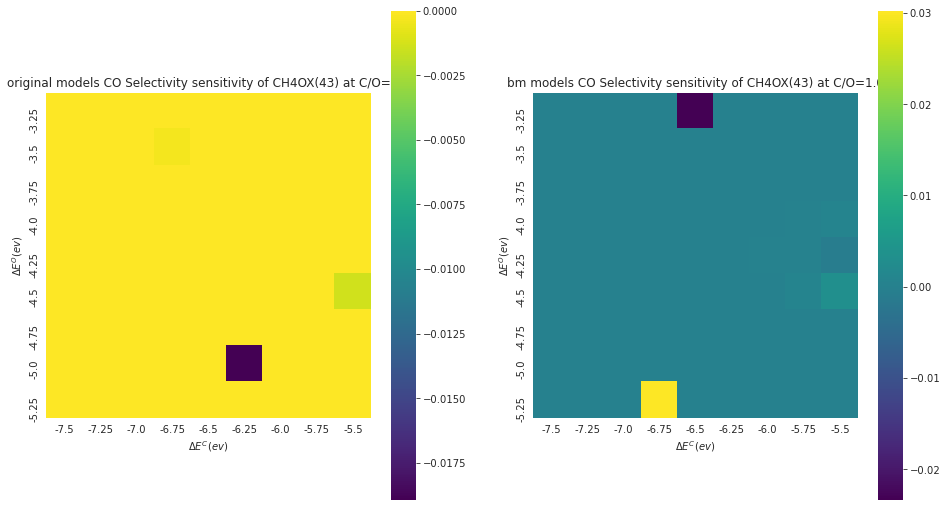

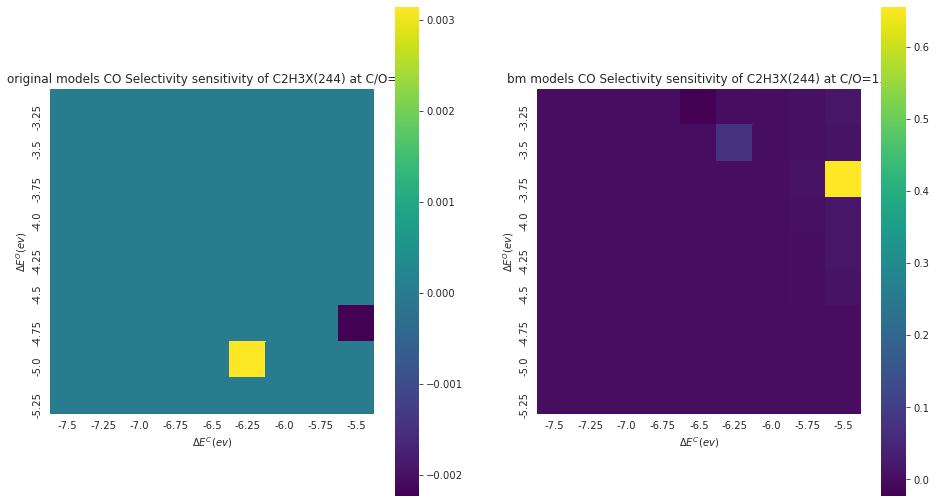

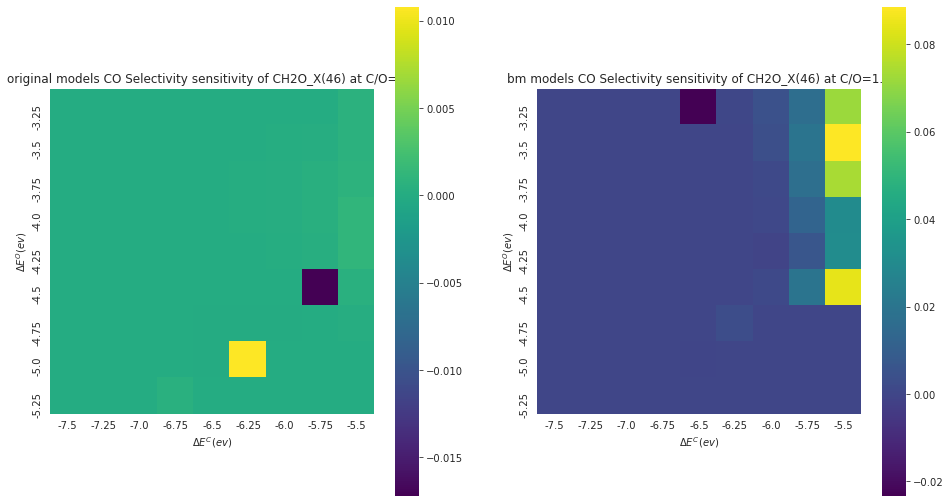

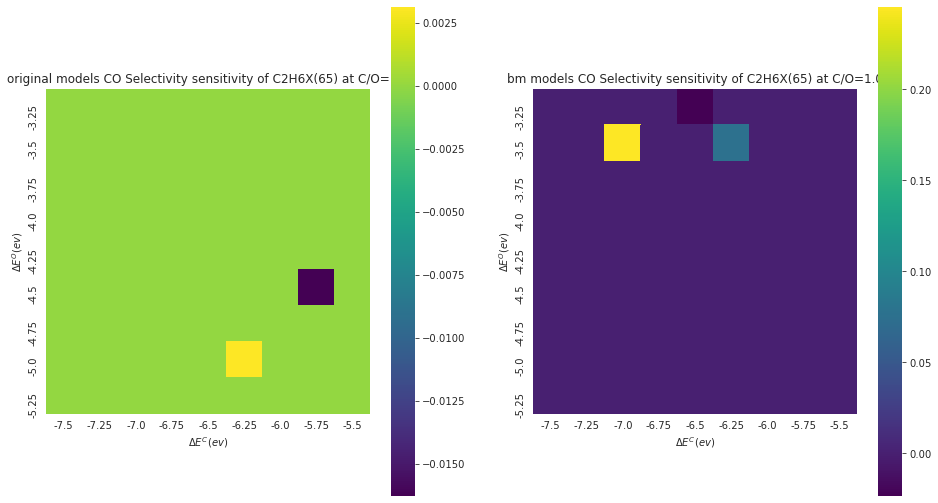

In [41]:
# CO Selectivity
for i in range(1, len(species)):
    heat_map_gen(i,4, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

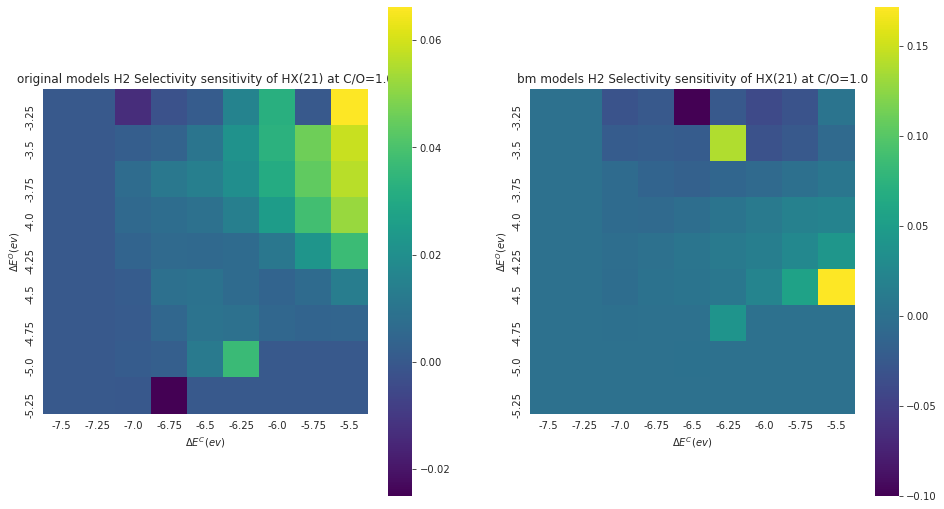

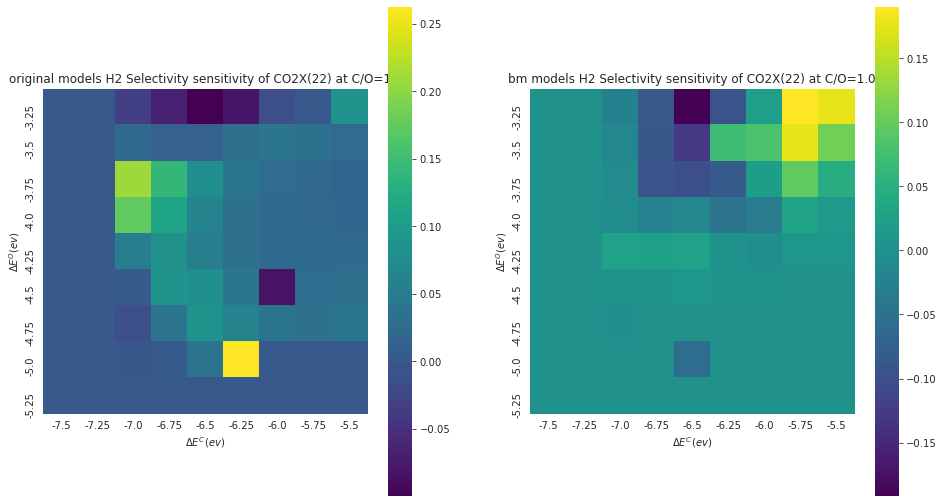

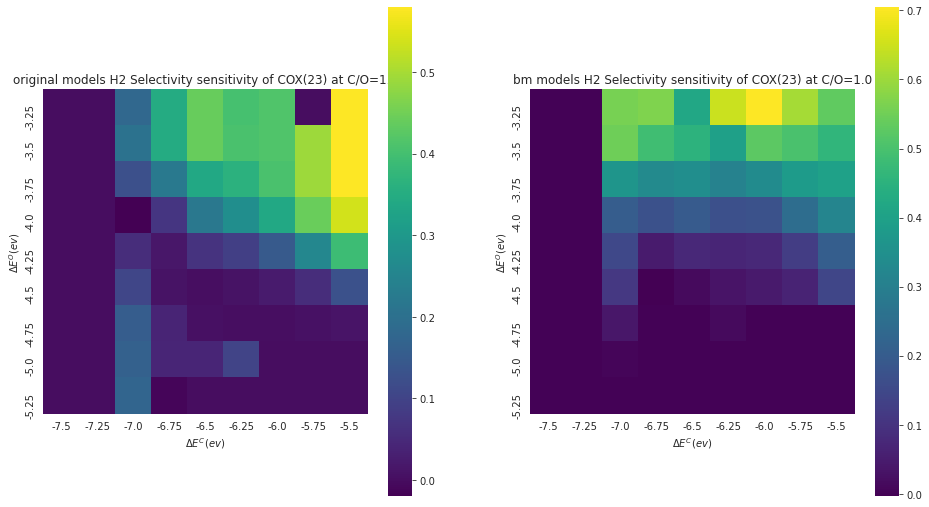

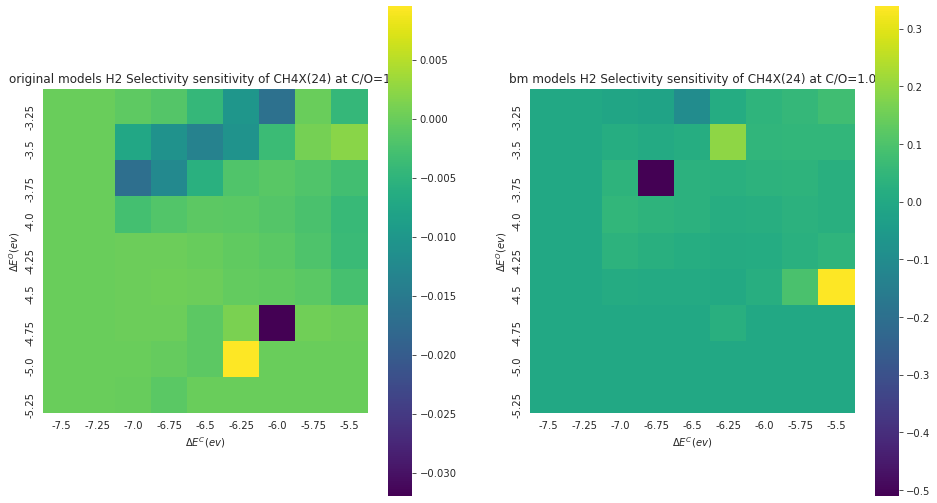

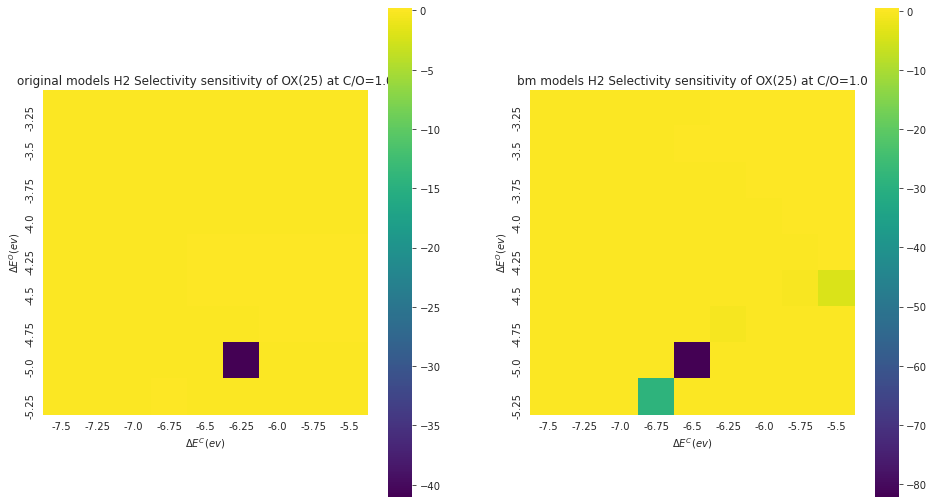

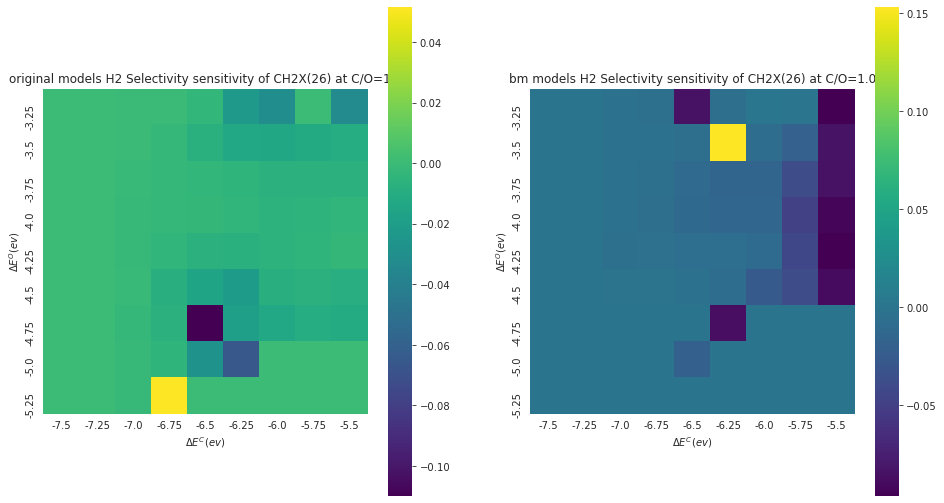

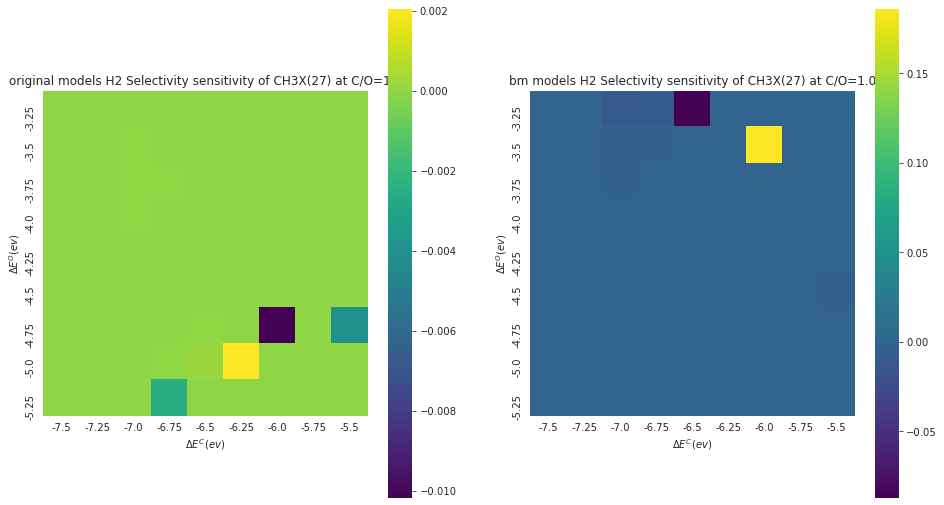

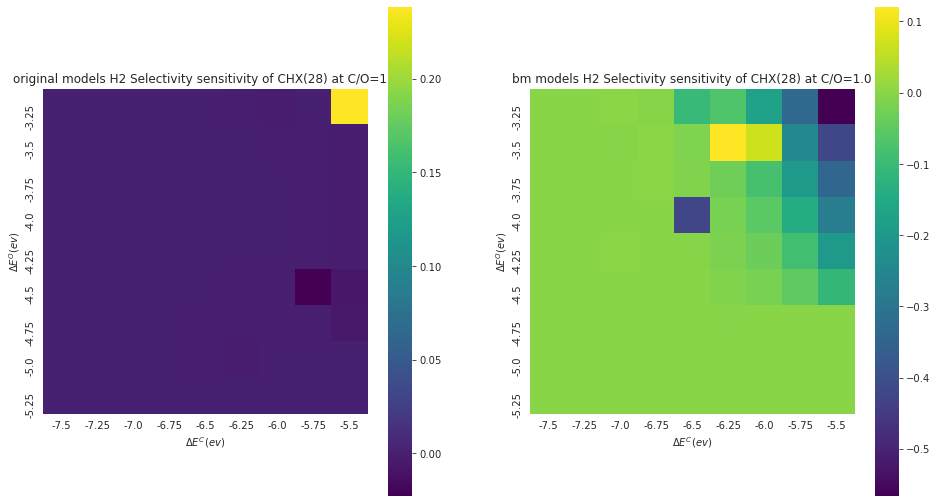

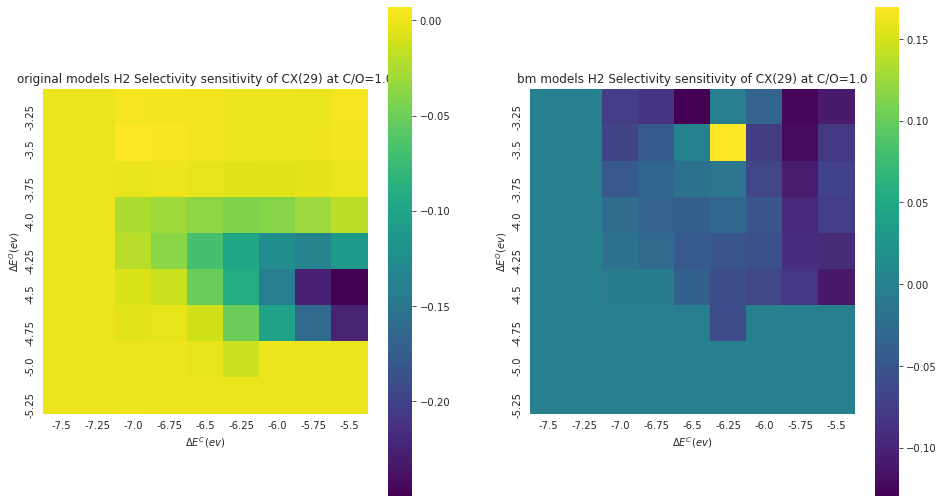

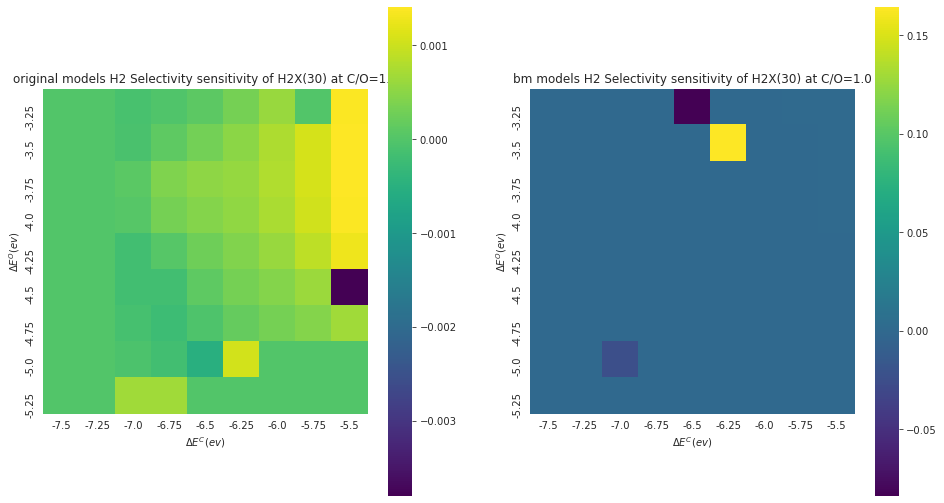

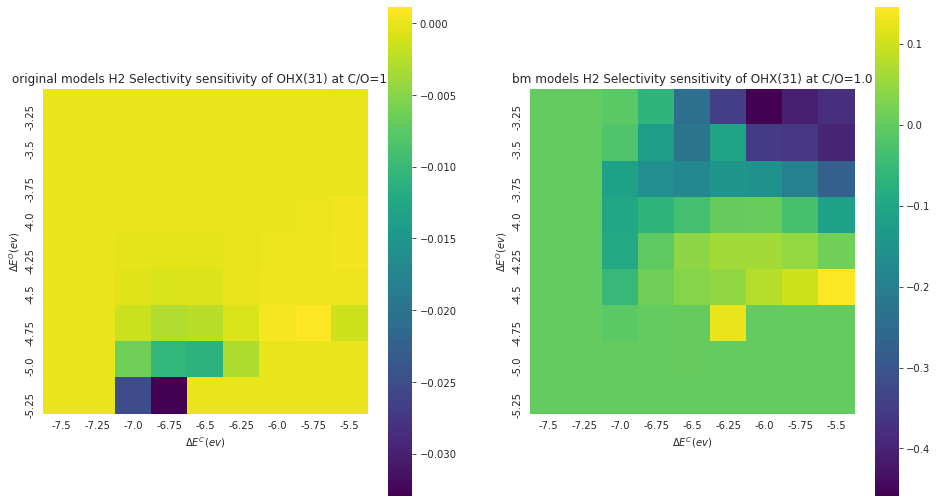

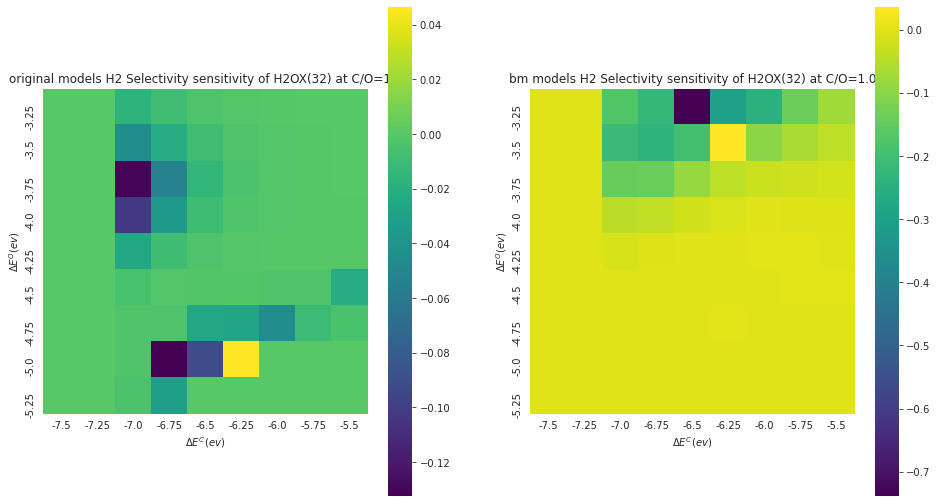

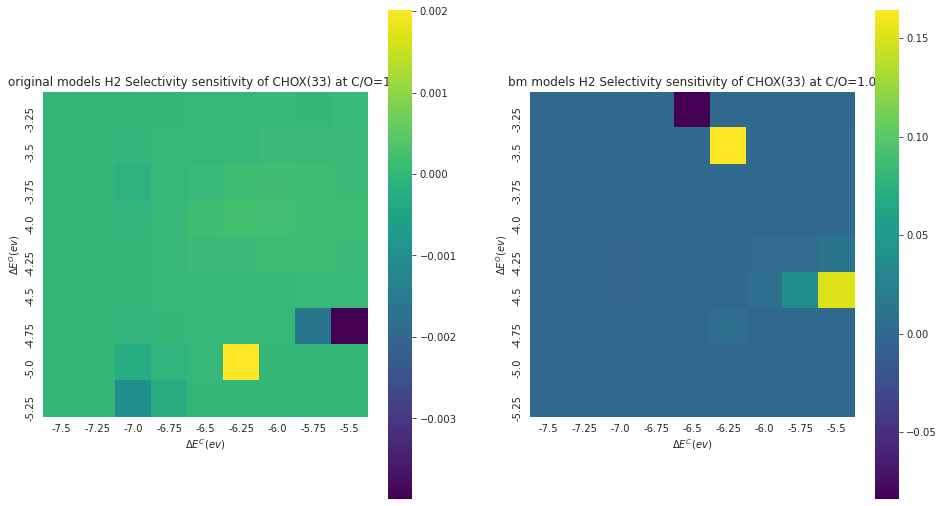

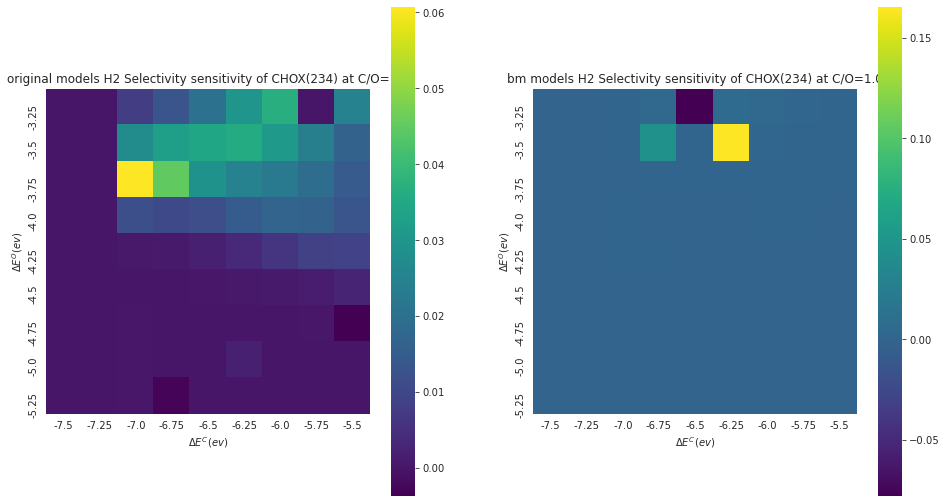

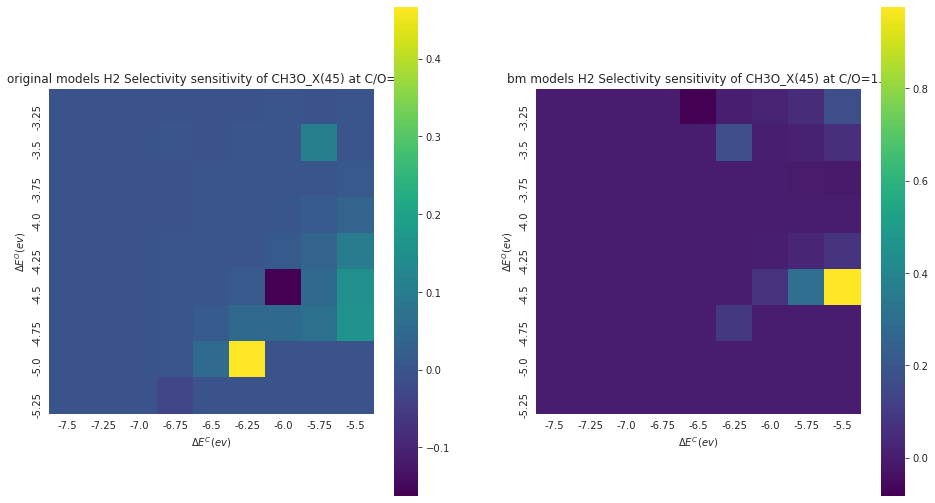

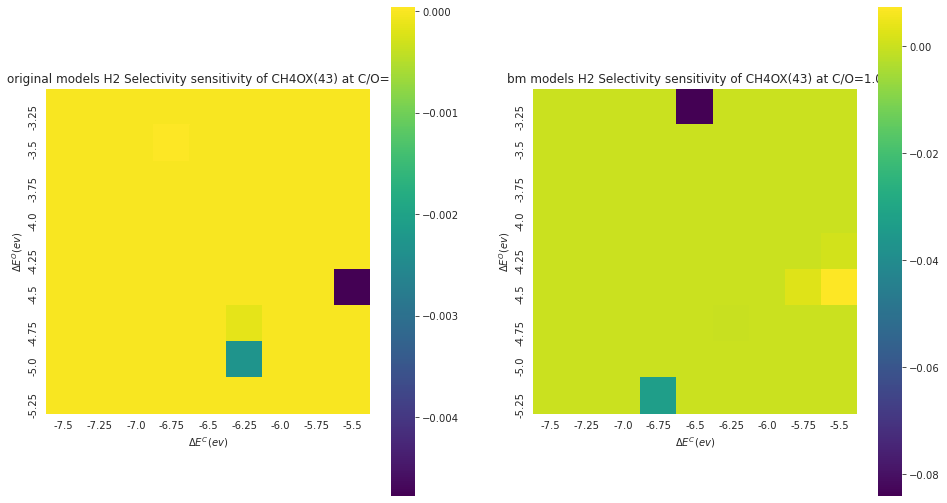

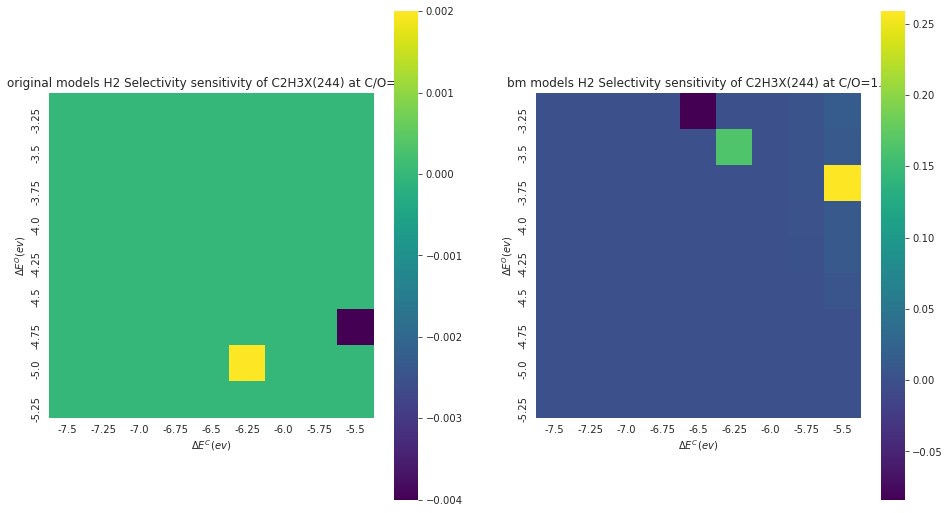

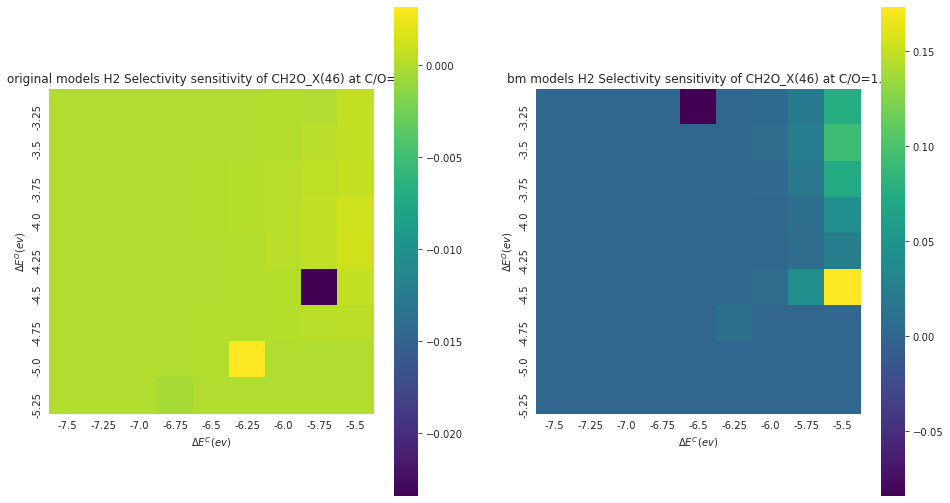

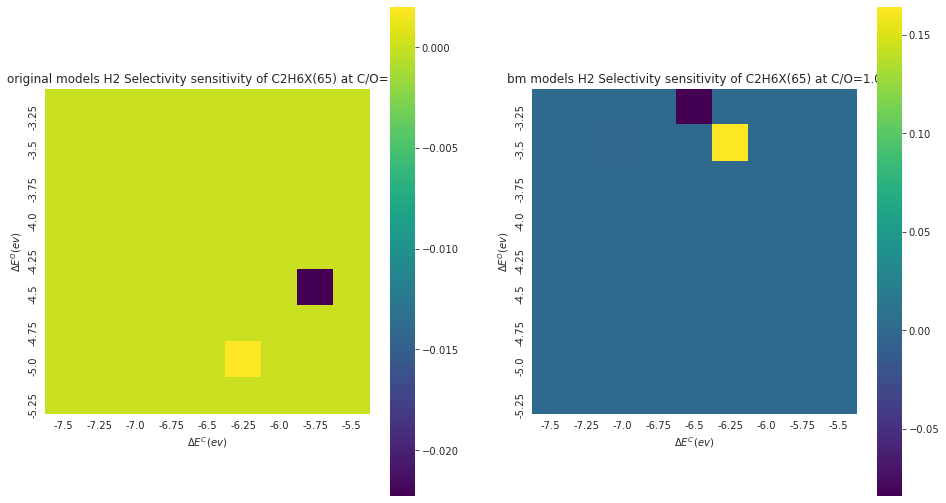

In [42]:
# H2 Selectivity
for i in range(1, len(species)):
    heat_map_gen(i,6, exceptions_original, exceptions_bm)

In [ ]:
['Unnamed: 0',
 'Species',
 'SYNGAS Selec',
 'SYNGAS Yield',
 'CO Selectivity',
 'CO % Yield',
 'H2 Selectivity',
 'H2 % Yield',
 'CH4 Conversion',
 'H2O+CO2 Selectivity',
 'H2O+CO2 yield',
 'Exit Temp',
 'Peak Temp',
 'Dist to peak temp',
 'O2 Conversion',
 'Max CH4 Conv',
 'Dist to 50 CH4 Conv']

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

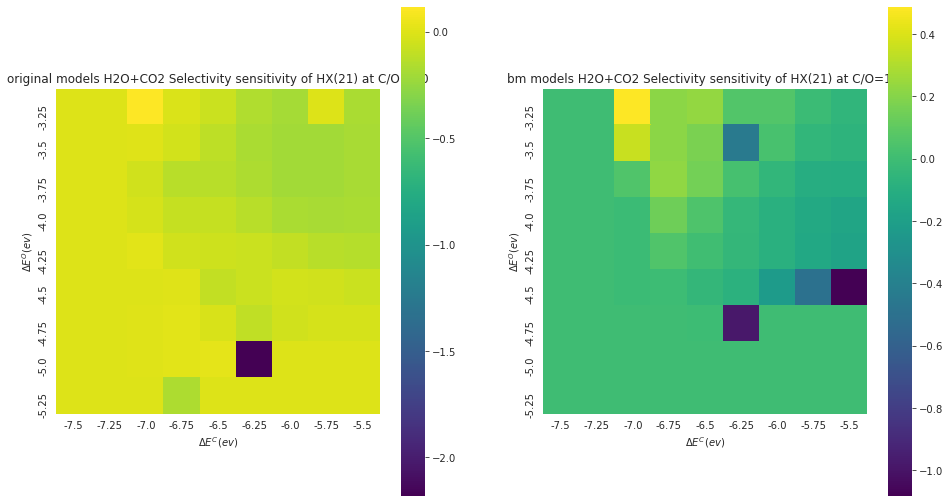

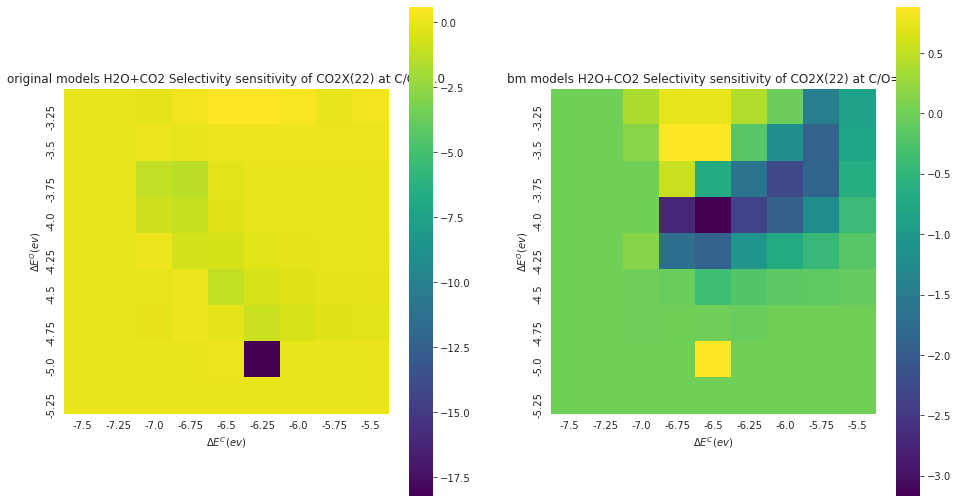

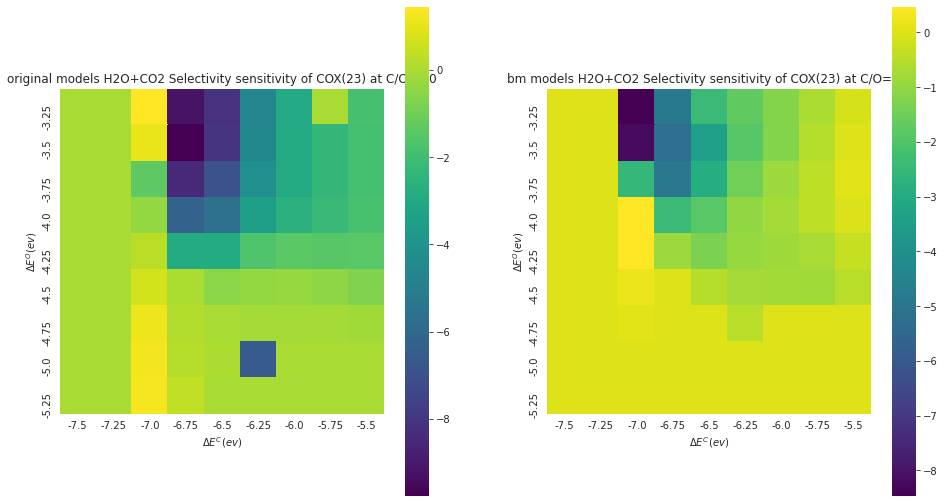

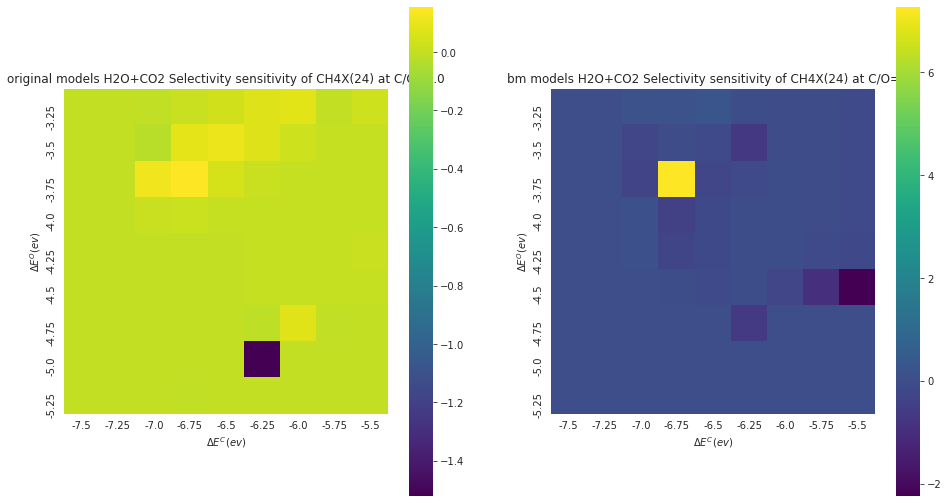

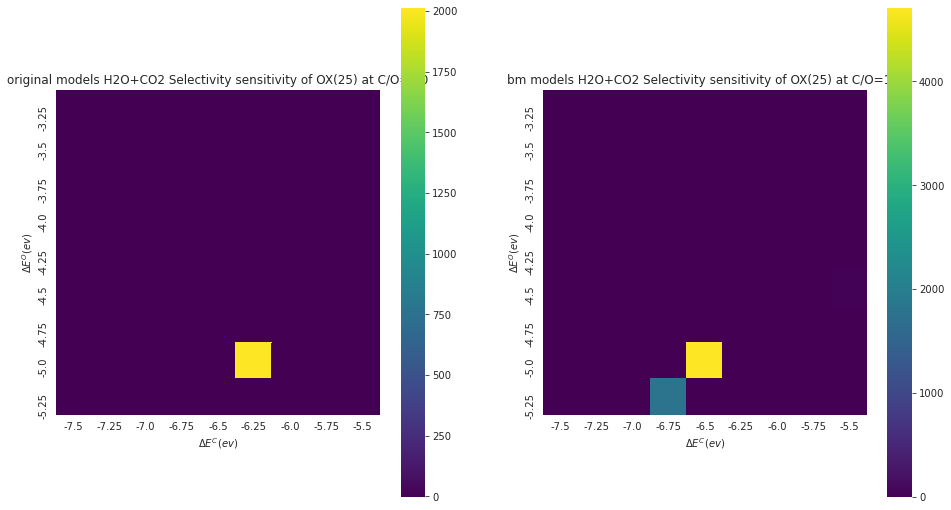

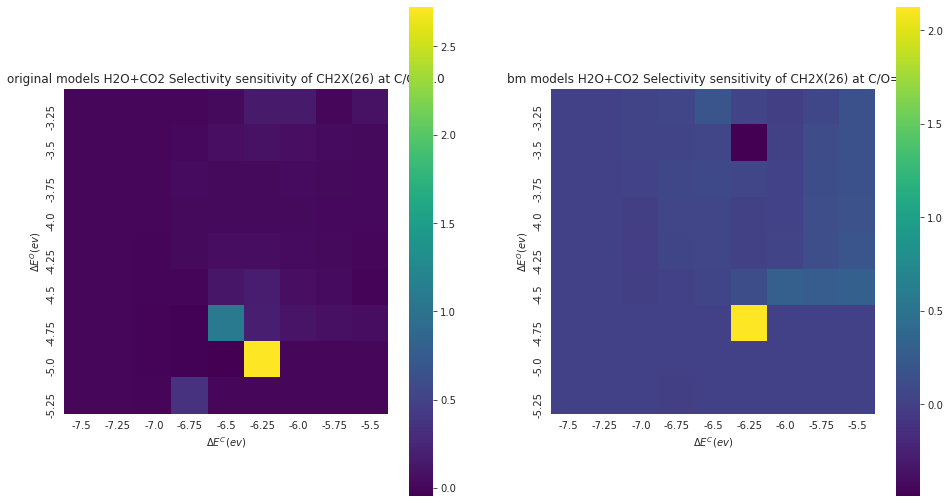

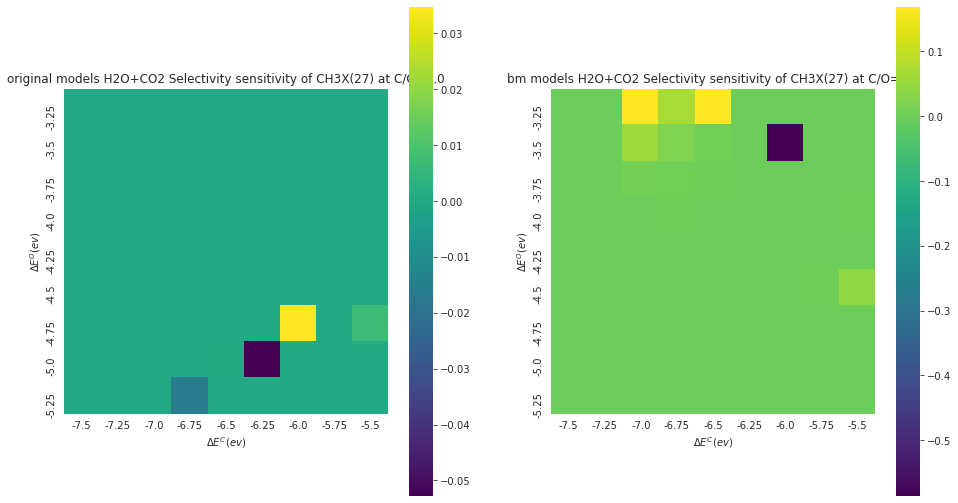

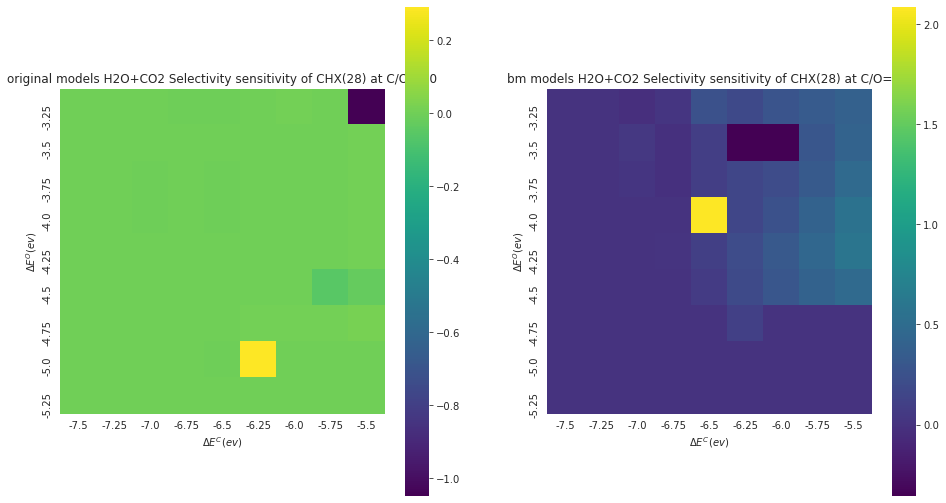

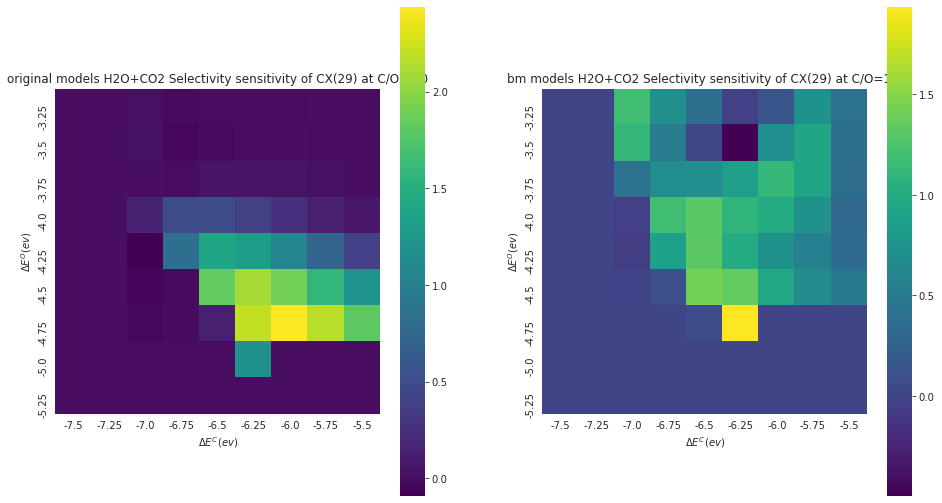

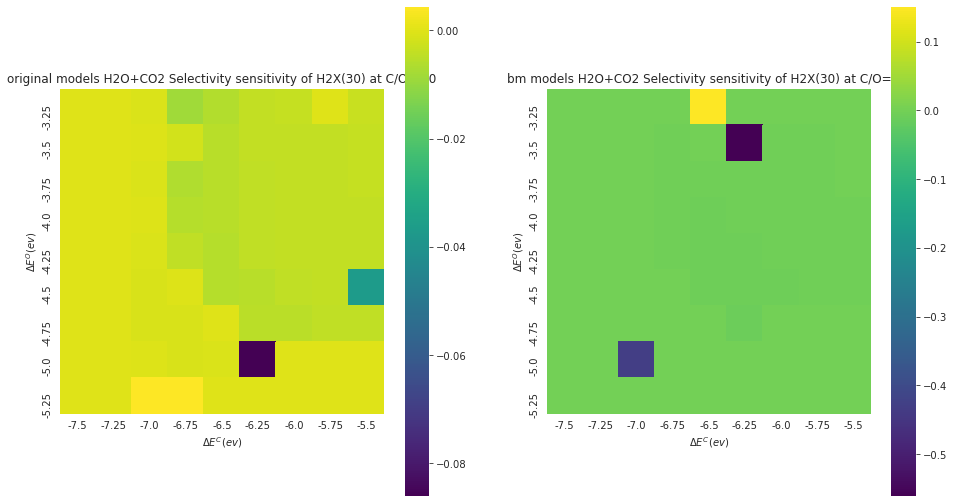

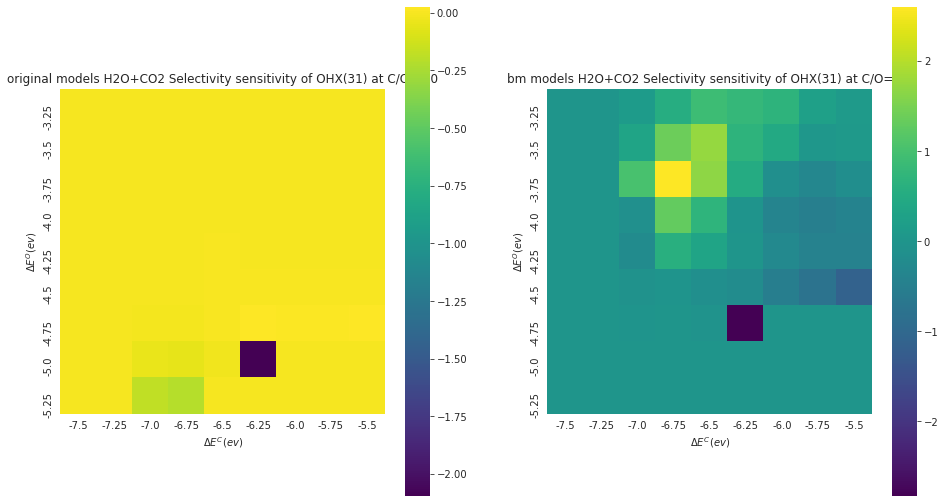

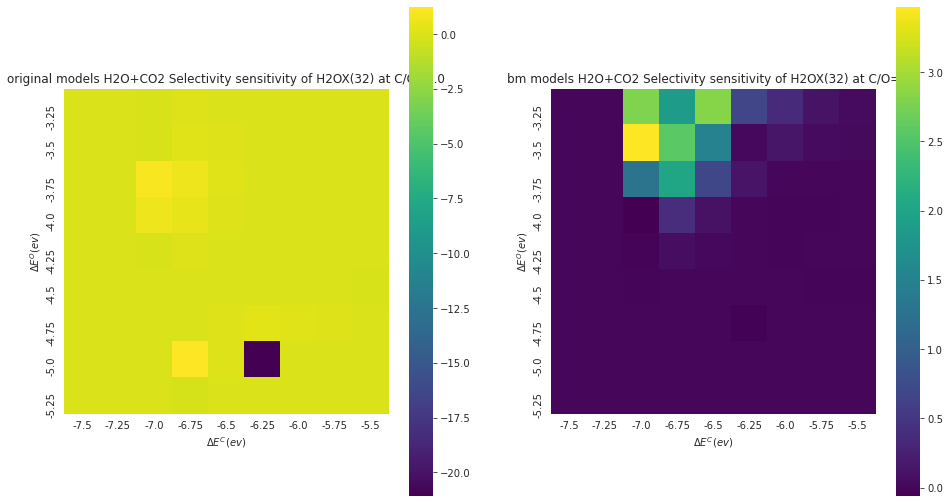

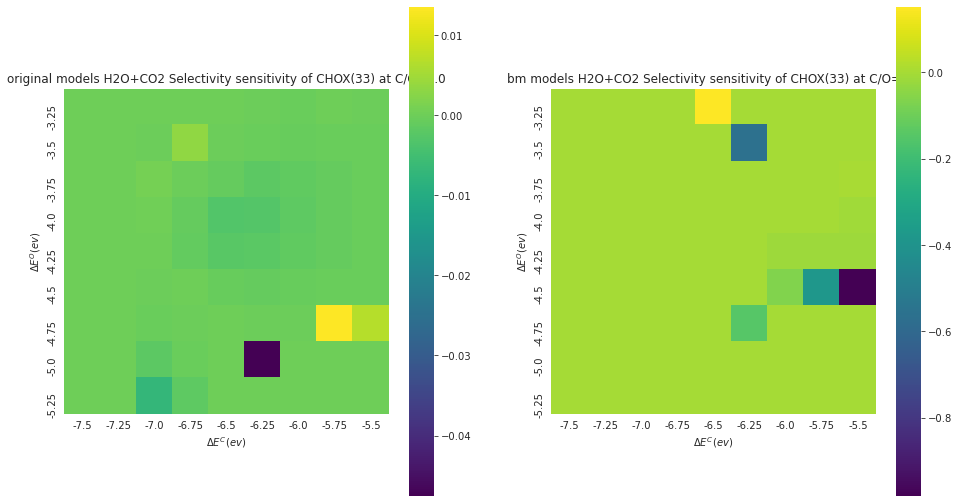

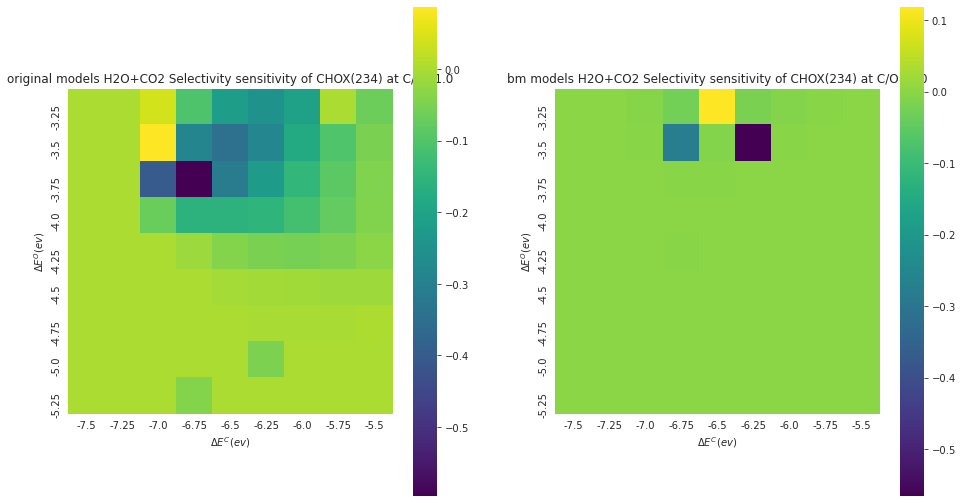

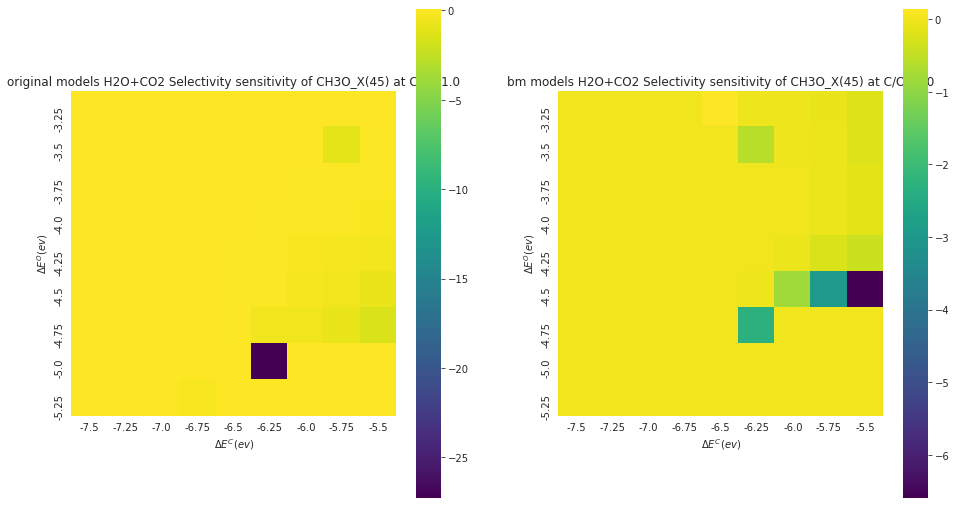

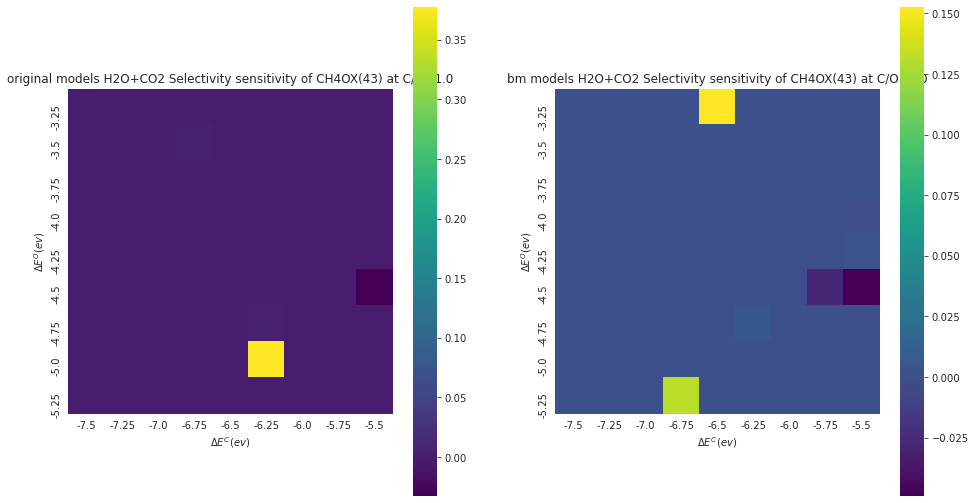

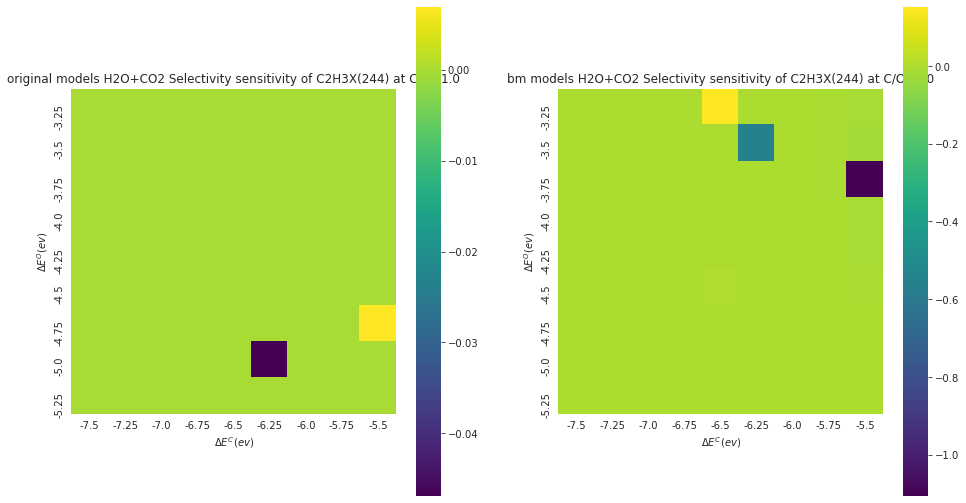

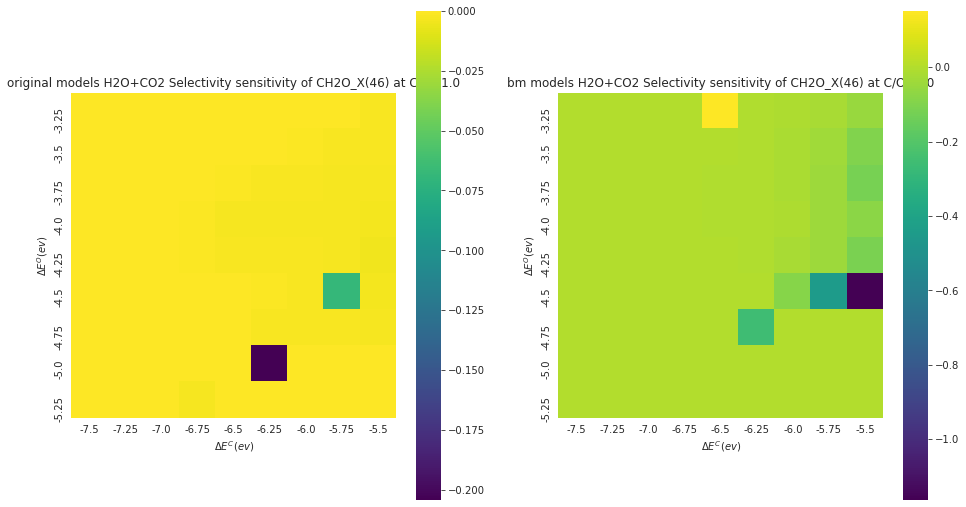

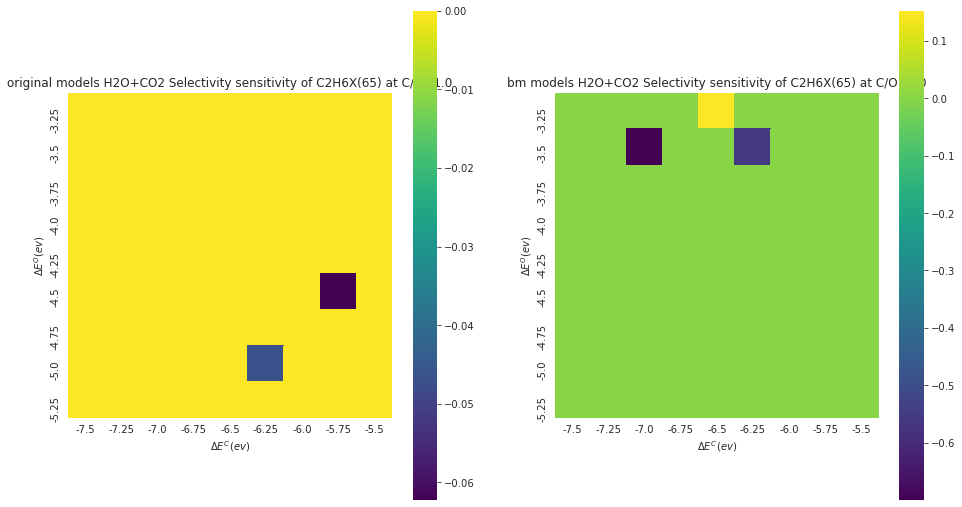

In [47]:
# H2O+CO2 Selectivity
for i in range(1, len(species)):
    heat_map_gen(i,9, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

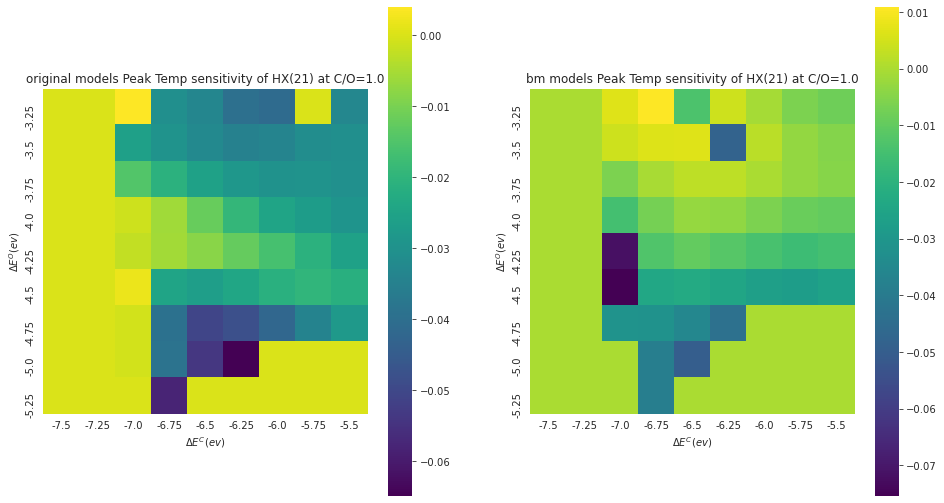

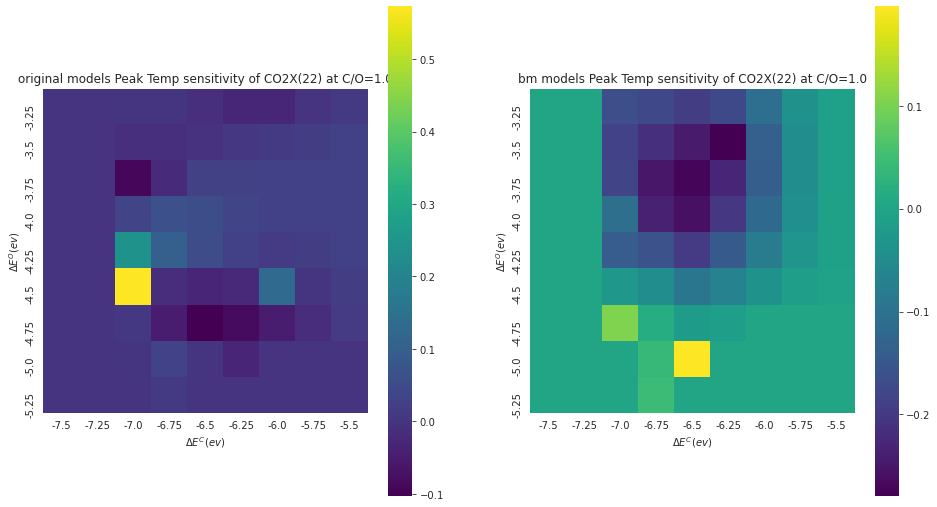

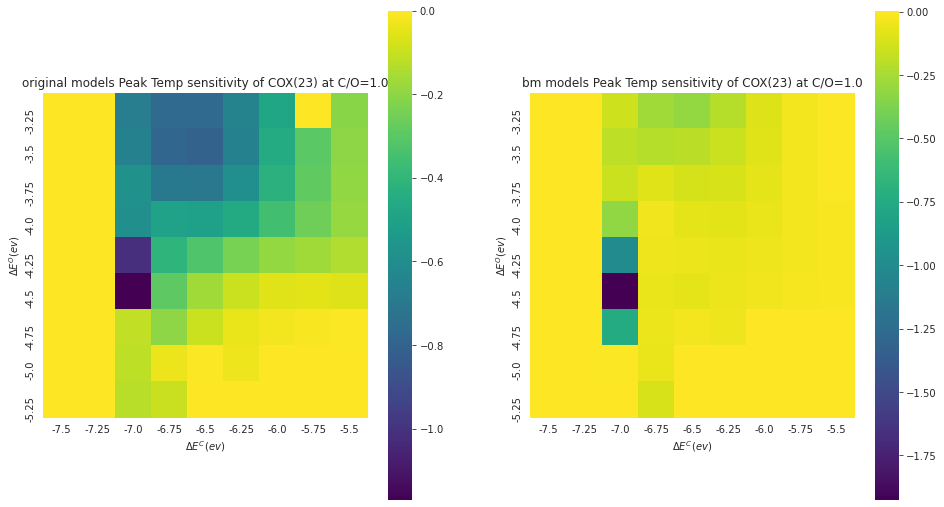

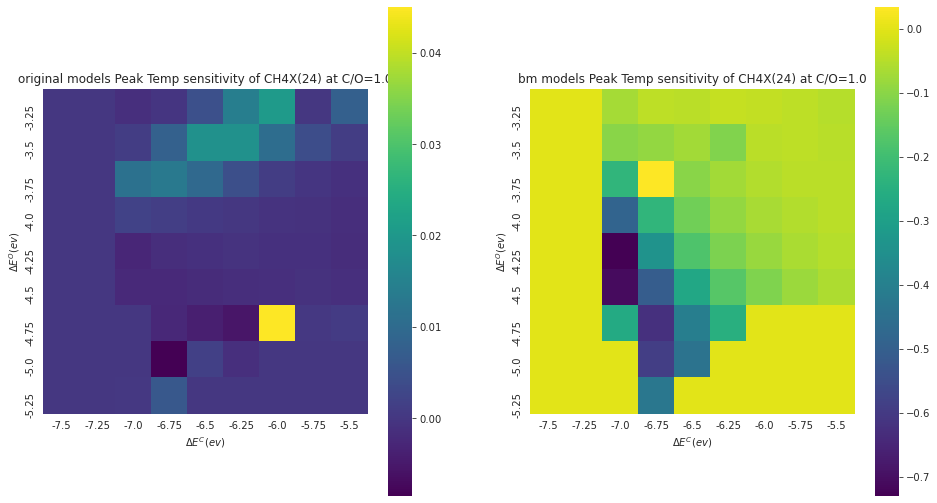

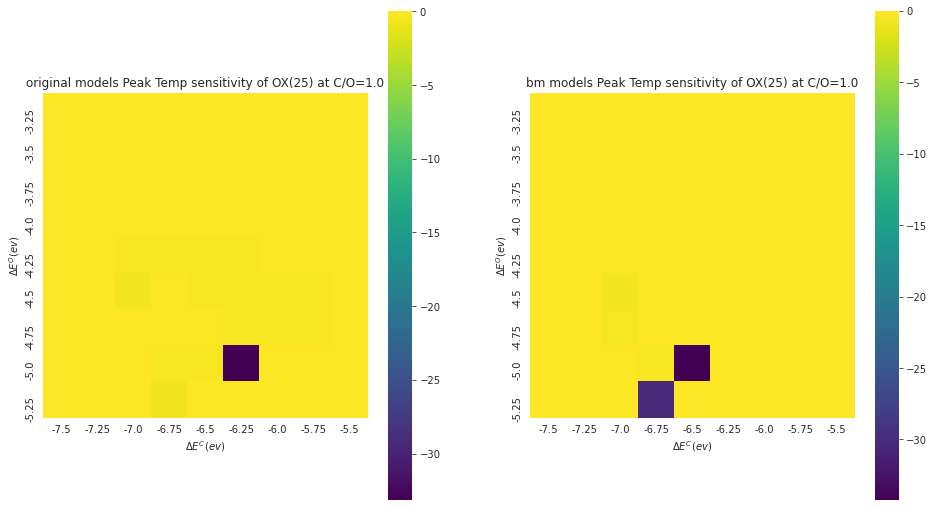

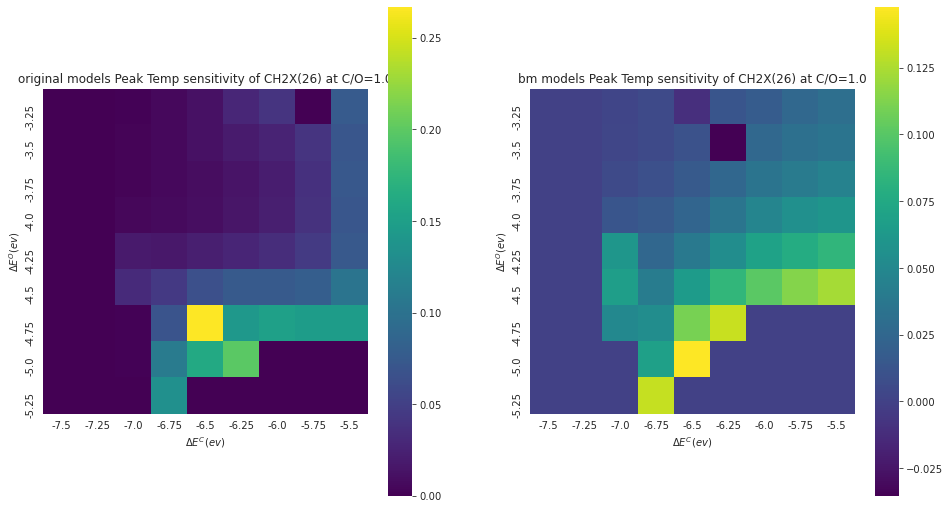

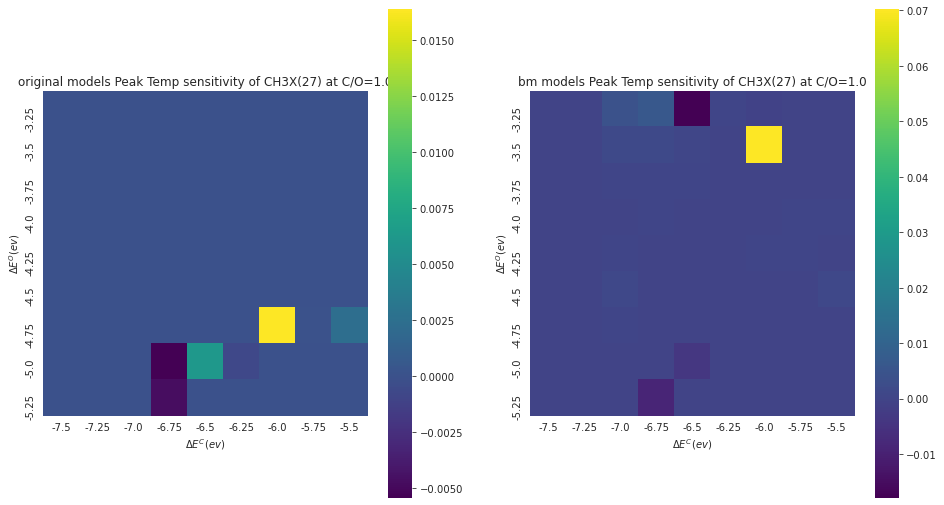

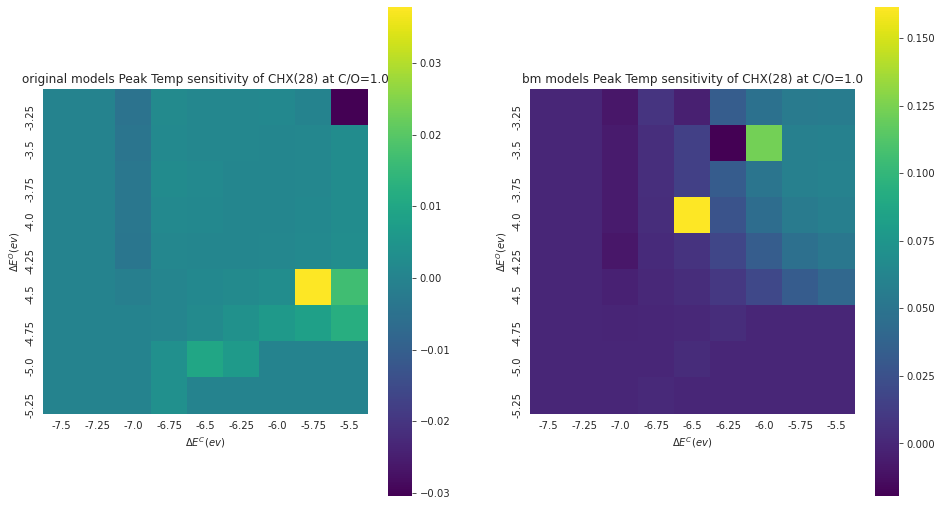

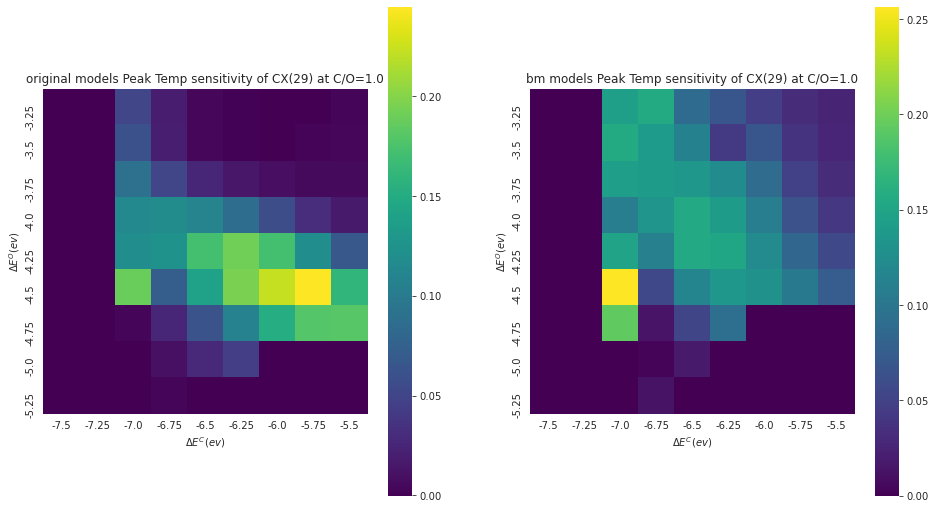

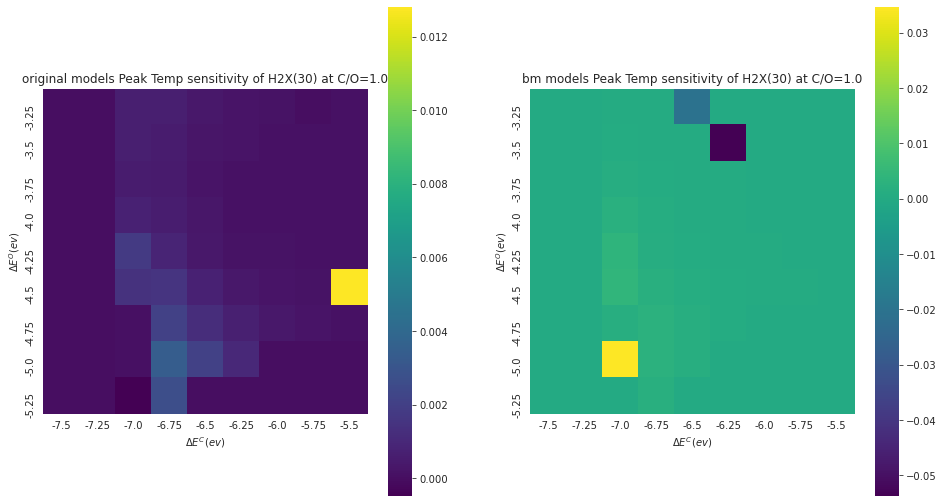

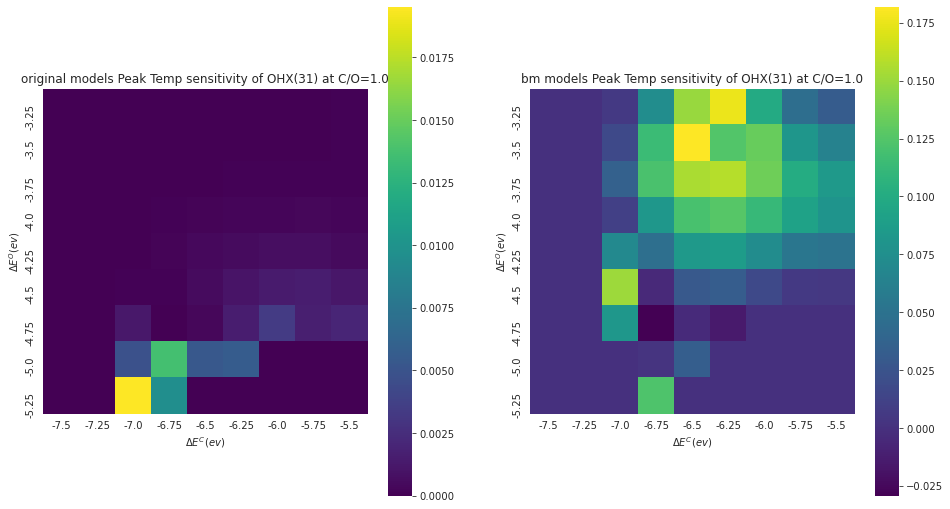

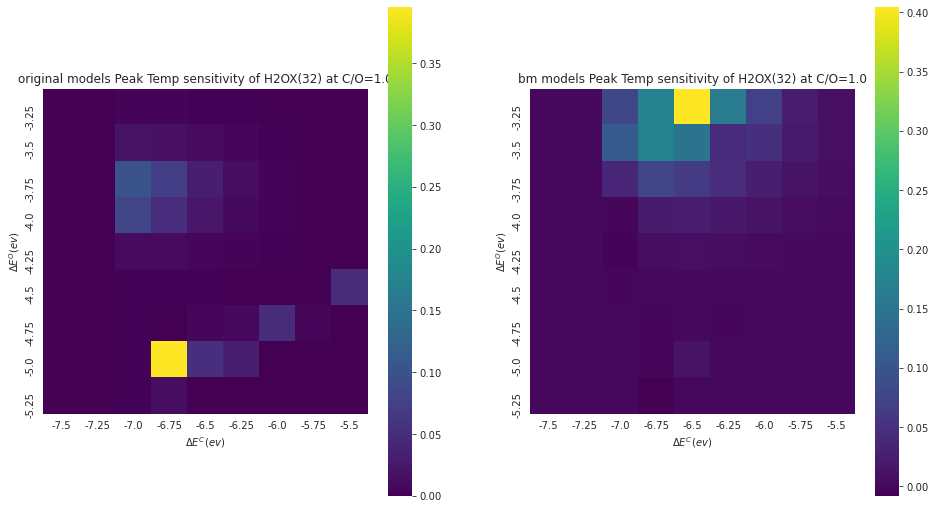

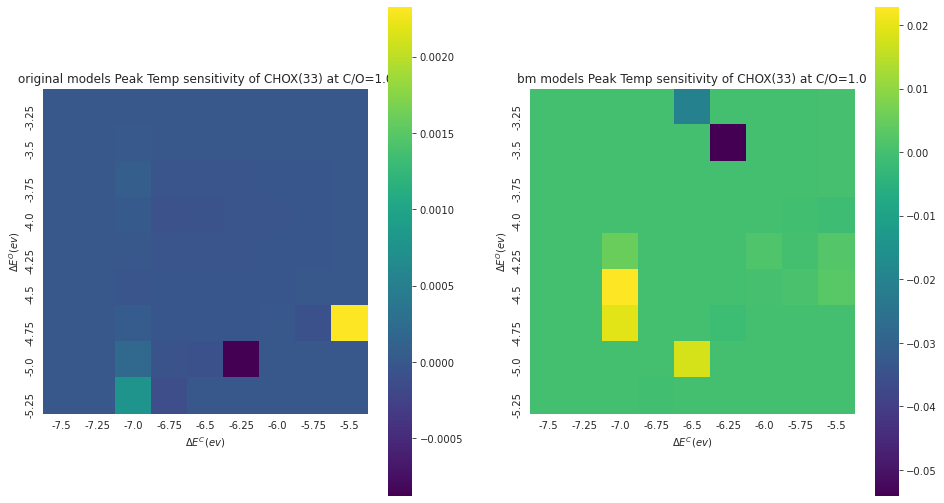

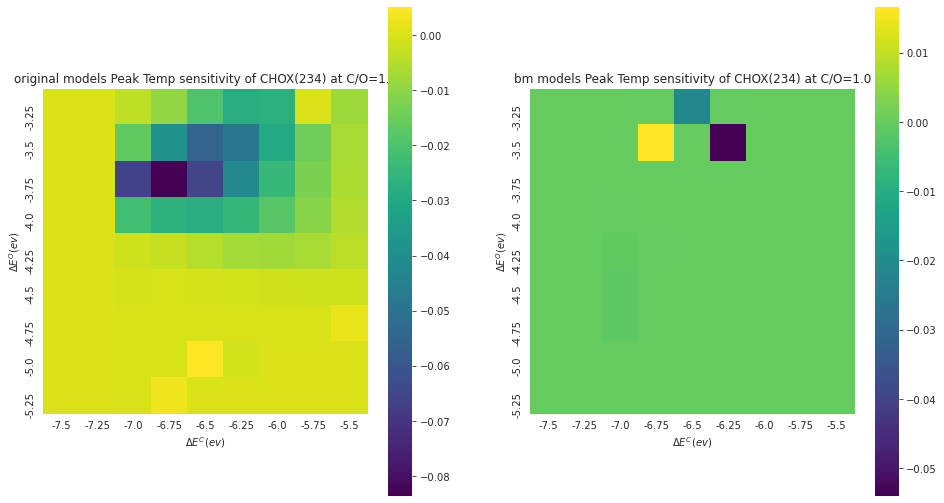

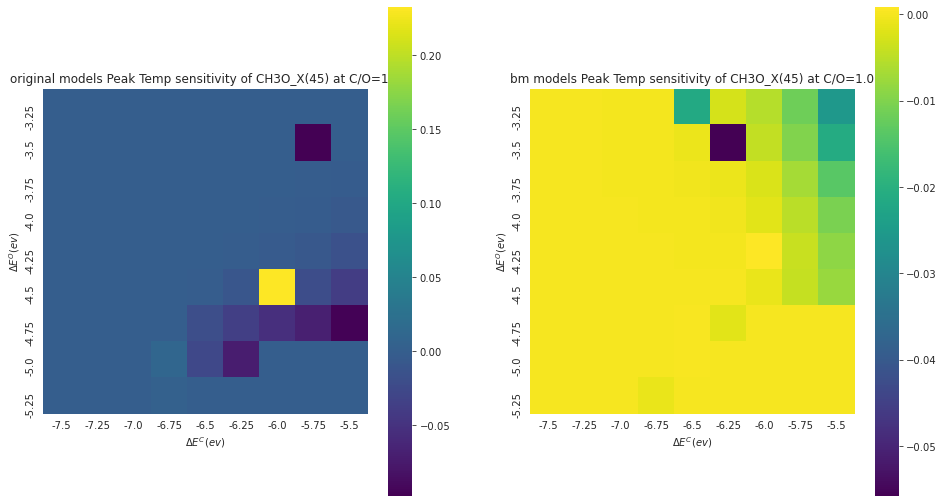

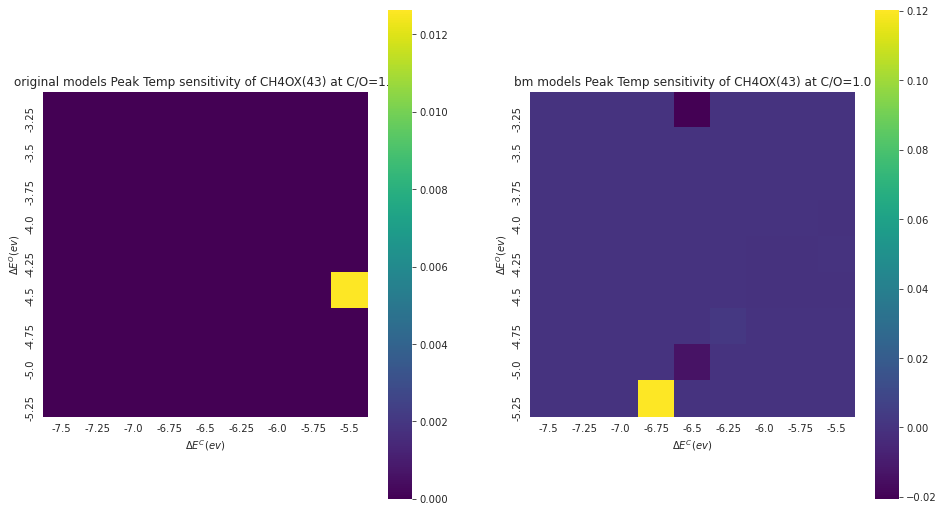

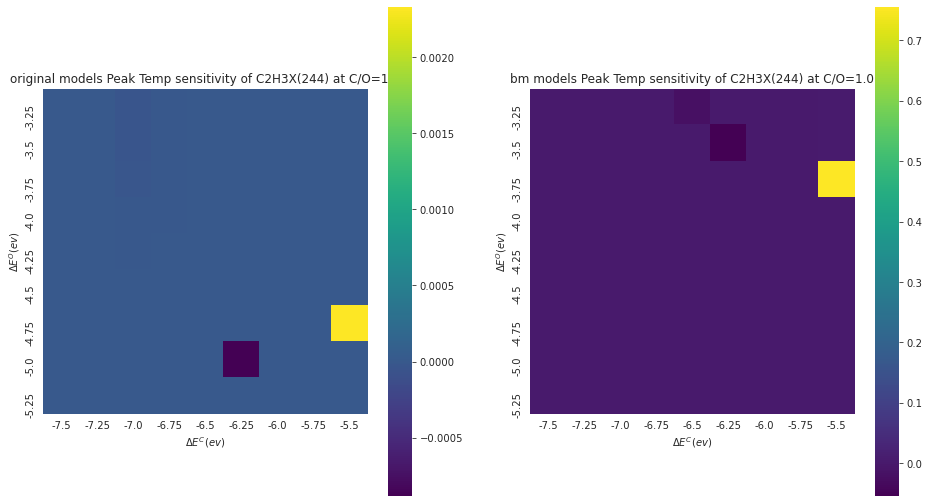

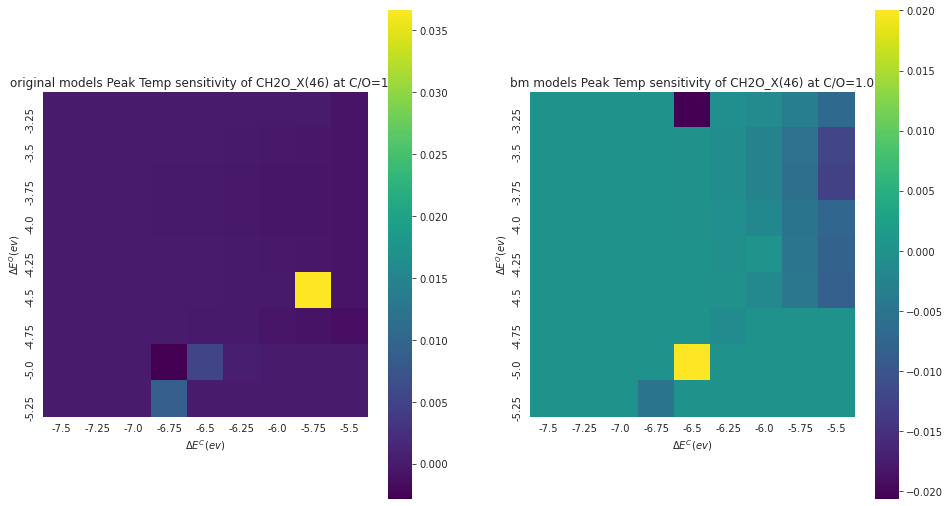

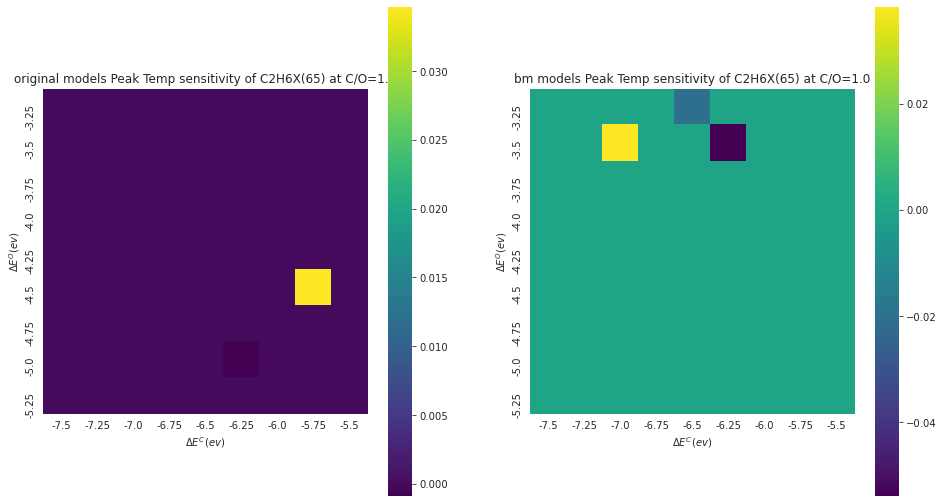

In [49]:
# Peak Temp 
for i in range(1, len(species)):
    heat_map_gen(i,12, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

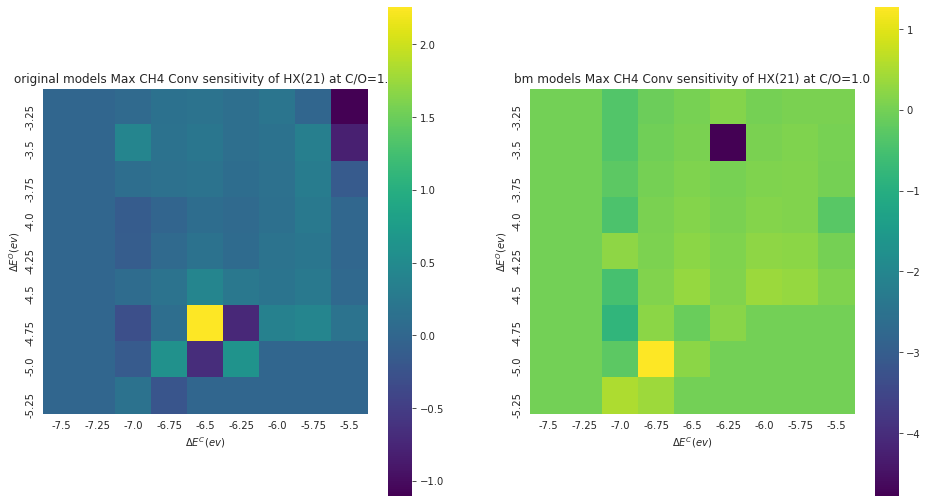

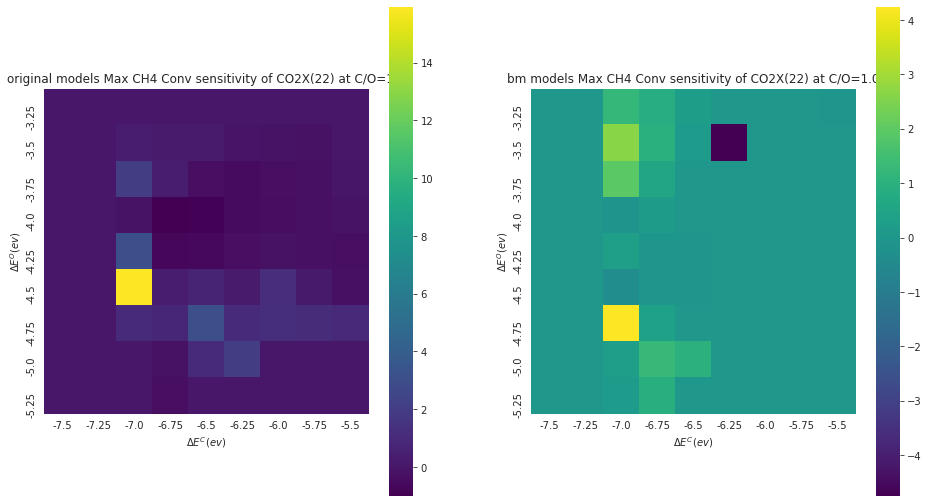

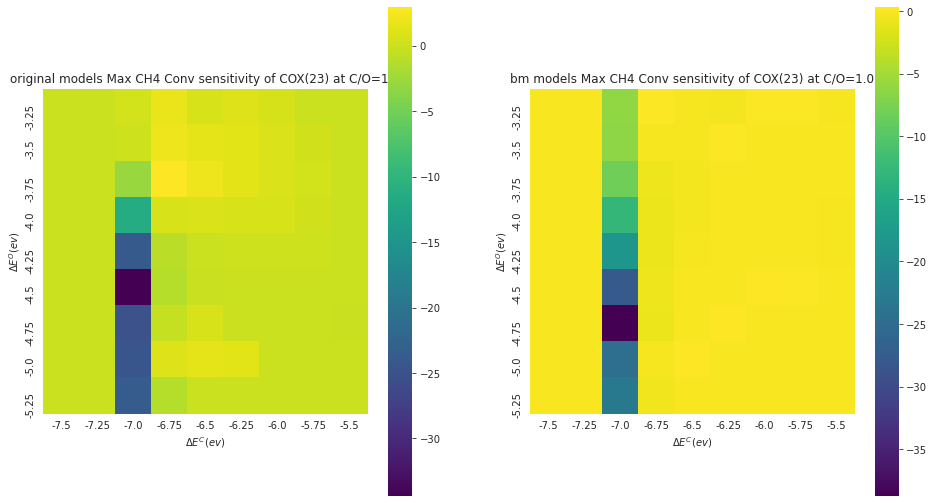

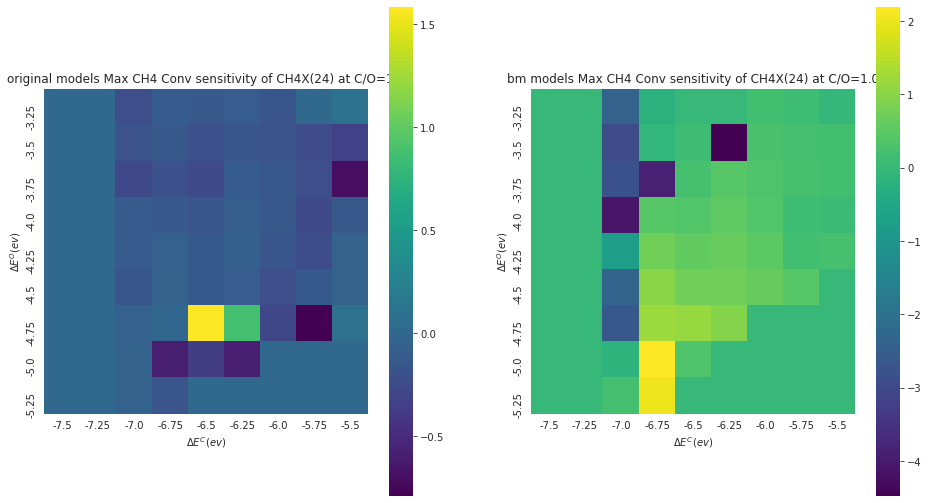

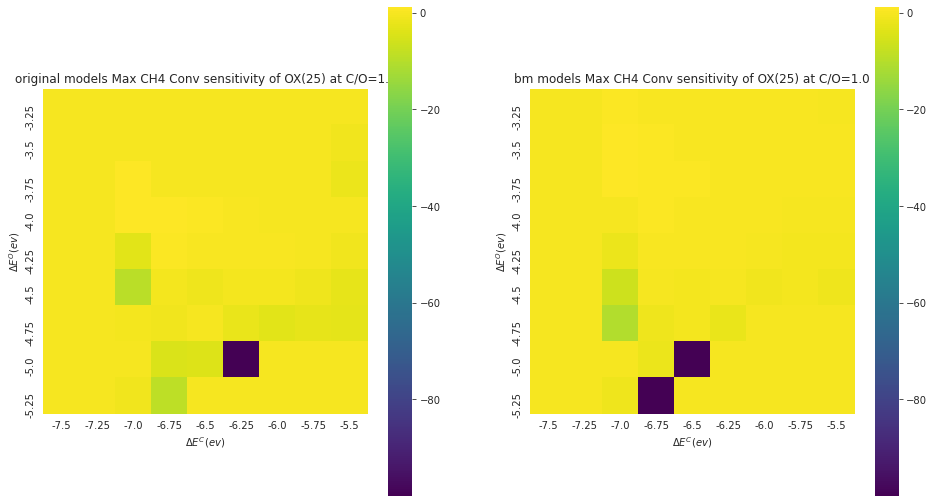

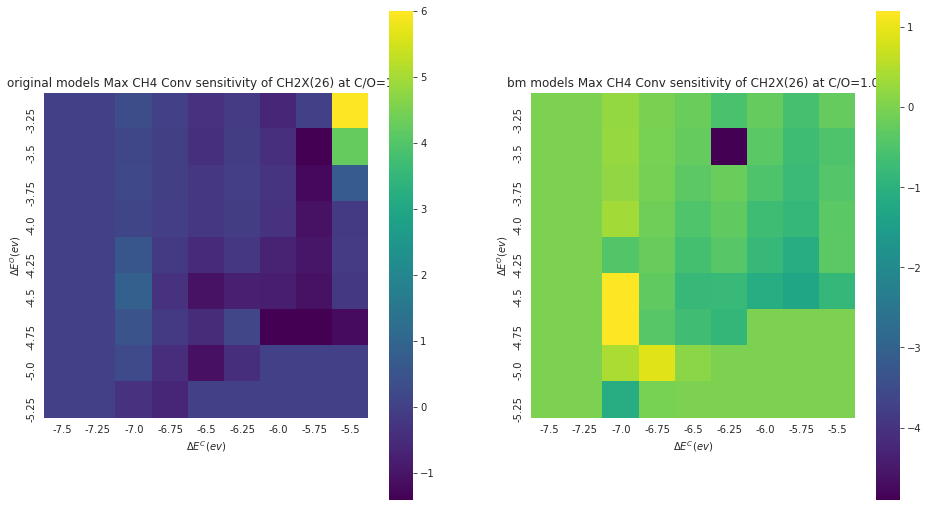

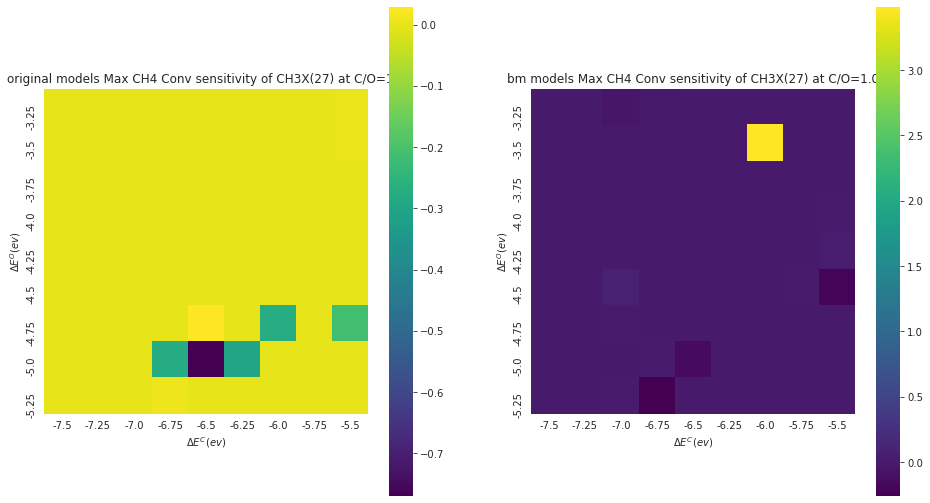

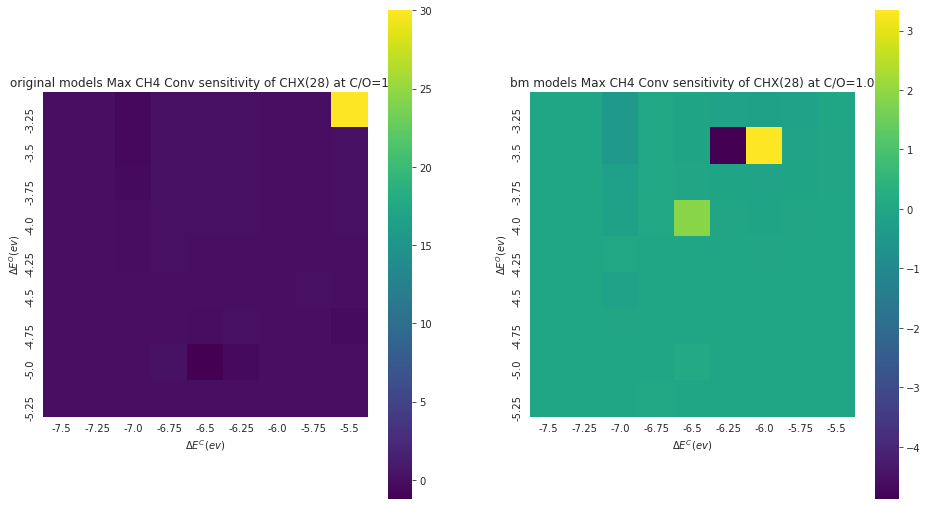

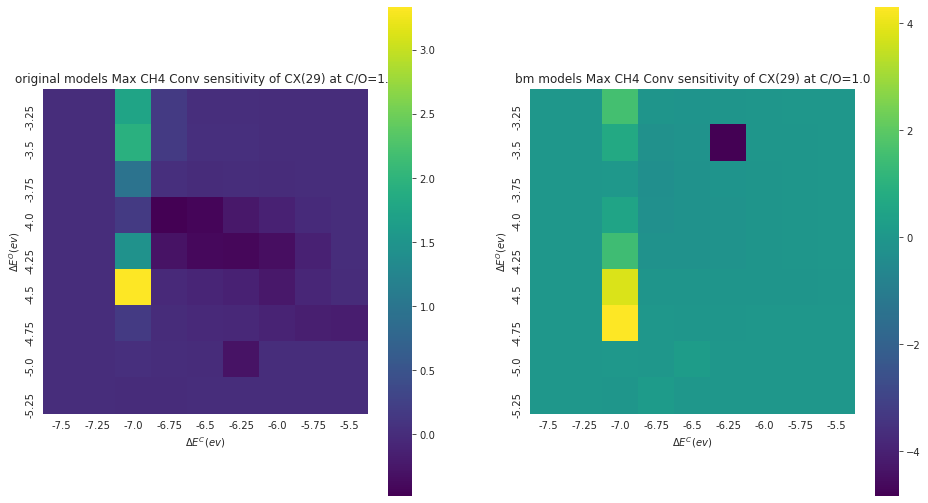

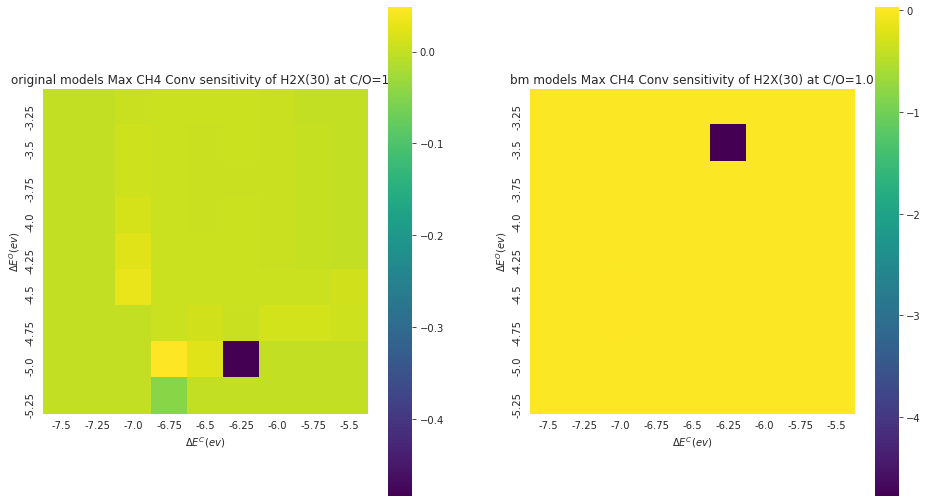

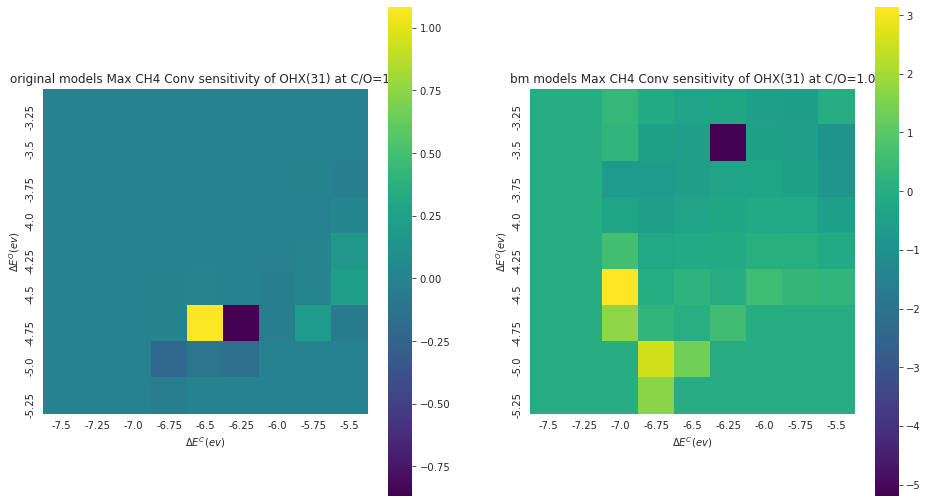

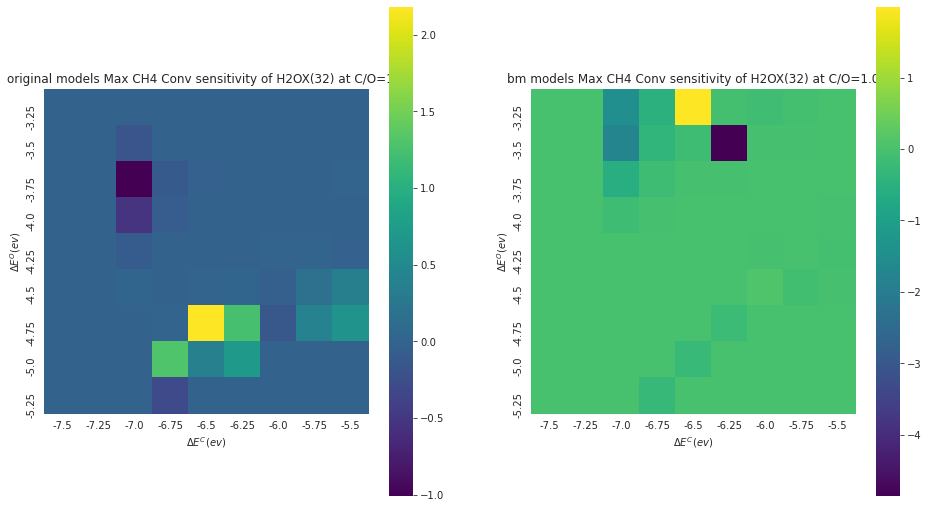

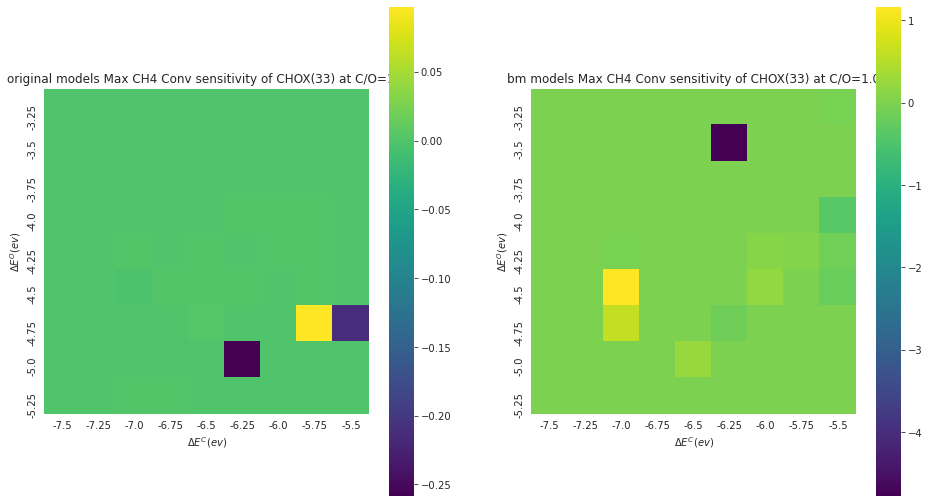

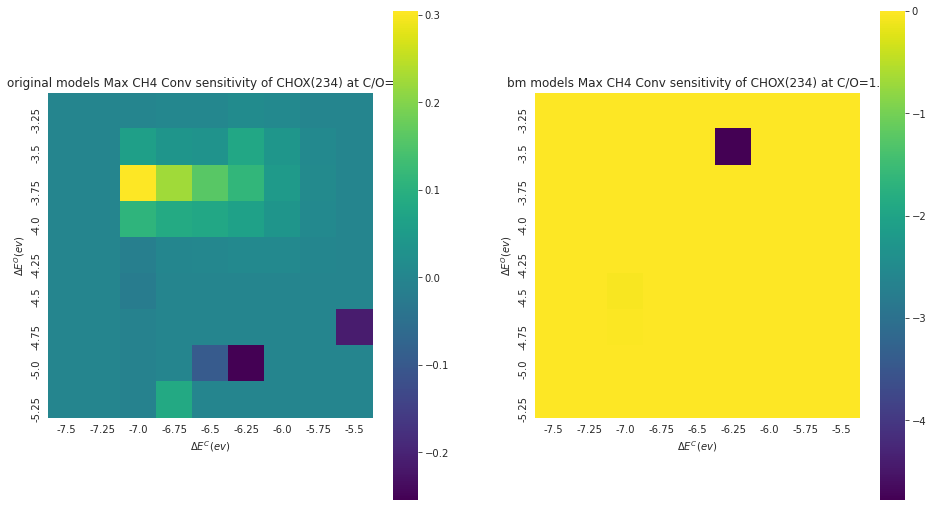

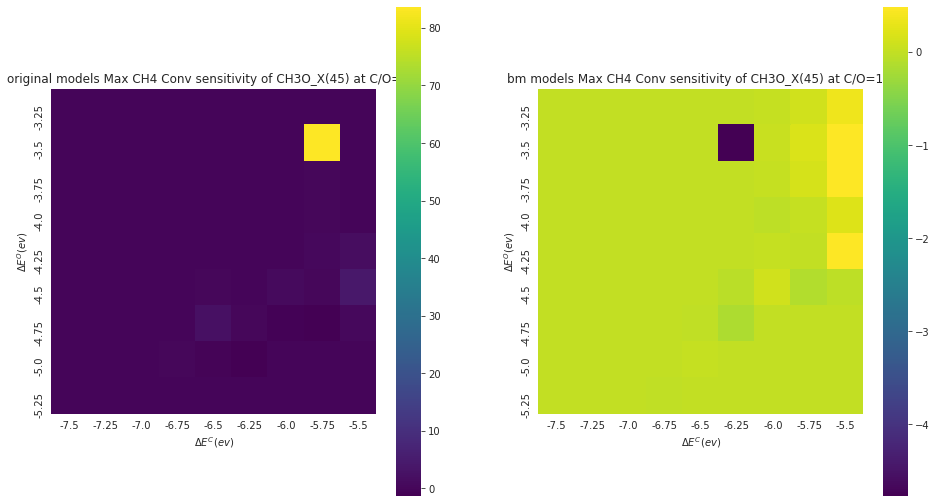

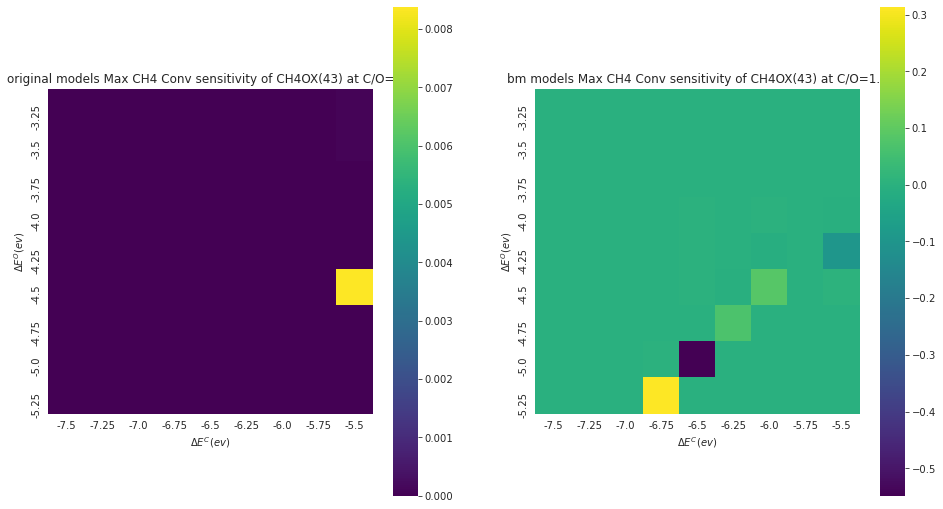

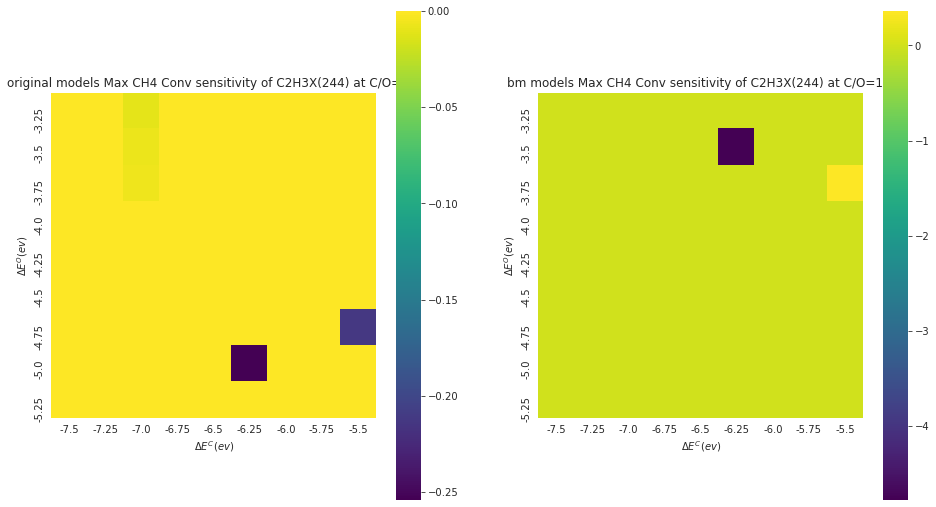

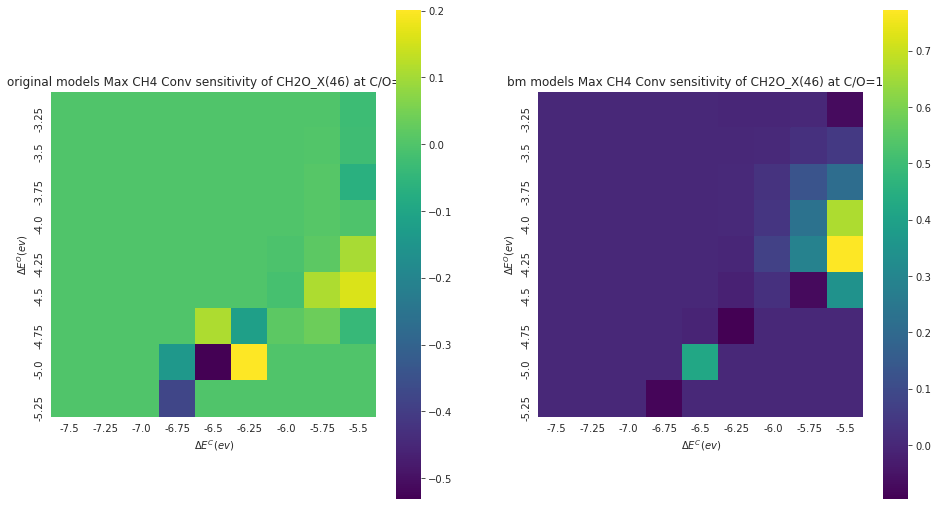

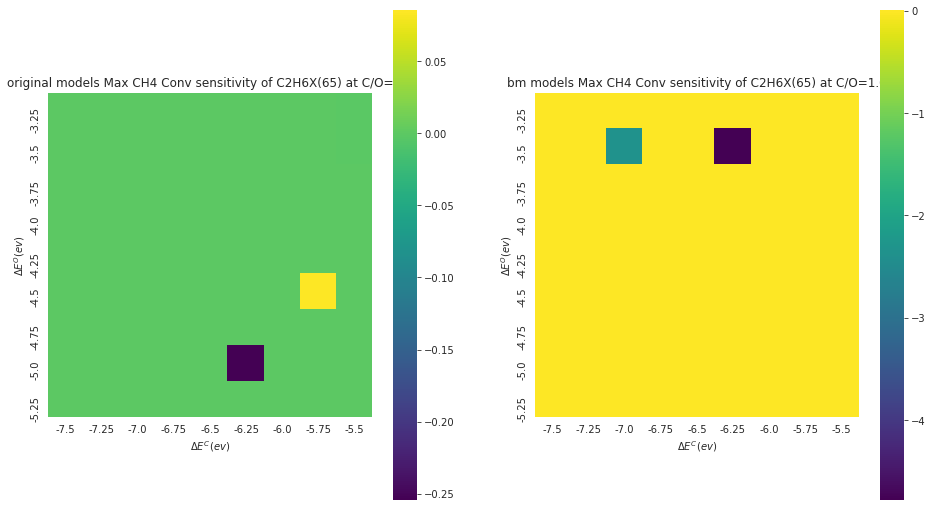

In [44]:
# Max CH4 Conv
for i in range(1, len(species)):
    heat_map_gen(i,15, exceptions_original, exceptions_bm)

[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00e-10_atol1.00e-20.csv' check log files 81.0
[Errno 2] No such file or directory: 'base_original/binding_energies/81.0_c-7.50o-5.25/sensitivities/1.0/1.0SpSensitivity_rtol1.00

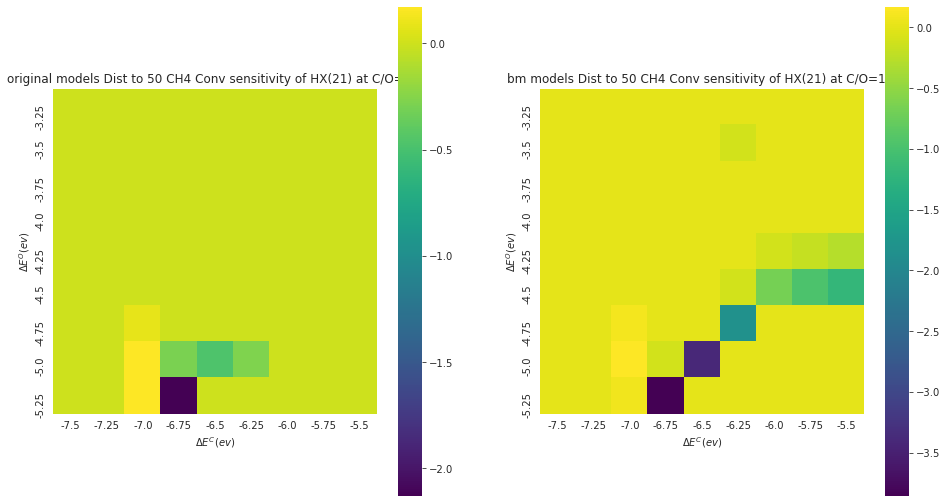

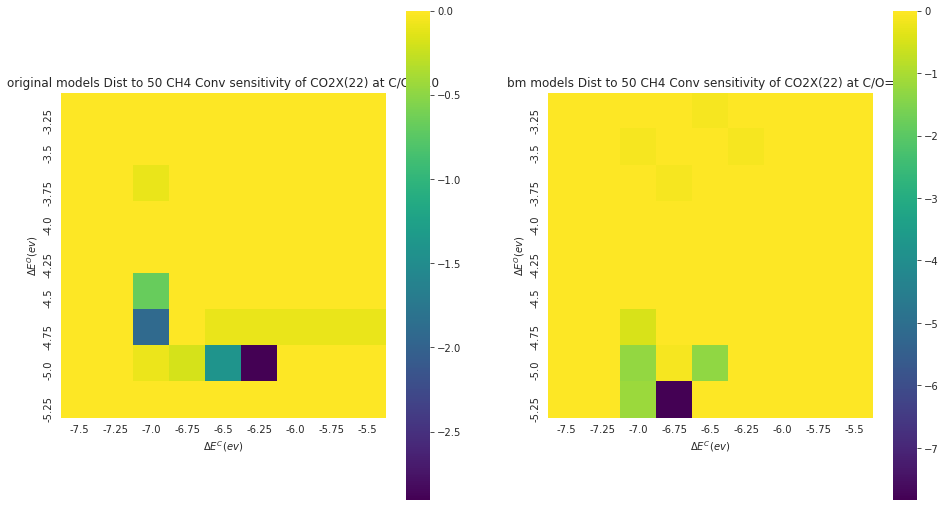

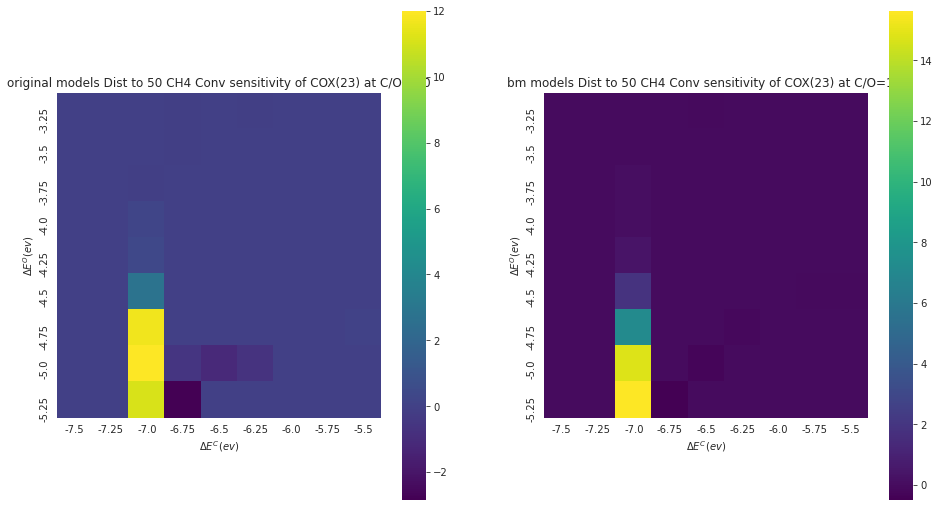

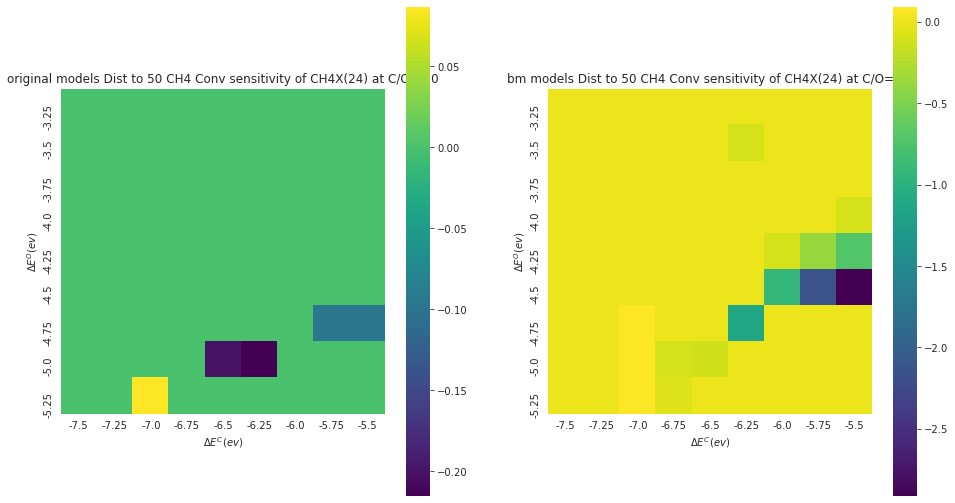

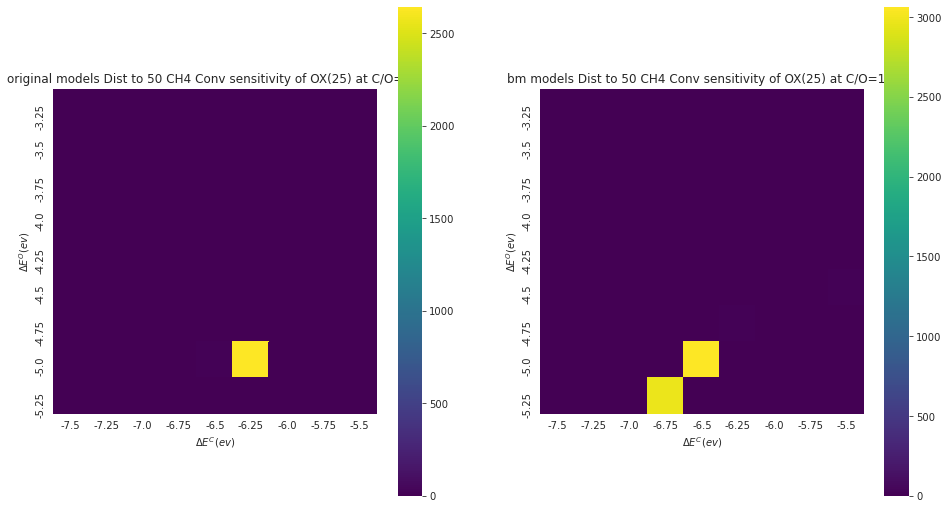

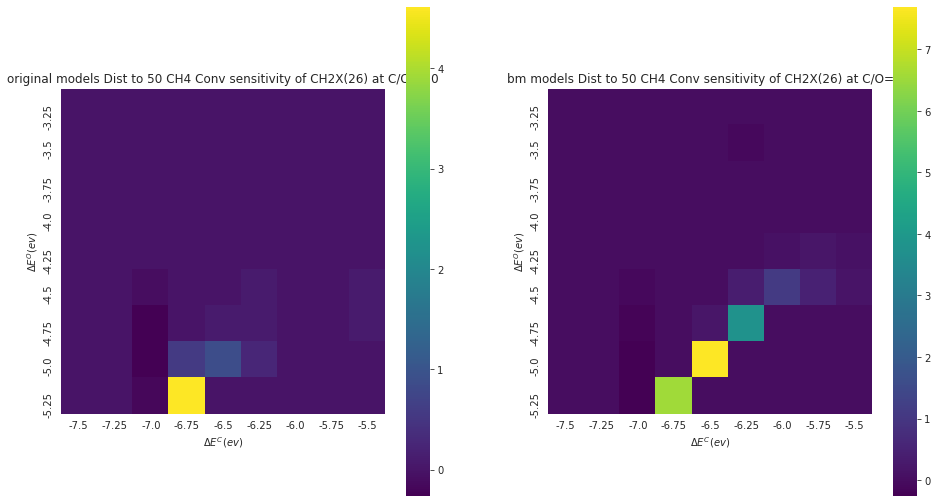

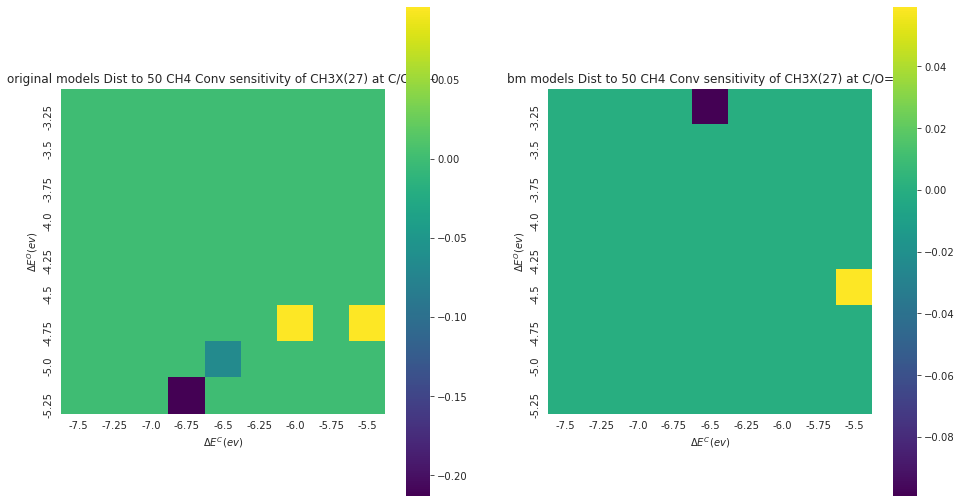

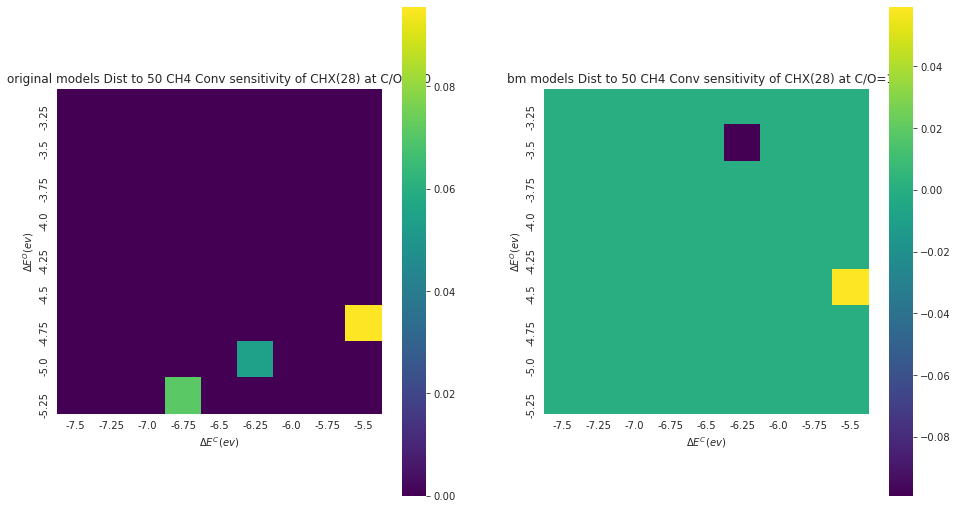

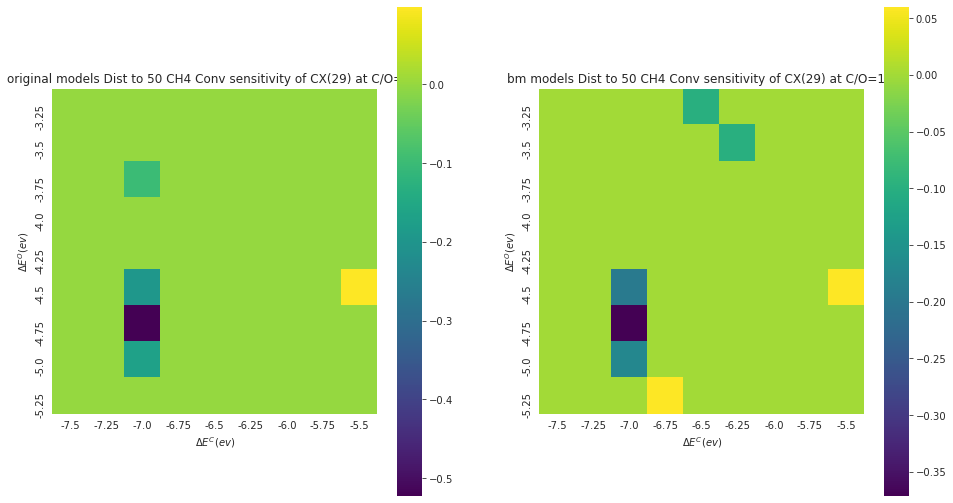

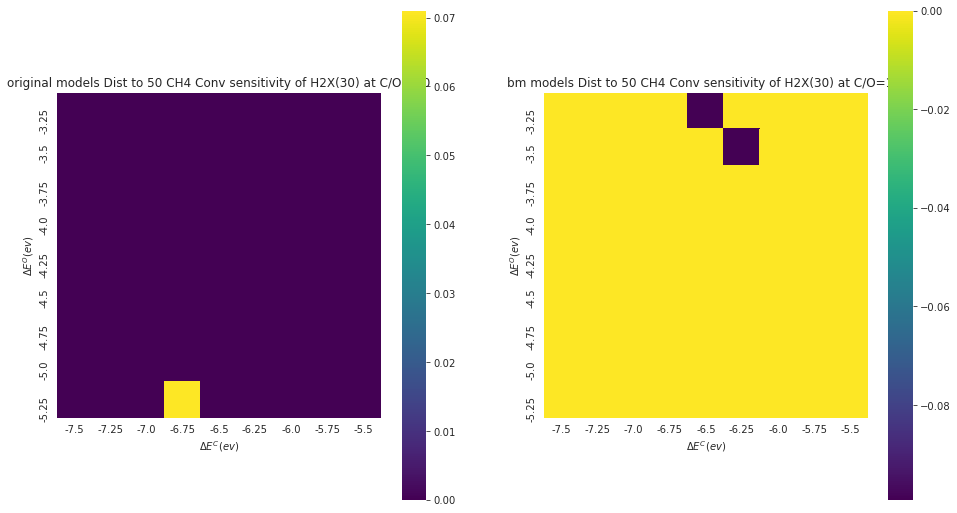

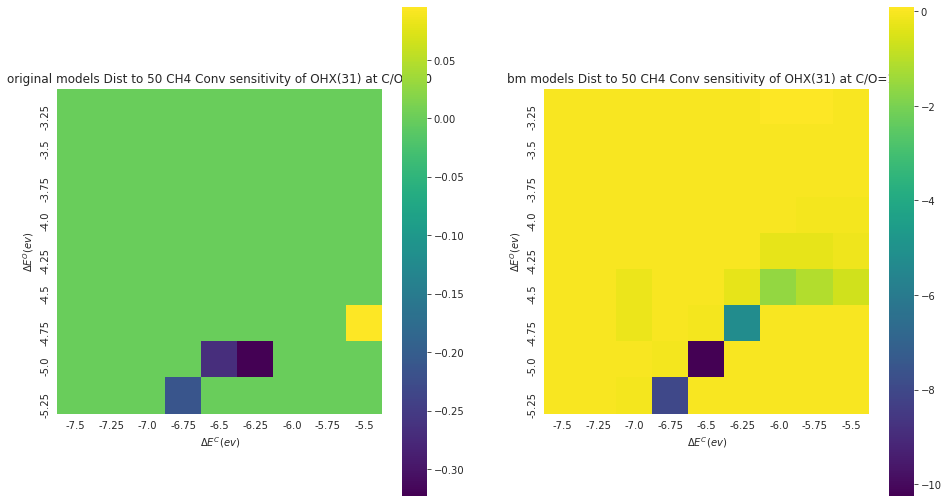

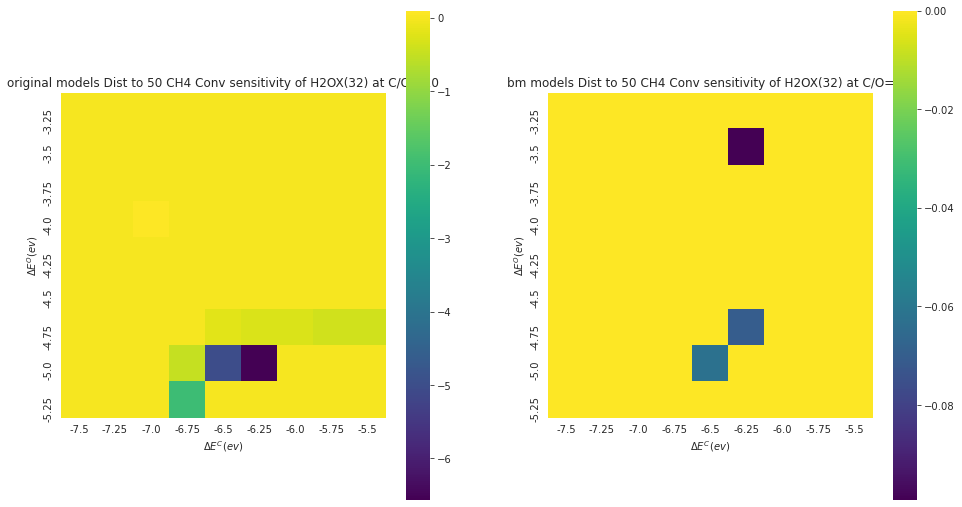

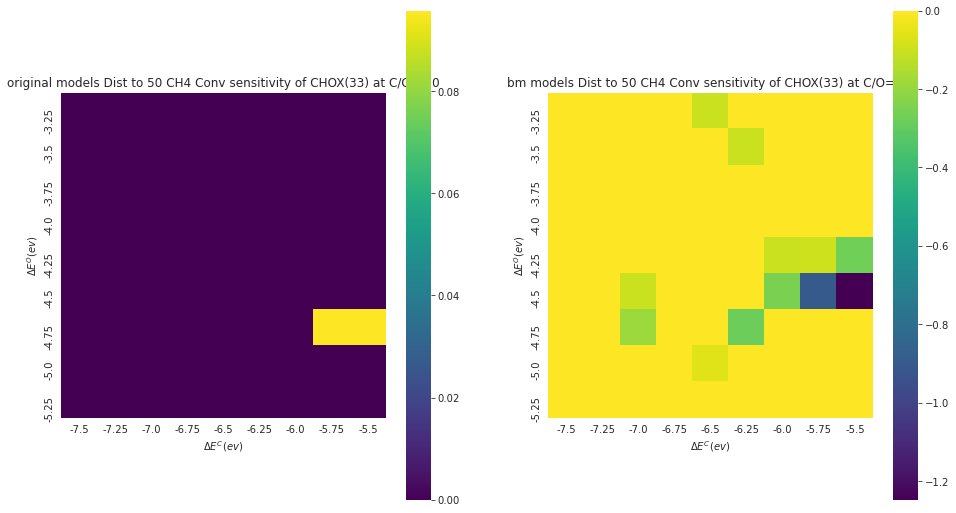

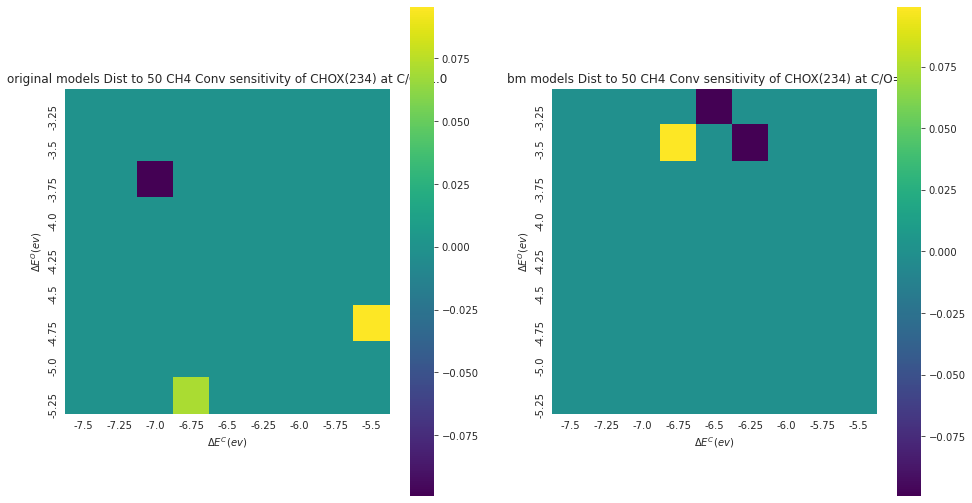

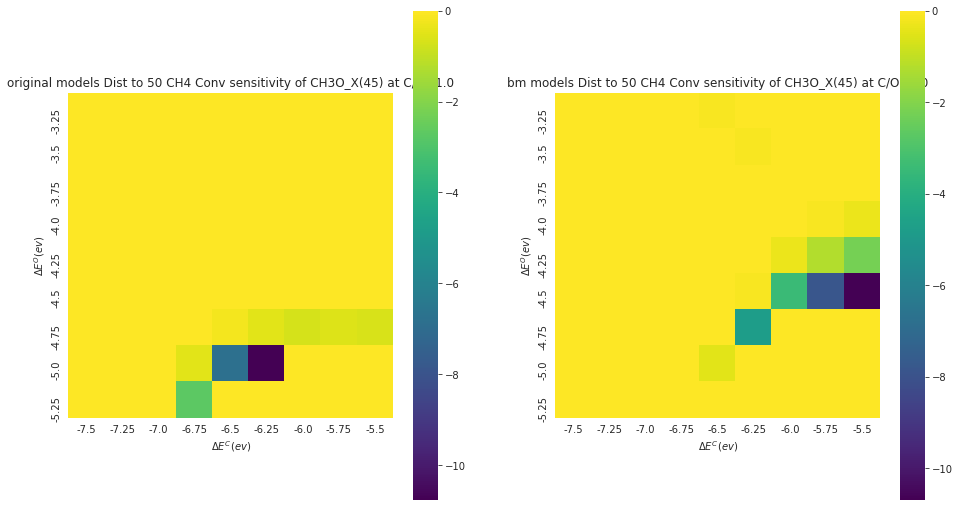

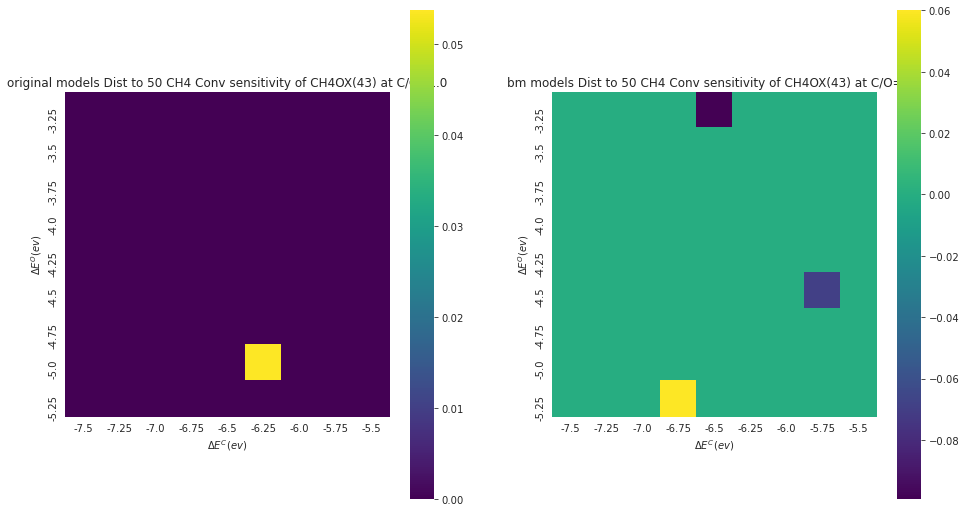

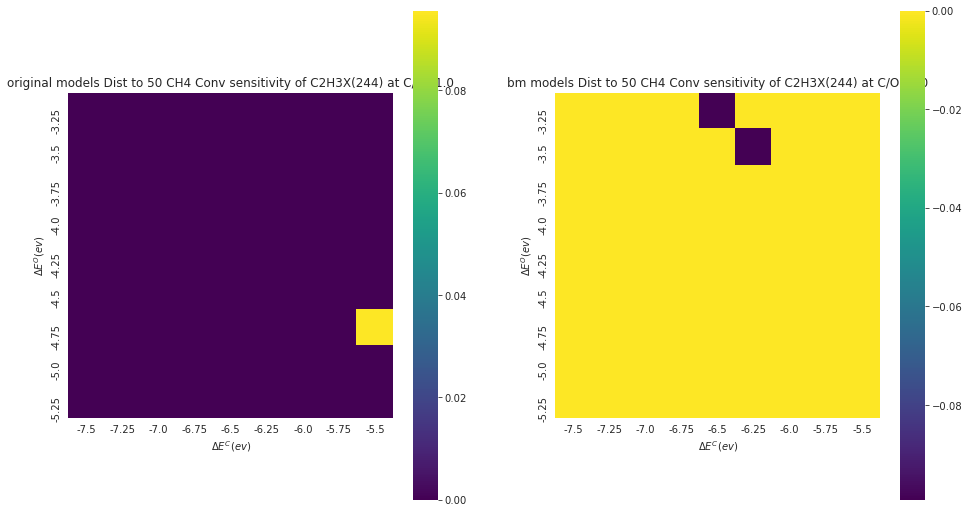

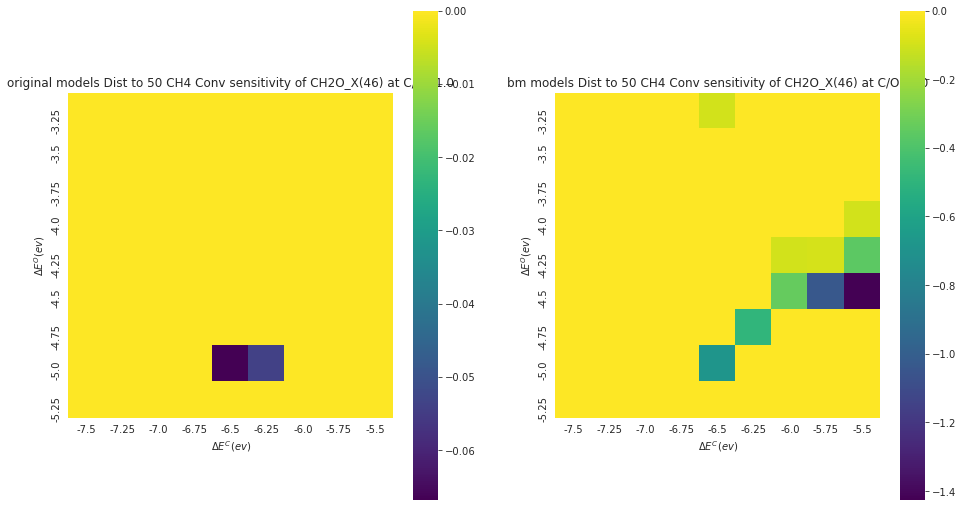

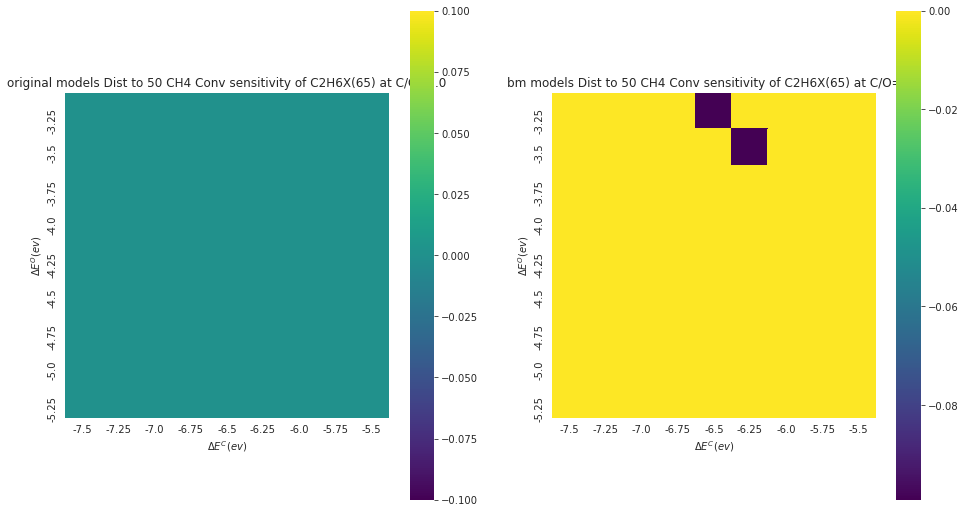

In [46]:
# Dist to 50 CH4 Conv
for i in range(1, len(species)):
    heat_map_gen(i,16, exceptions_original, exceptions_bm)

In [12]:
f = 'base_original/binding_energies/1.0_c-5.50o-3.25/sim_data/rtol_1e-10_atol_1e-20_data.csv'
df = pd.read_csv(f)

properties = df.columns.to_list()

In [15]:
properties

['Unnamed: 0',
 'C/O ratio',
 'CH4 in',
 'CH4 out',
 'CO out',
 'H2 out',
 'H2O out',
 'CO2 out',
 'Exit temp',
 'Max temp',
 'Dist to max temp',
 'O2 conv',
 'Max CH4 Conv',
 'Dist to 50 CH4 Conv']